In [62]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import first_level_from_bids
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level.hemodynamic_models import compute_regressor
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
#import gc
from nilearn import plotting
from nilearn.image import smooth_img

In [ ]:
task_label = 'rest'
space_label = 'MNI152NLin6Asym'
data_dir = '/BICNAS2/tuominen/trsnrm/rawdata'
derivatives_folder = '/BICNAS2/tuominen/trsnrm/derivatives/iteration1'
output_dir = '/BICNAS2/tuominen/trsnrm/derivatives/iteration1/fMRI_output_social'
os.makedirs(output_dir, exist_ok=True)

# Process subjects one by one
subjects = sorted([f.name[4:] for f in os.scandir(derivatives_folder) if f.is_dir() and f.name.startswith('sub')])
subjects.remove('trs012')

In [58]:
regressors = pd.read_csv('/BICNAS2/tuominen/trsnrm/regressors/Ratings_Grouped_GPT_Social_Aspects.csv')
SensInput = regressors['Sensory Input '] - np.mean(regressors['Sensory Input '])


<Axes: >

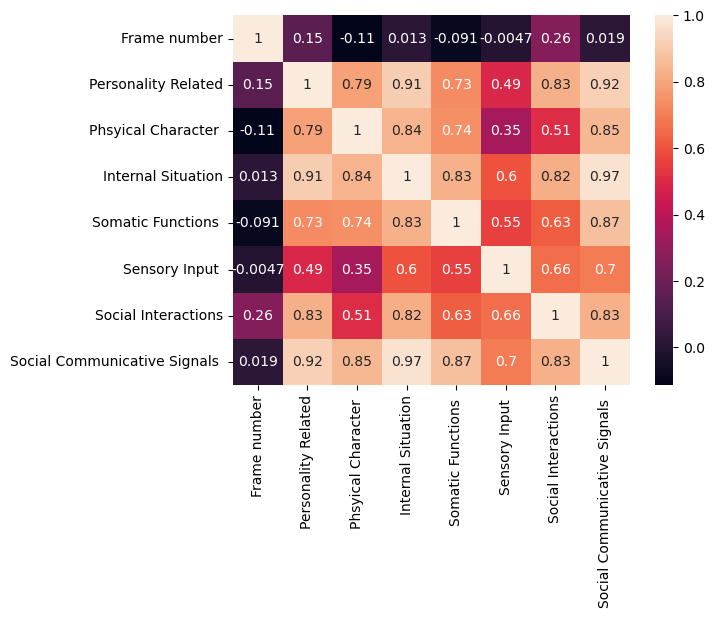

In [69]:
from seaborn import heatmap
regressors.corr()
heatmap(regressors.corr(), annot=True)

In [61]:
for subject in subjects:

#subject = 'trs001'  # For testing, process only the first subject
    if os.path.exists(os.path.join(output_dir, f'{subject}_ses-001_task-rest_run-01_confound-simple_contrast-mov1_sensinput.nii.gz')):
        print(f'Subject {subject} already processed, skipping.')
        continue
    
    # Get data for this subject
    models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
        data_dir,
        task_label,
        space_label,
        smoothing_fwhm=0,
        signal_scaling=(0,1),
        # very important to indicate None for slice_time_ref as it will be inferred from BIDS json
        slice_time_ref=None,
        derivatives_folder=derivatives_folder,
        n_jobs=-1,  # Reduced to 1 to save memory
        sub_labels=[subject]
    )
    img, event, confound = models_run_imgs[0][0], models_events[0][0], models_confounds[0][0]

    confound = load_confounds_strategy(img, denoise_strategy='simple')

    tr = models[0].t_r
    n_scans = nib.load(img).shape[-1]
    frame_times = np.arange(n_scans) * tr
    hrf_model = 'glover'
    X = make_first_level_design_matrix(
        frame_times,
        event,
        drift_model=None,
        drift_order=None,
        add_regs=confound[0],
        add_reg_names=confound[0].columns.tolist(),
        hrf_model=hrf_model,
    )

    onsets = frame_times
    durations = np.full(n_scans, tr)              # length n_scans
    amplitudes = SensInput.to_numpy().ravel()     # length n_scans

    exp_condition = (onsets, durations, amplitudes)

    exp_regressor, reg_names = compute_regressor(
        exp_condition,
        hrf_model=hrf_model,
        frame_times=frame_times,
        con_id="SensInput",
        oversampling=16,
    )

    X.iloc[:,0] =exp_regressor  # Replace the first regressor with our custom regressor
    X.columns.values[0] = 'Sensory_Input'  # Rename the column accordingly

    fitted_model = models[0].fit(img, design_matrices=X)

    contrasts = {
                'mov1_sensinput': 'Sensory_Input',
             }

    for contrast_name, contrast_def in contrasts.items():
        b_map = models[0].compute_contrast(contrast_def, output_type='effect_size')
        output_filename = f'{subject}_ses-001_task-rest_run-01_confound-simple_contrast-{contrast_name}.nii.gz'
        nib.save(b_map, os.path.join(output_dir, output_filename))


Subject trs001 already processed, skipping.
Subject trs002 already processed, skipping.
Subject trs003 already processed, skipping.
Subject trs004 already processed, skipping.
Subject trs006 already processed, skipping.
Subject trs008 already processed, skipping.
Subject trs009 already processed, skipping.
Subject trs010 already processed, skipping.
Subject trs013 already processed, skipping.


/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: weight
  warnings.warn(
/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/image/image.py:217: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn(
/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: weight
  warnings.warn(
/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/image/image.py:217: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn(
/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unex

/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figure, figsize=figsize, facecolor=facecolor)


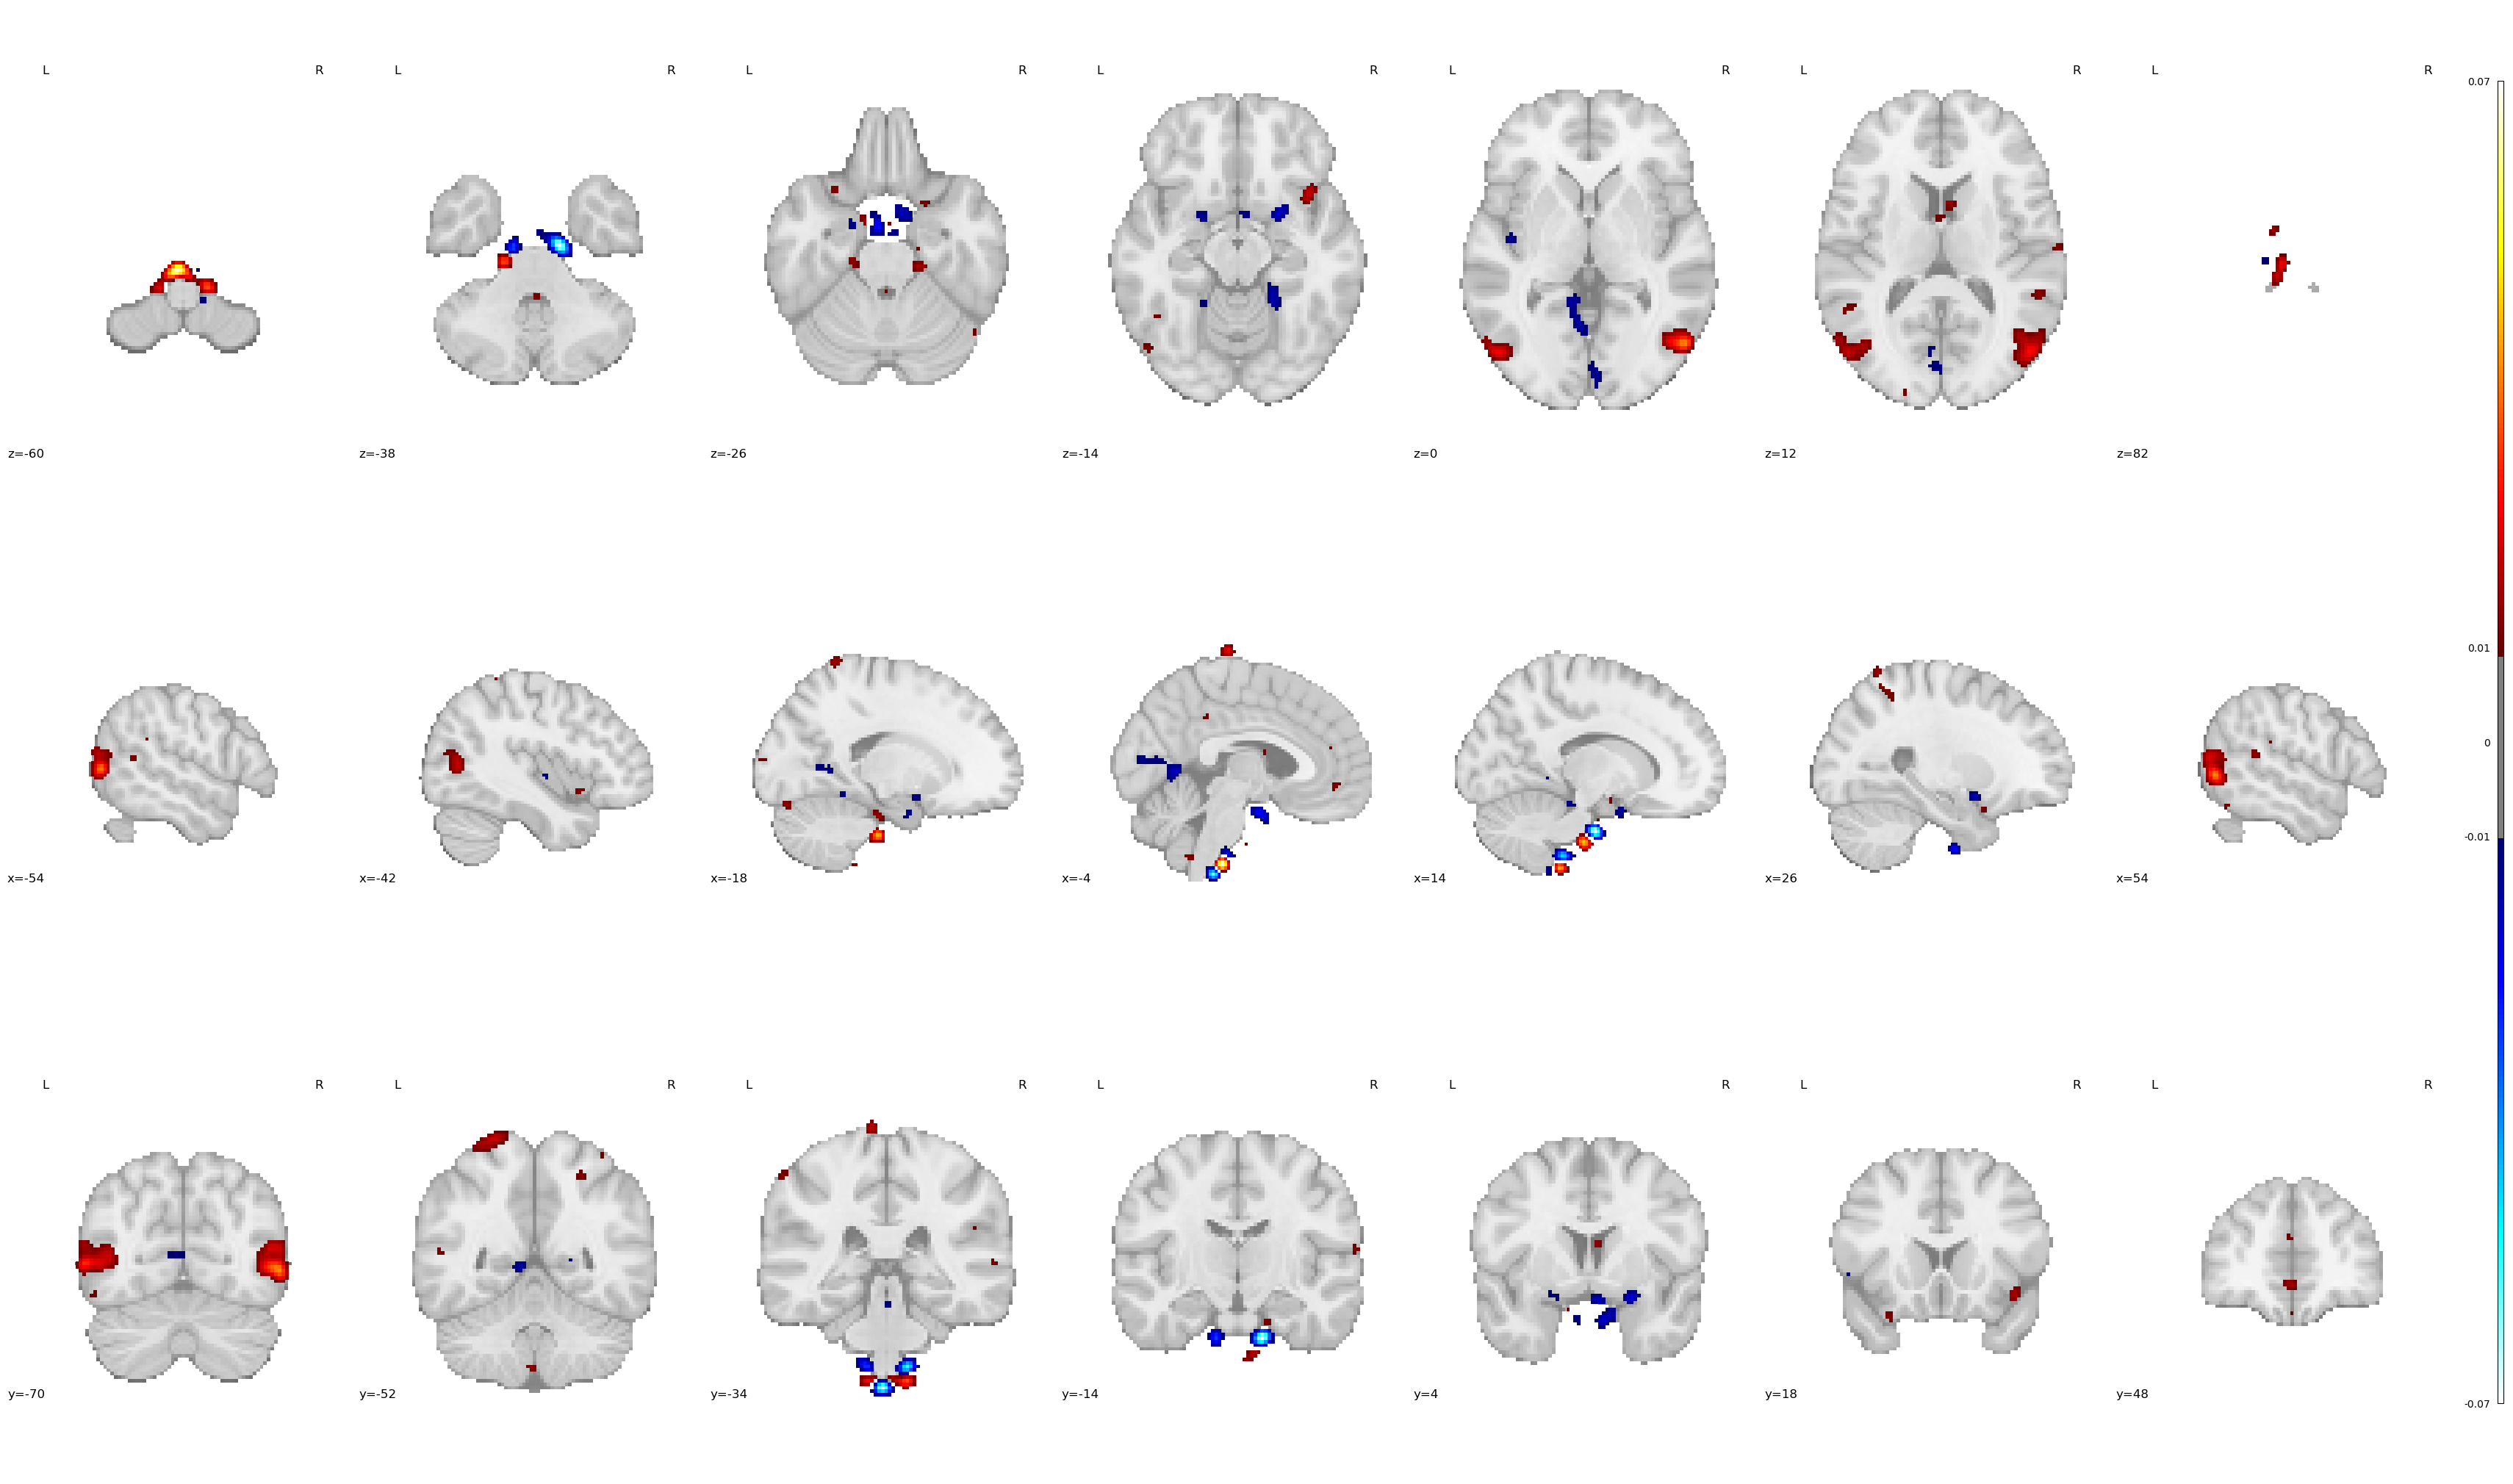

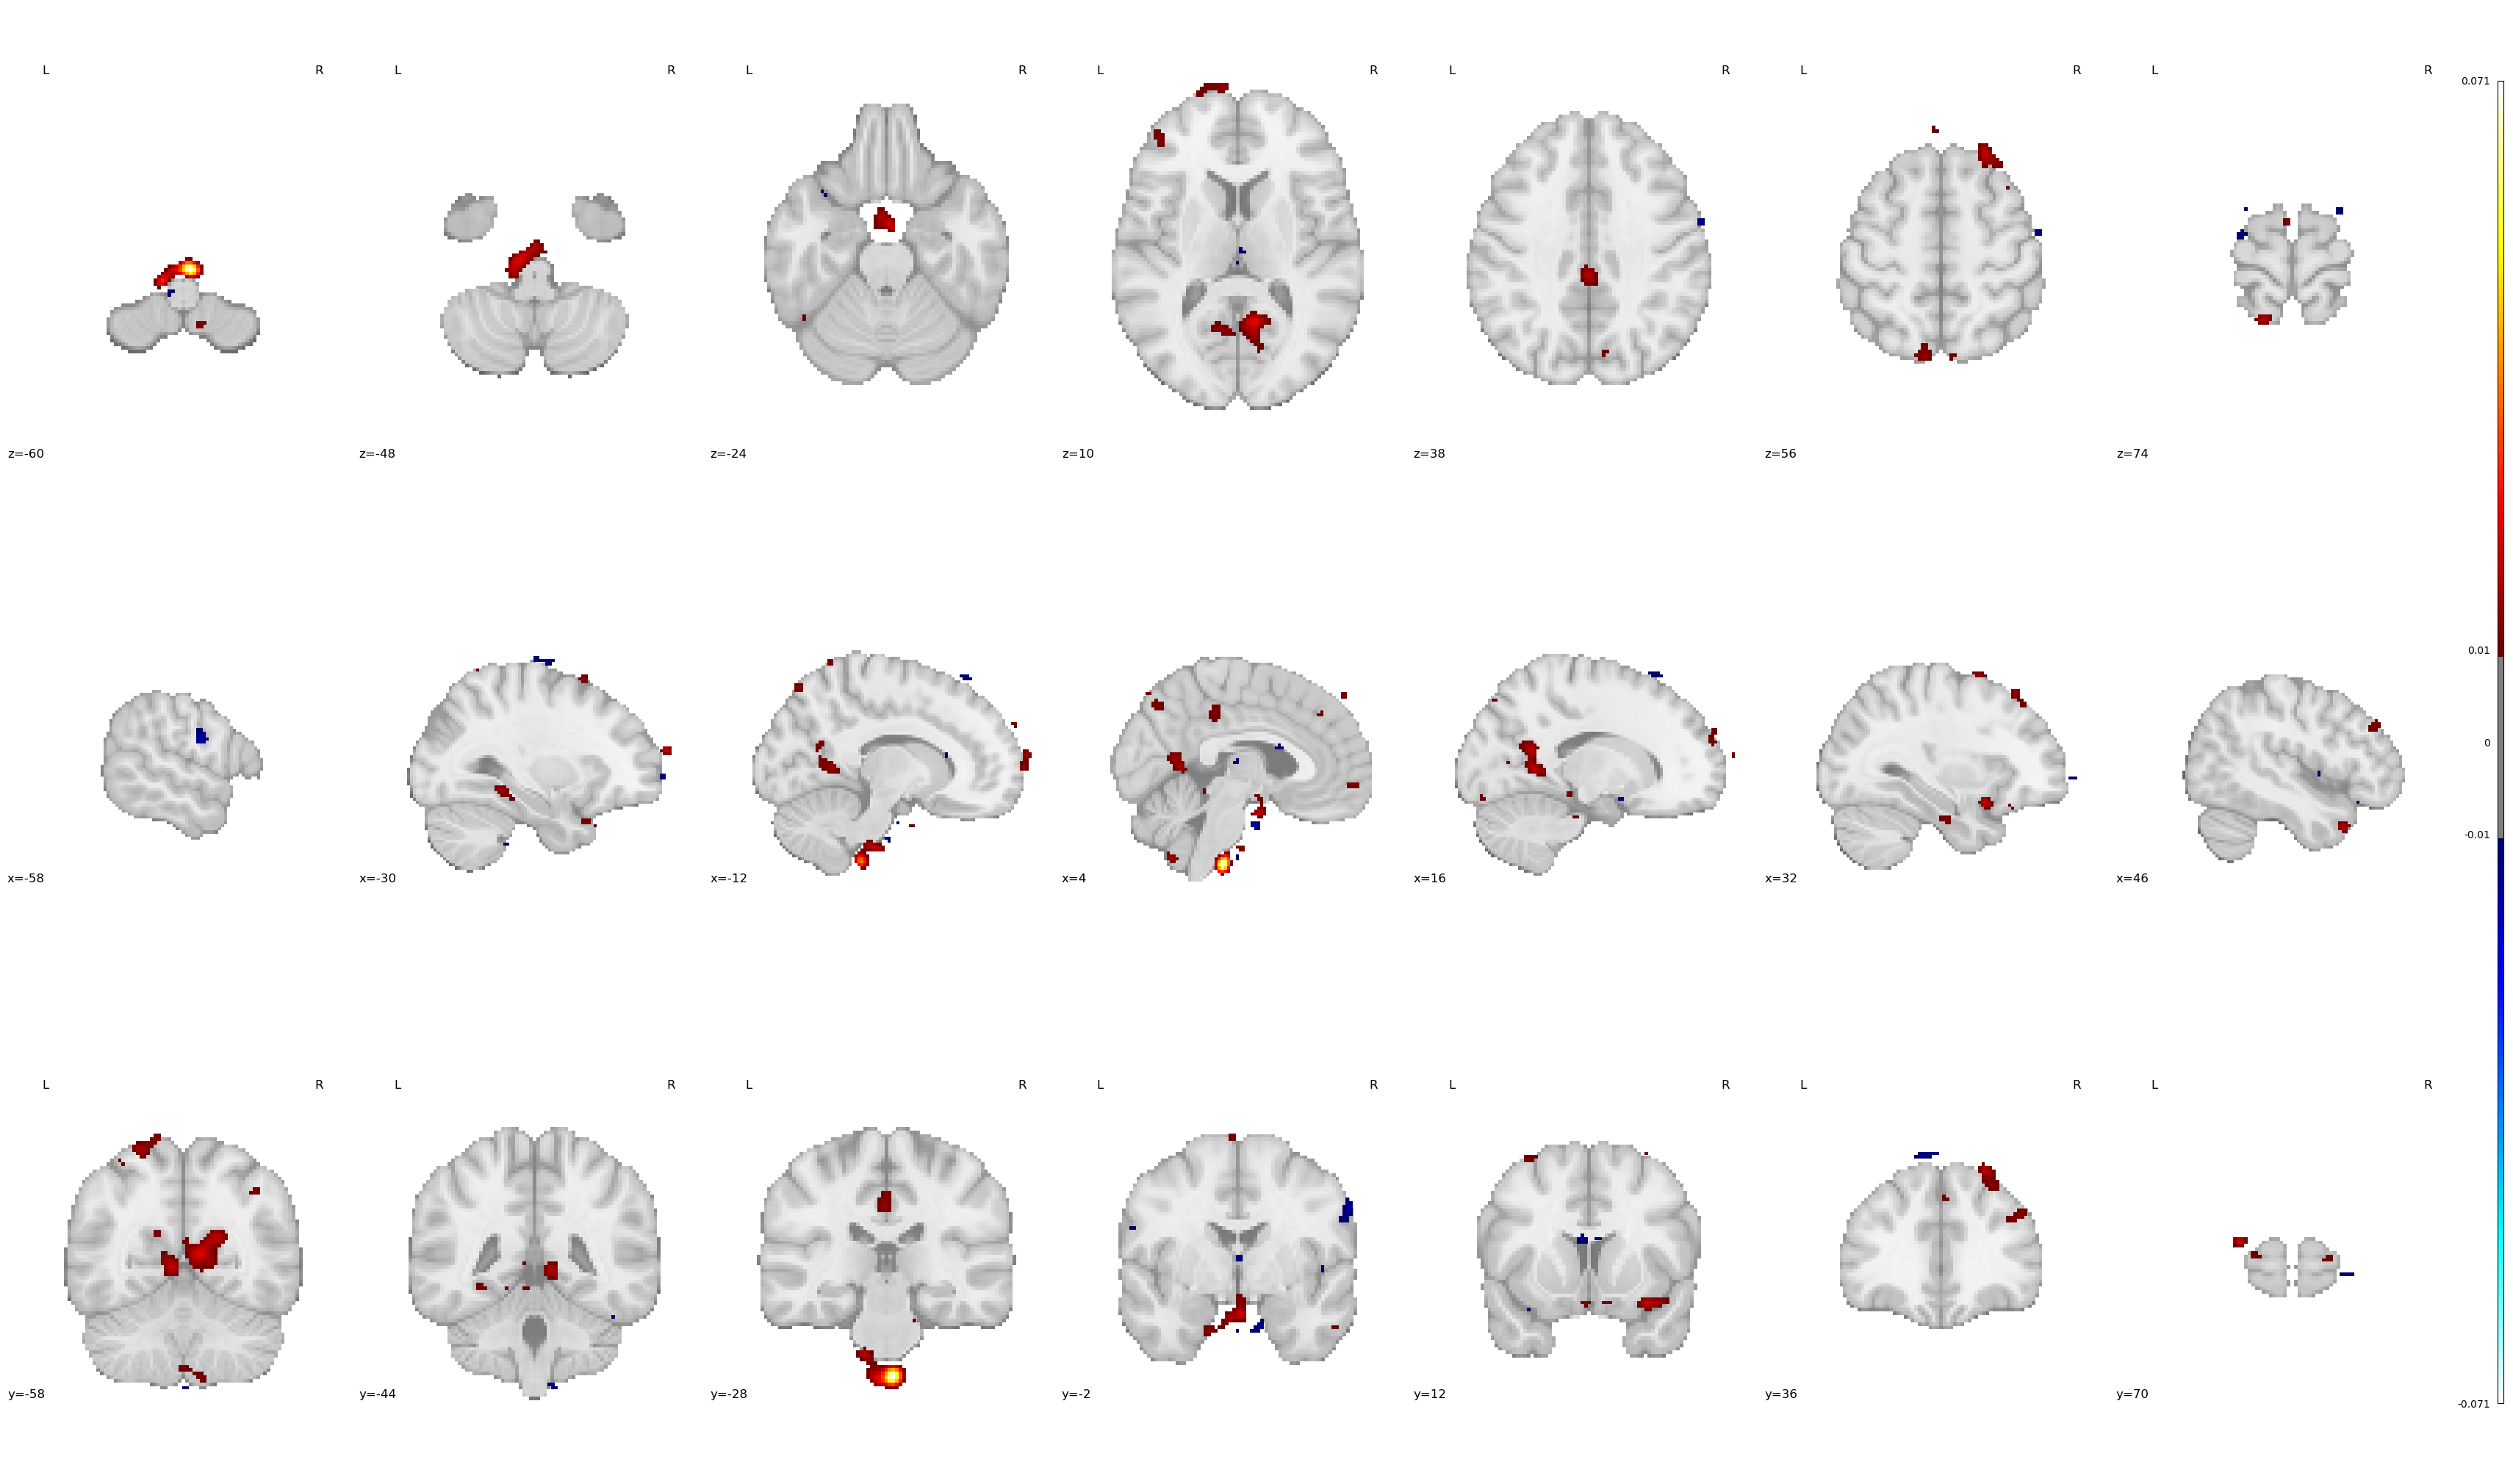

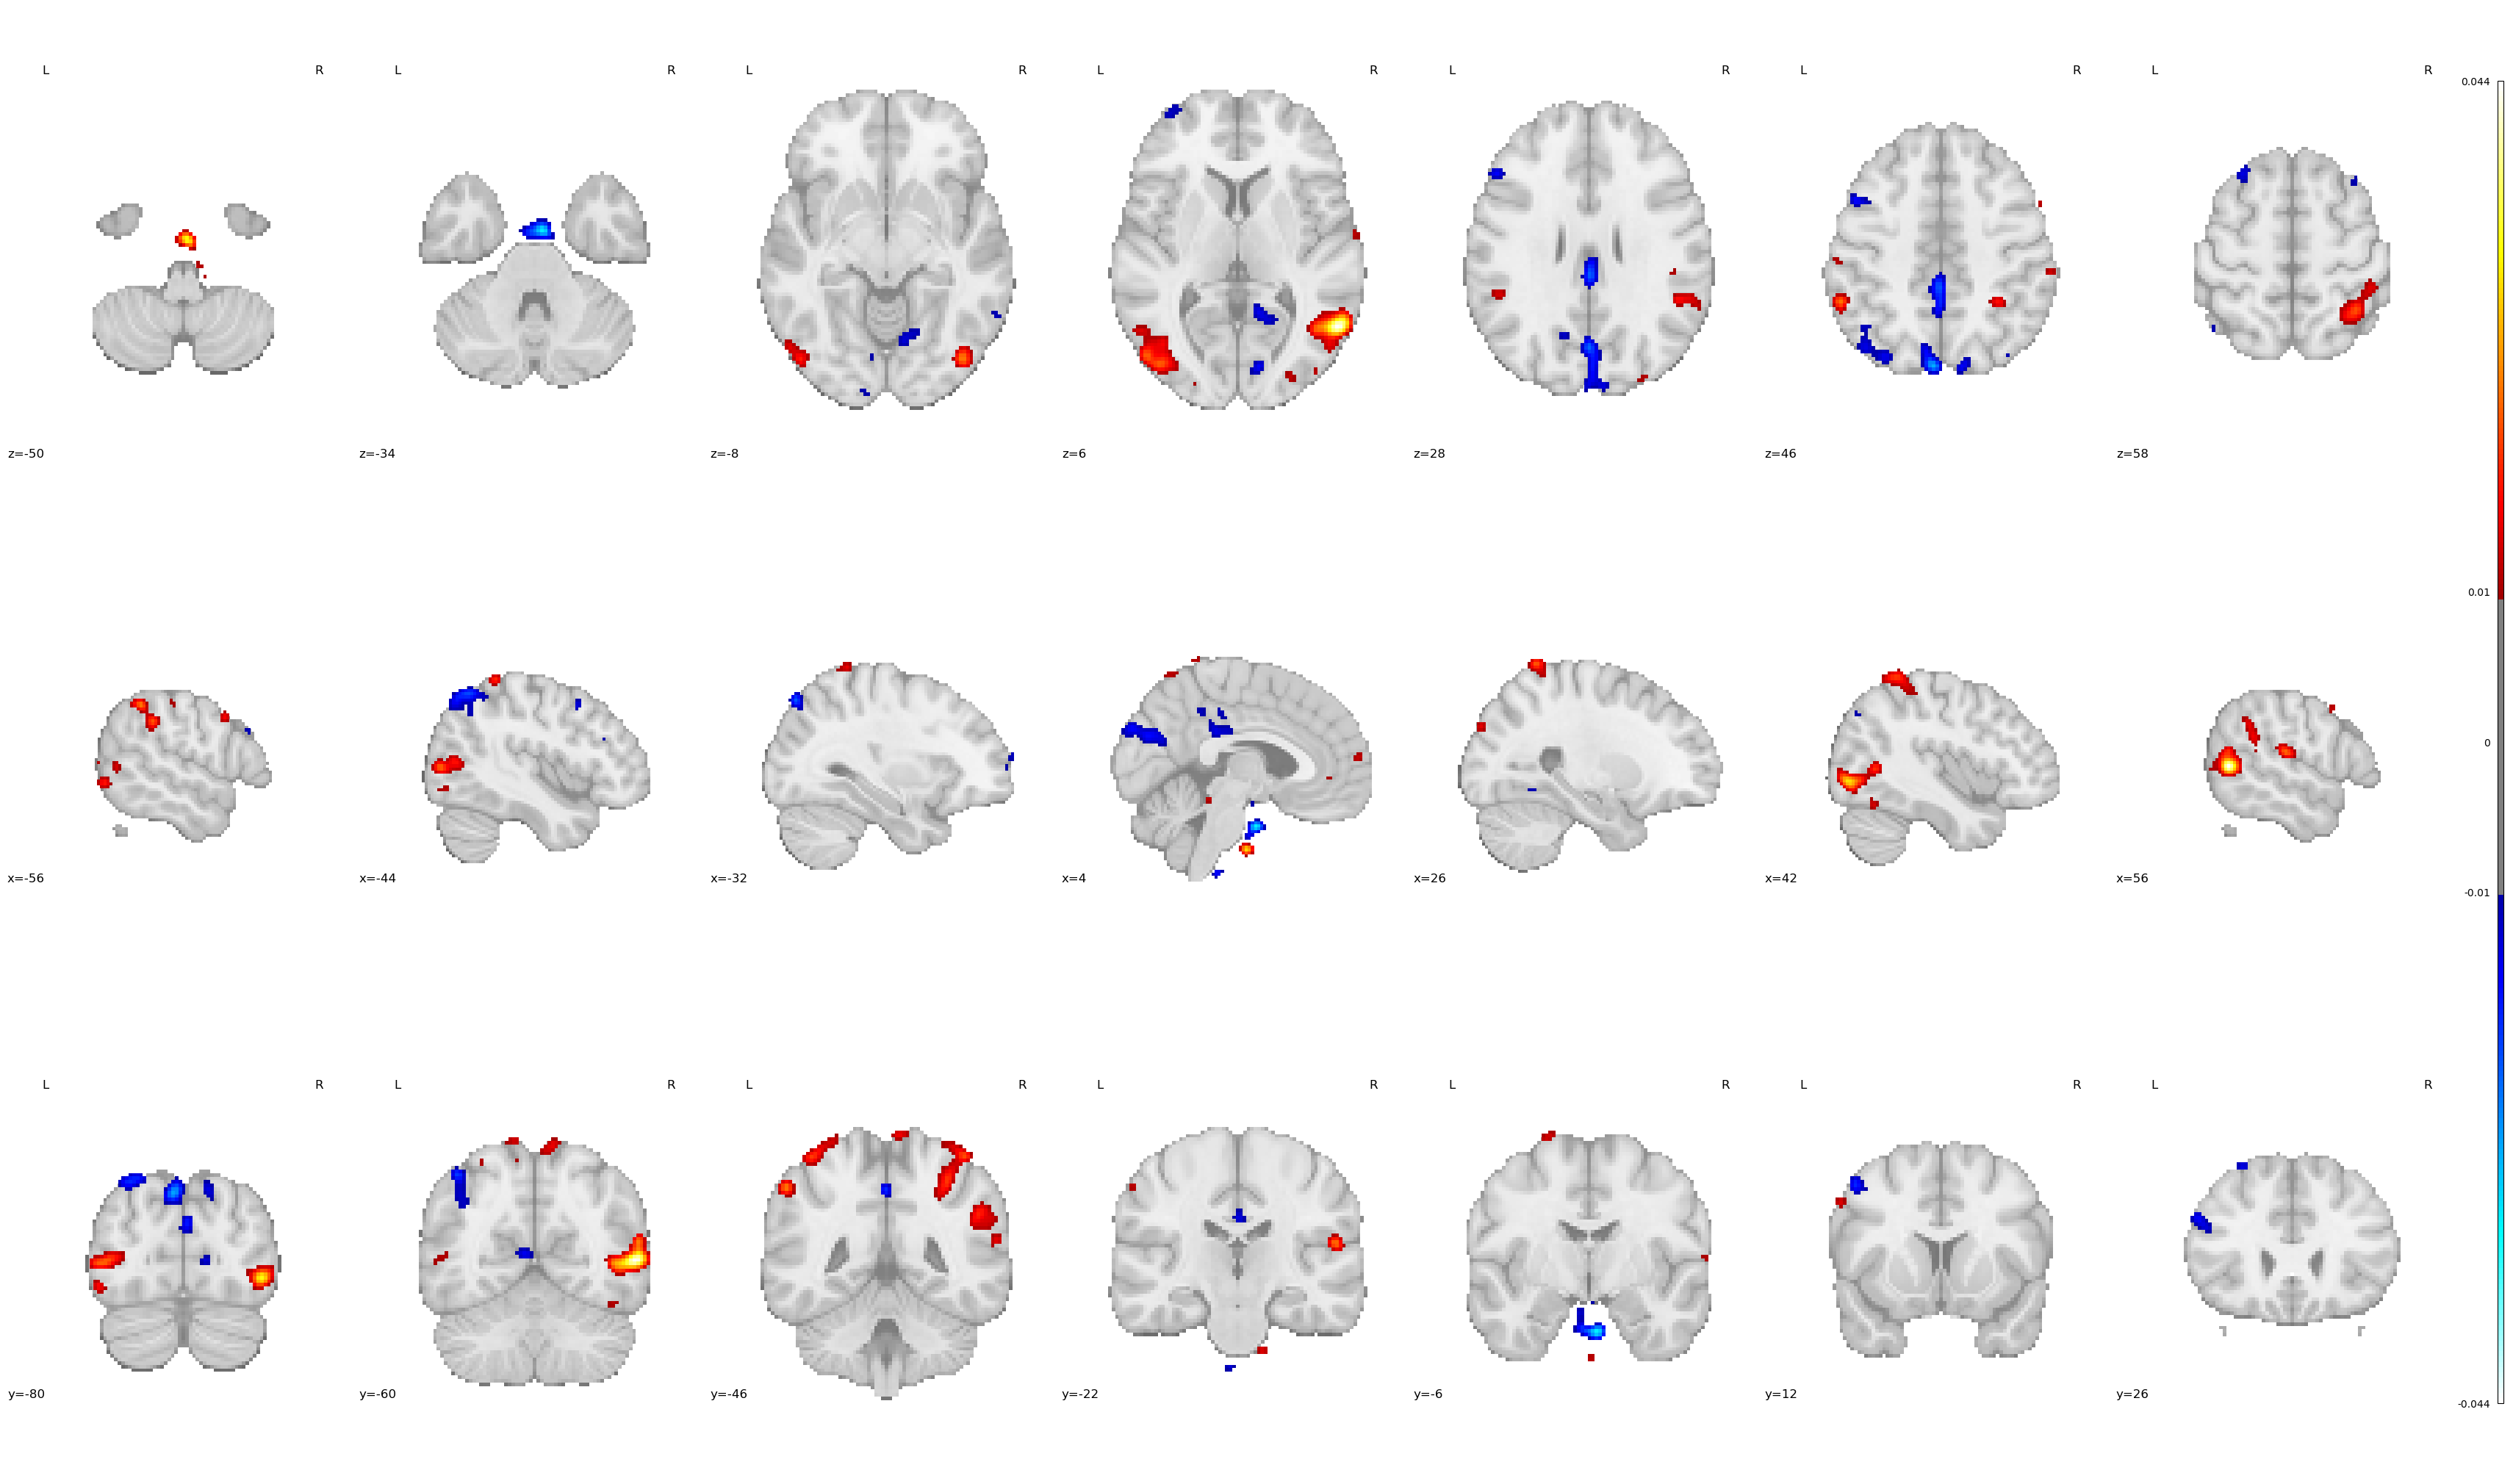

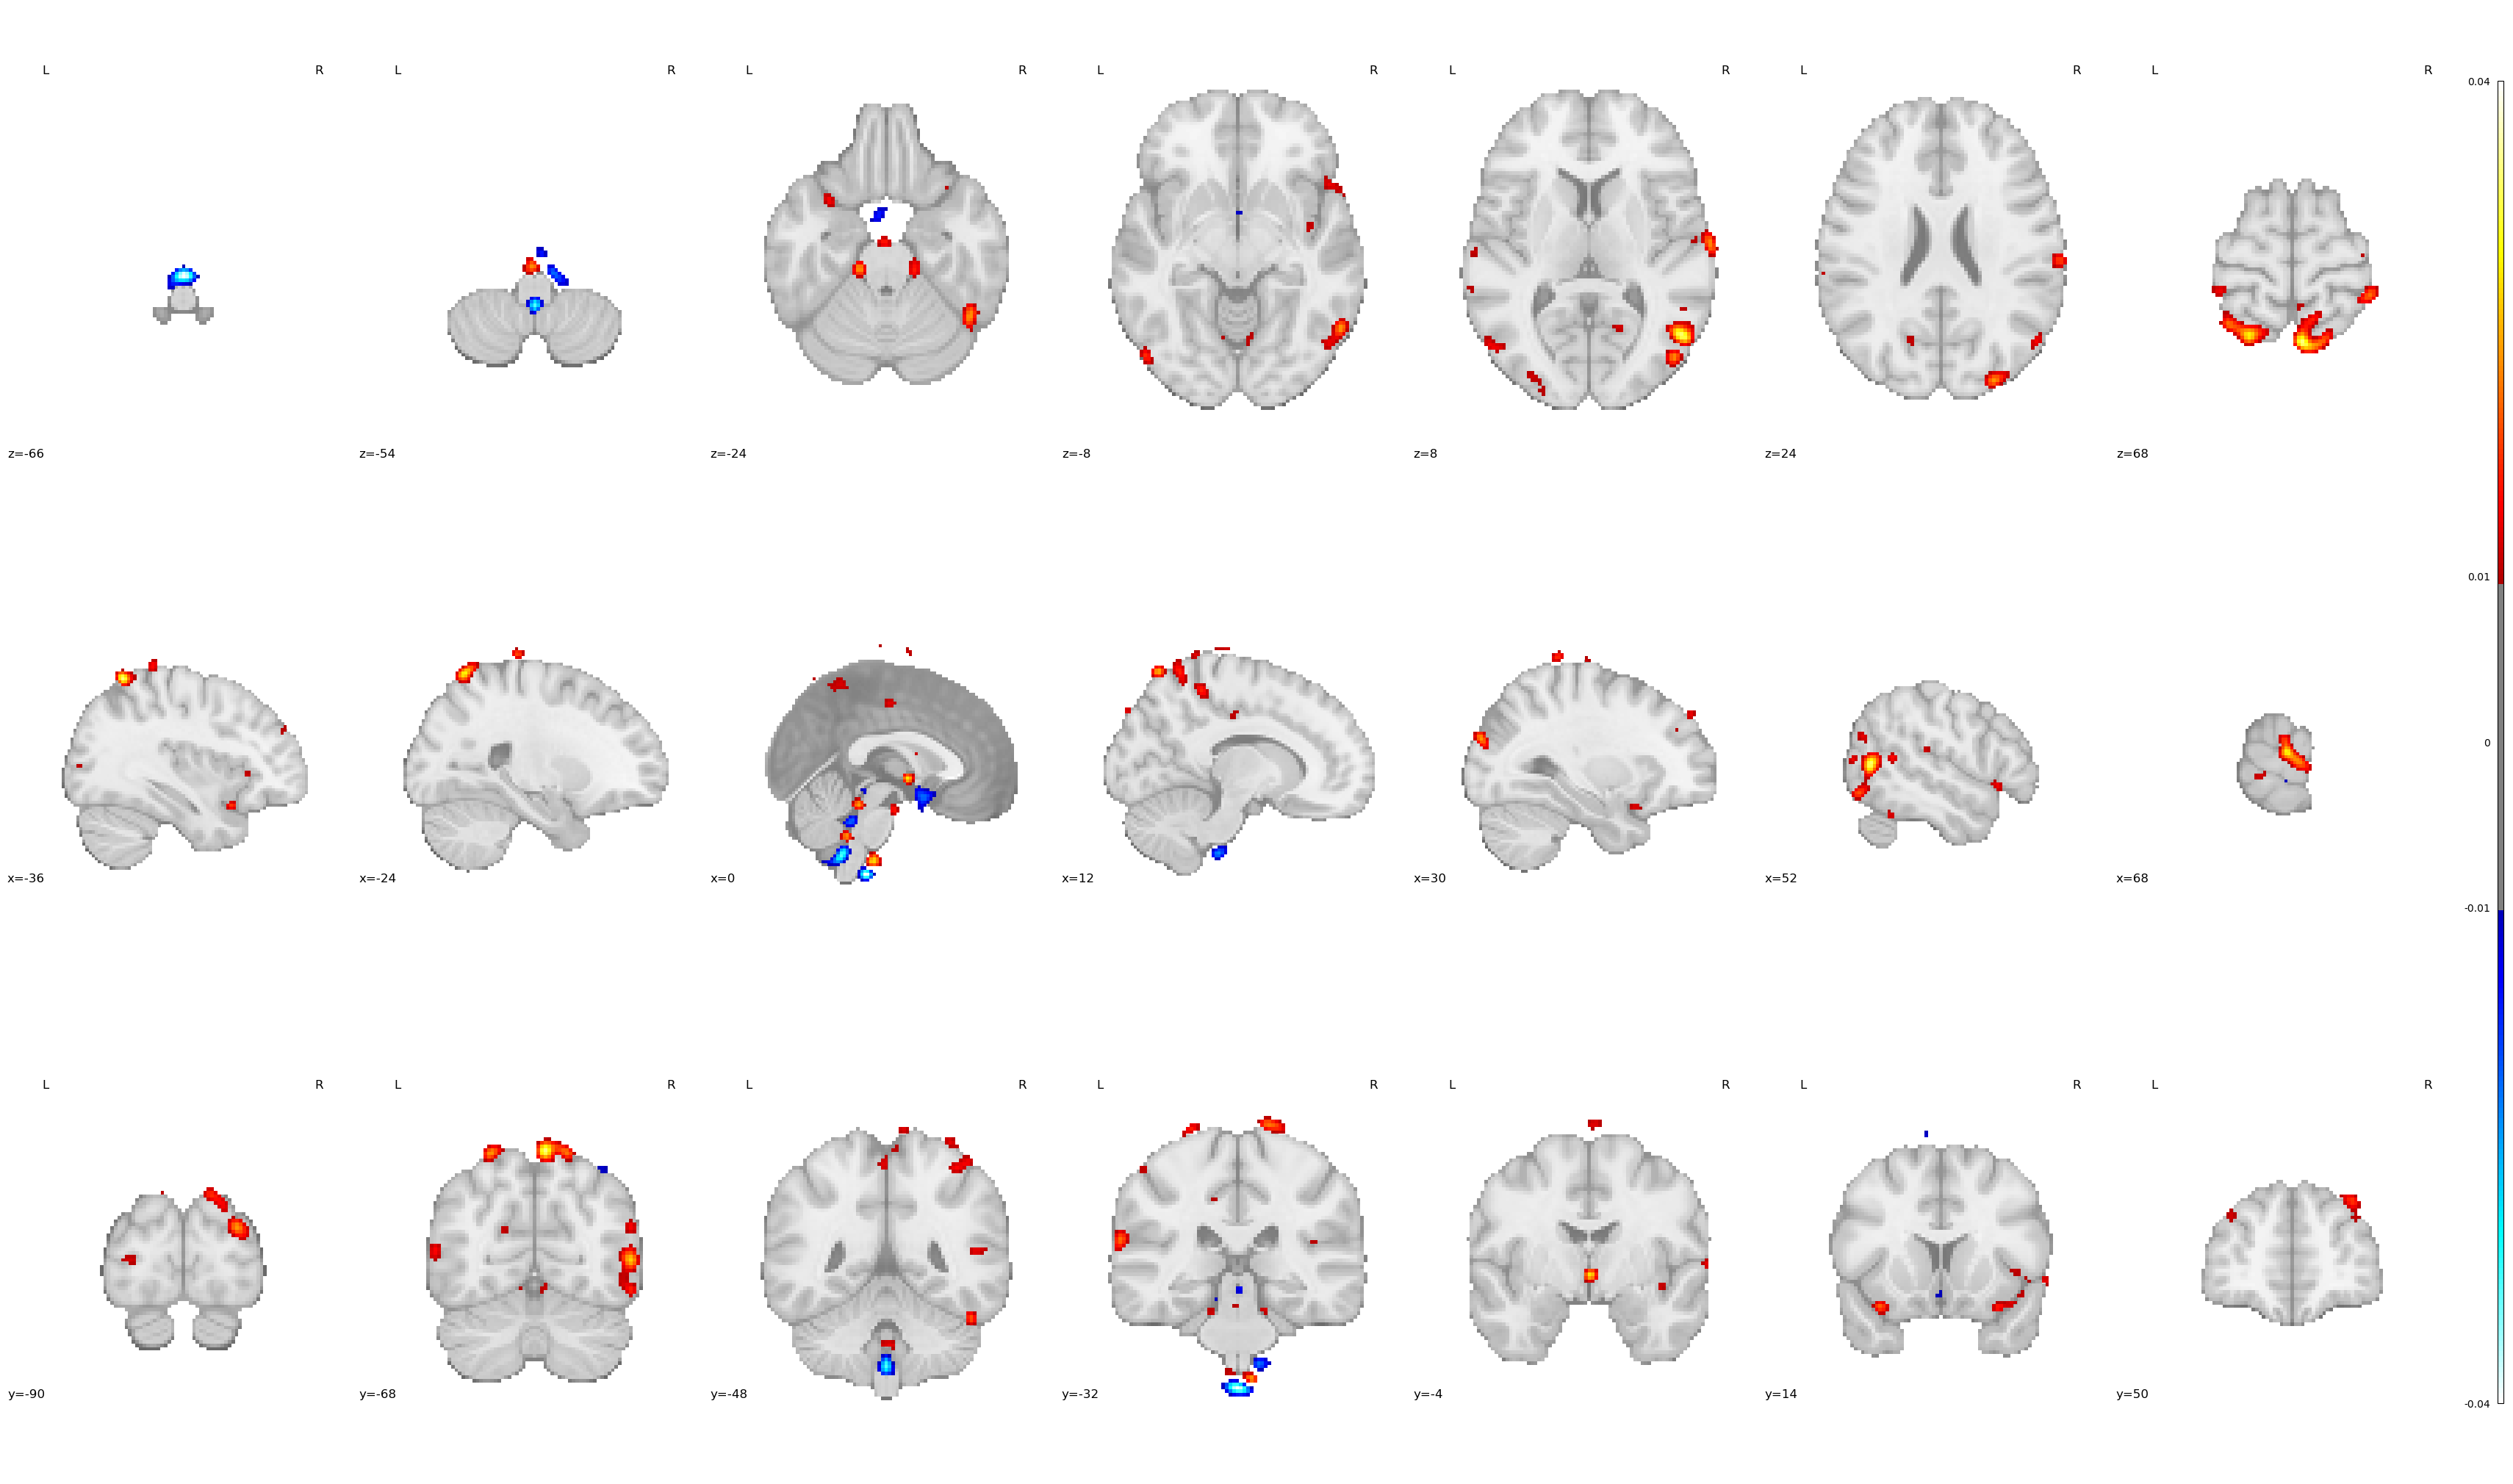

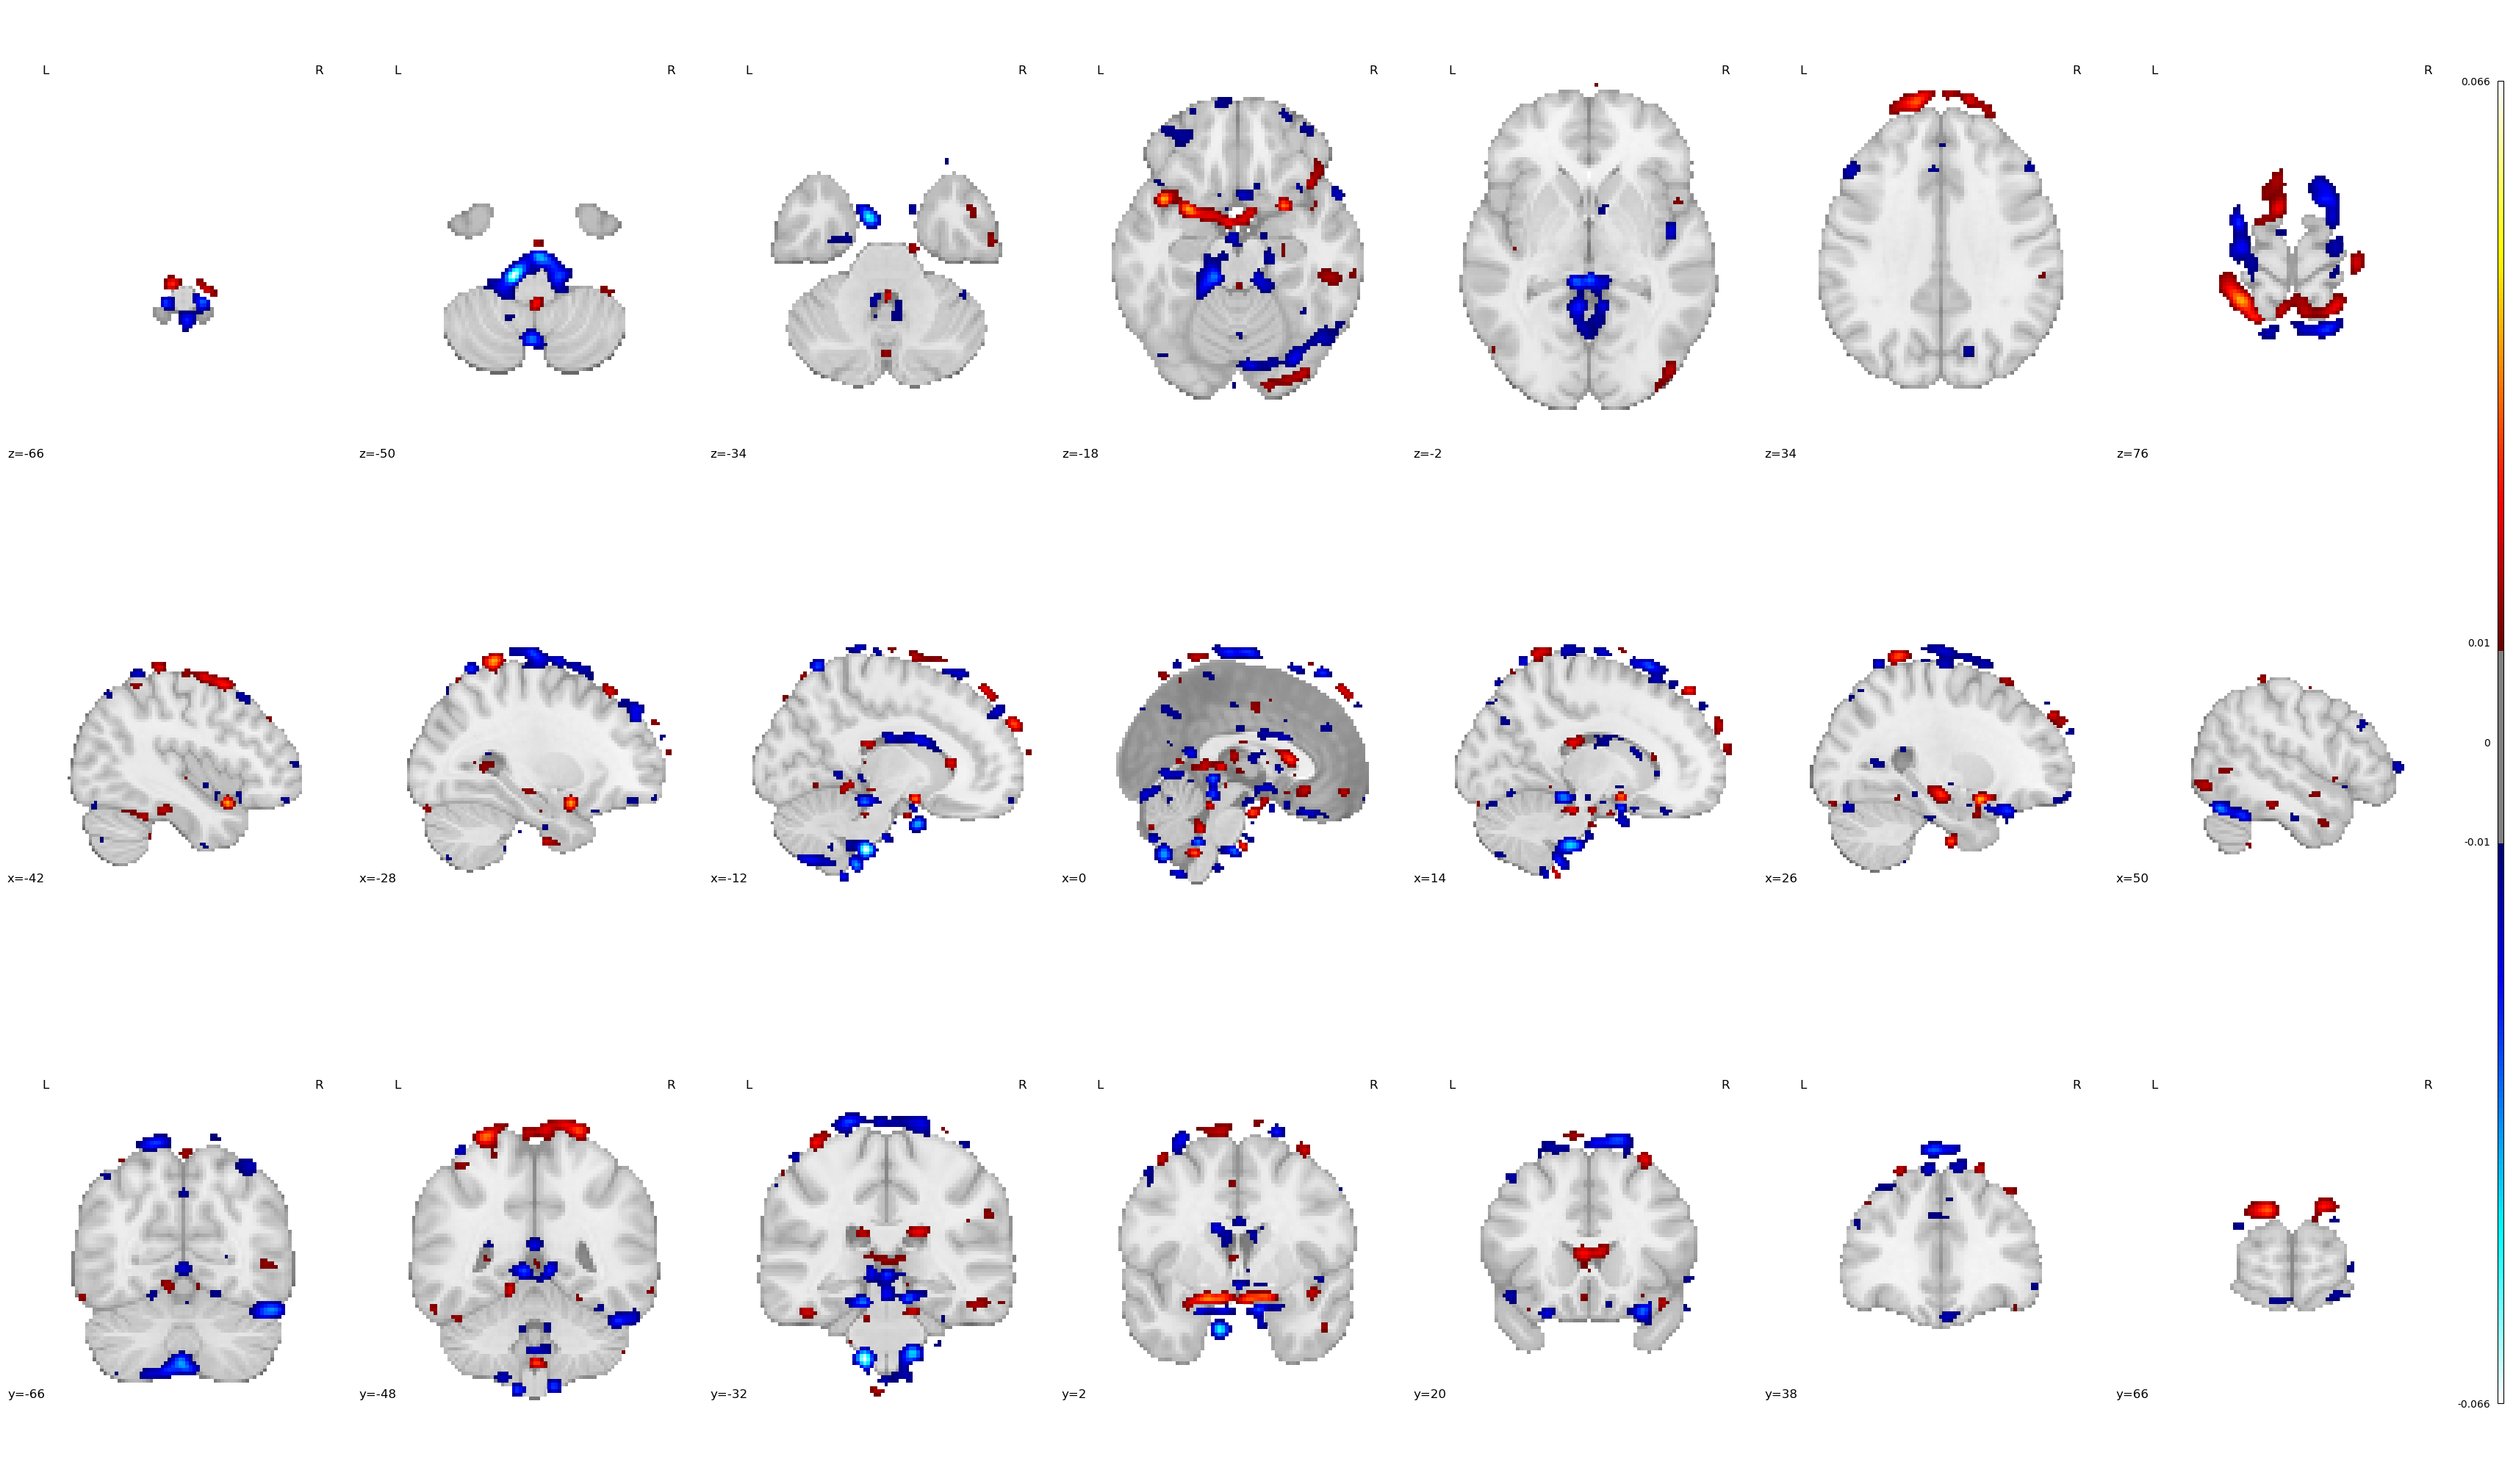

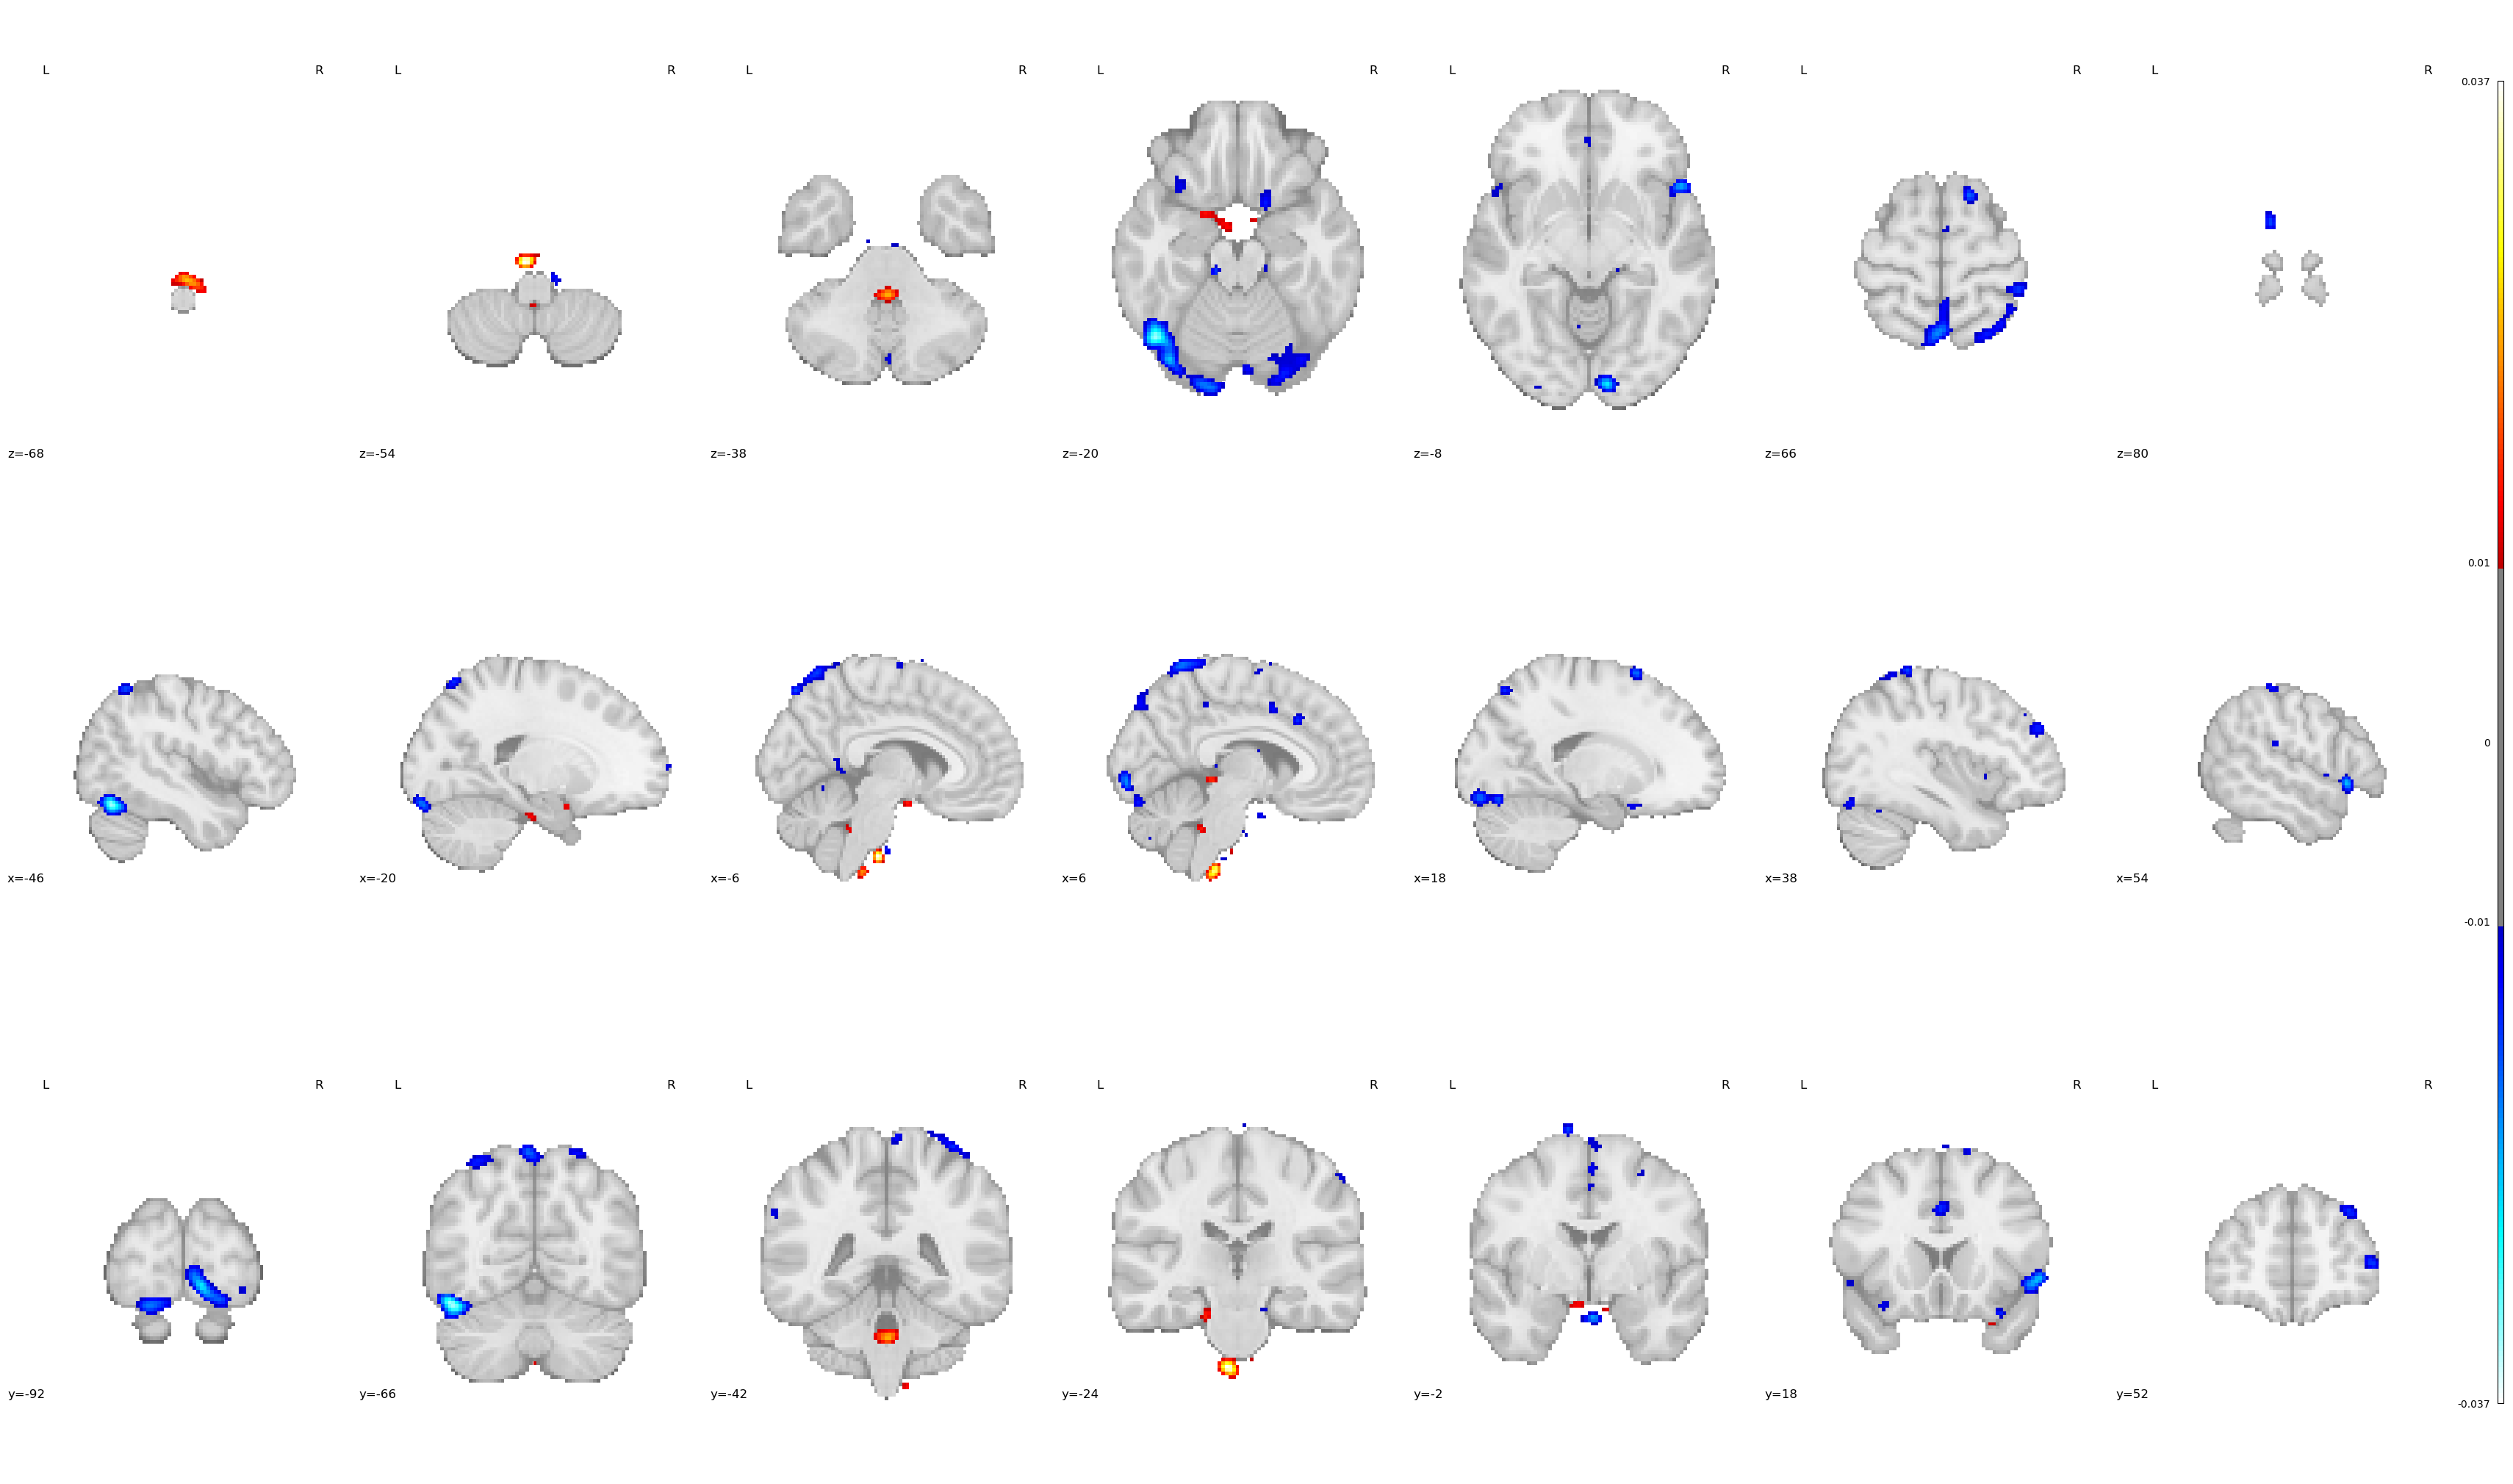

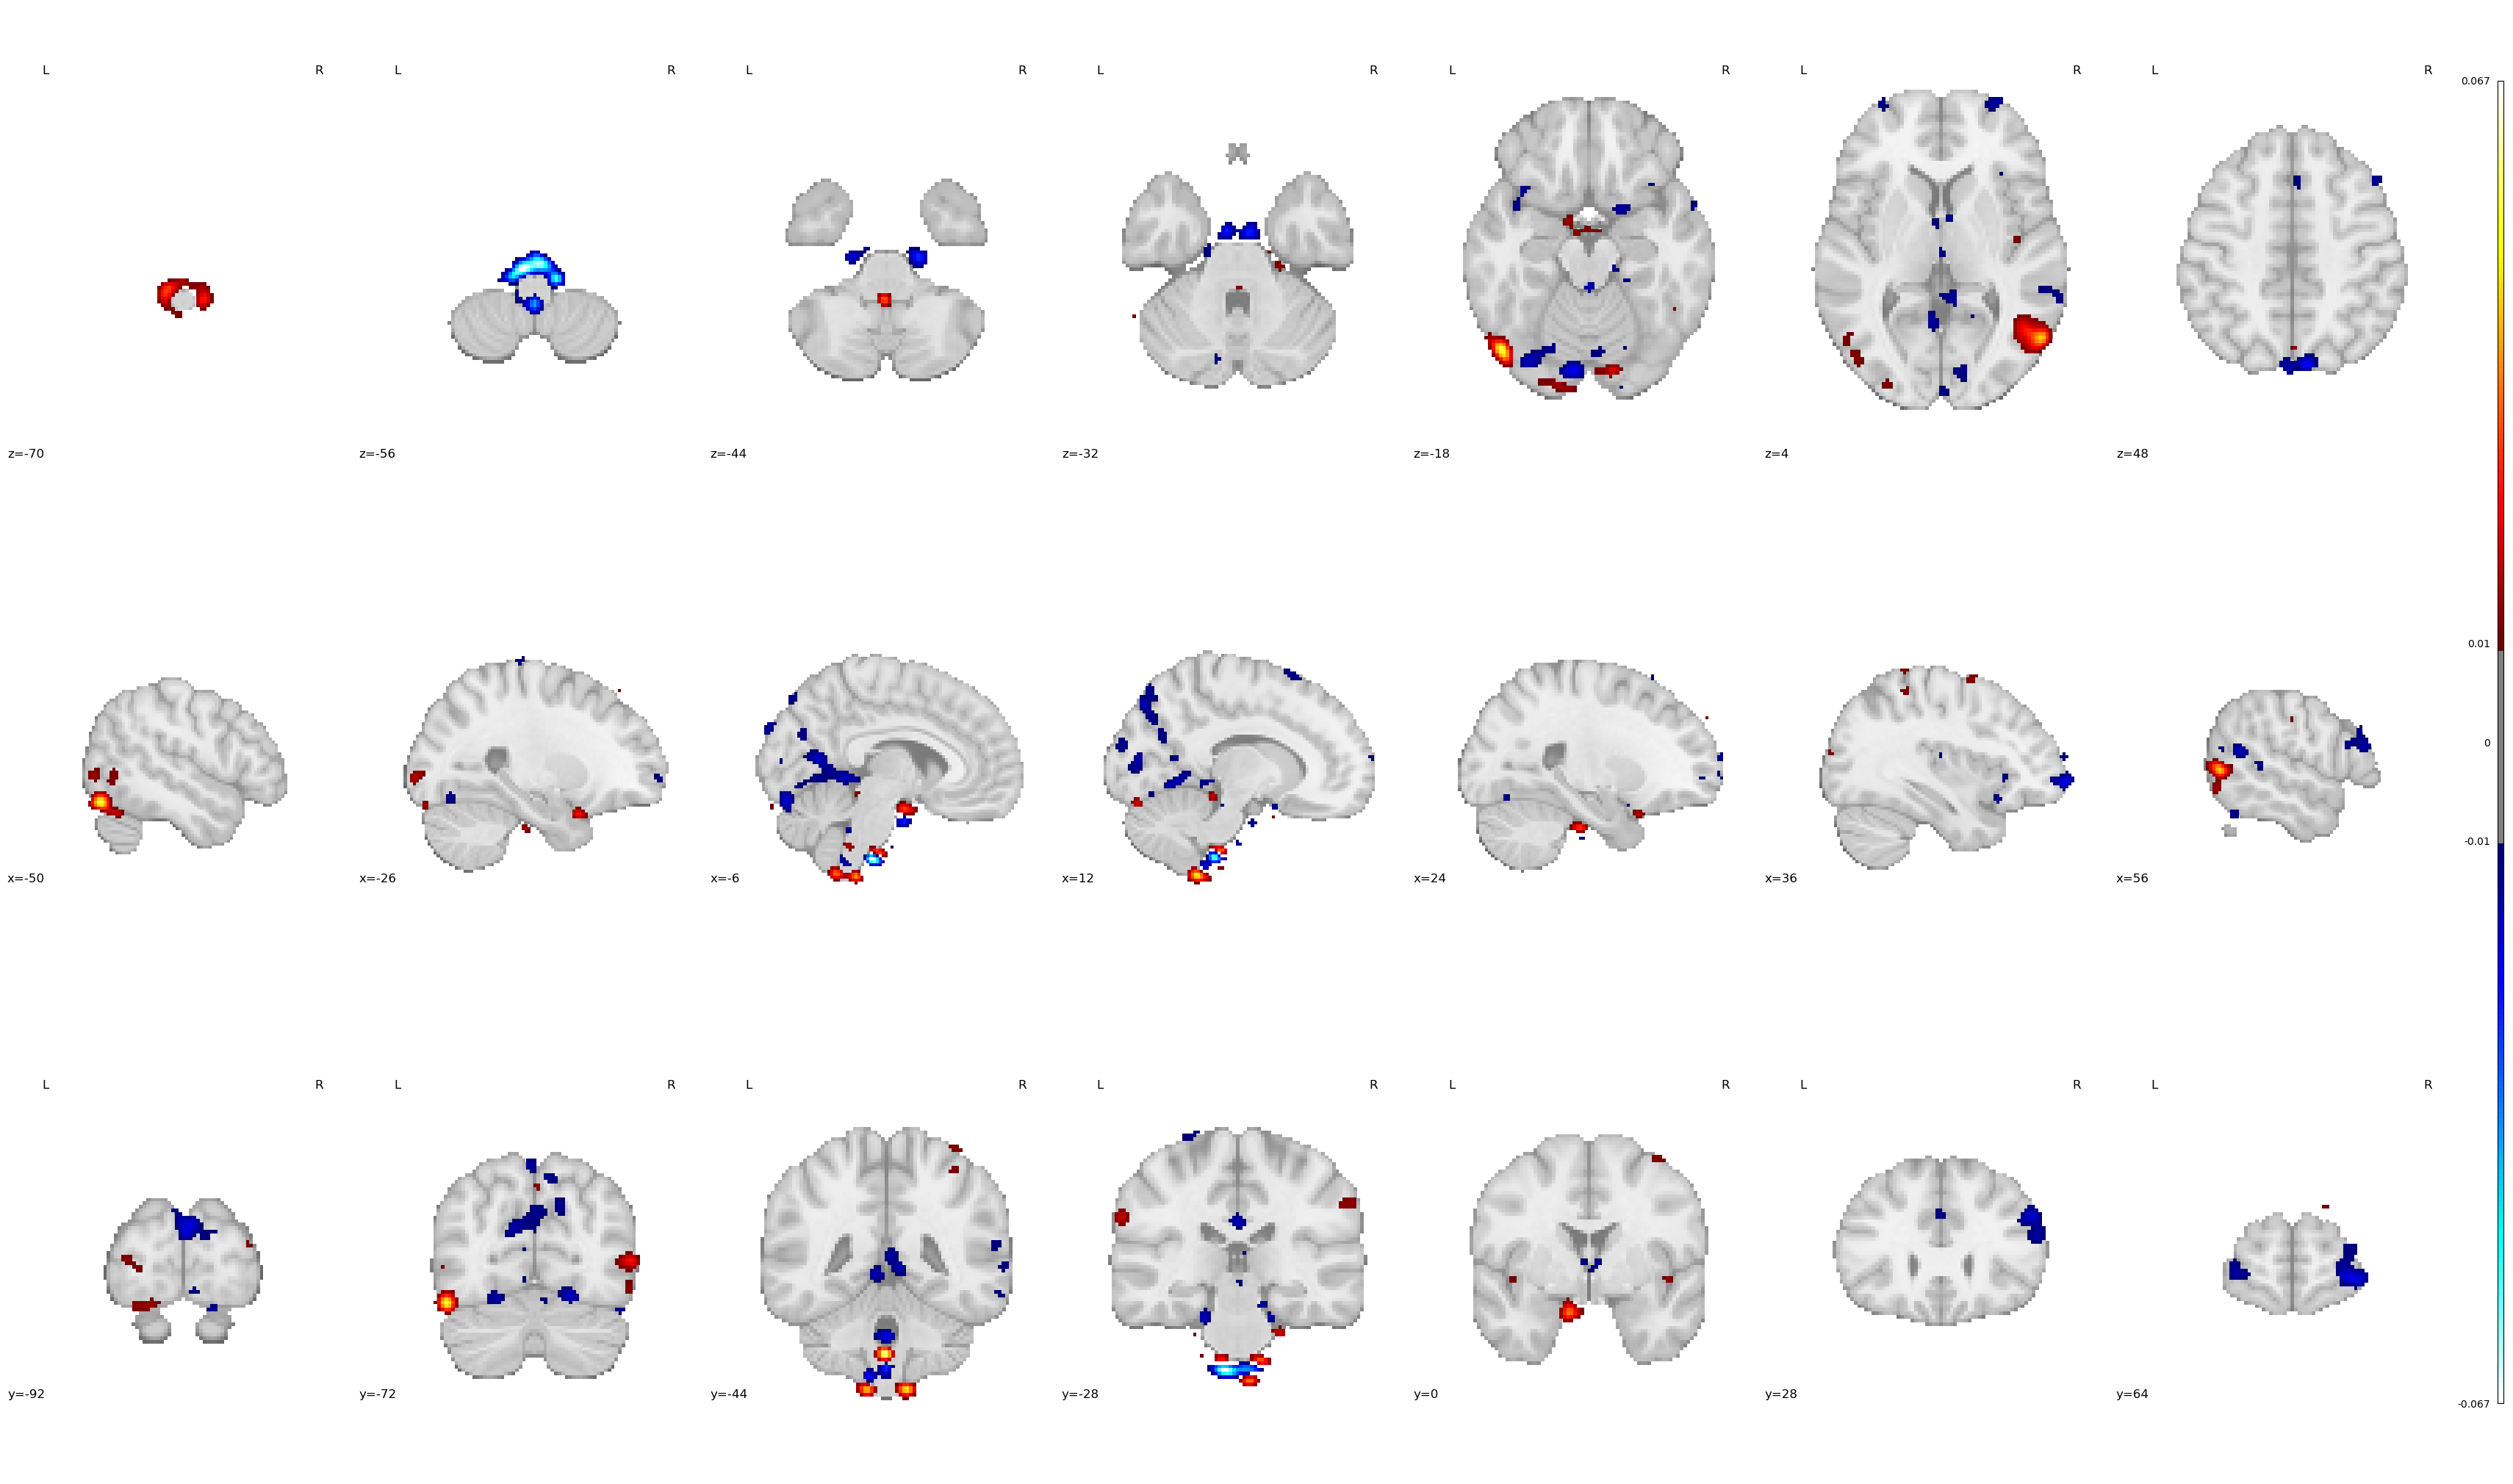

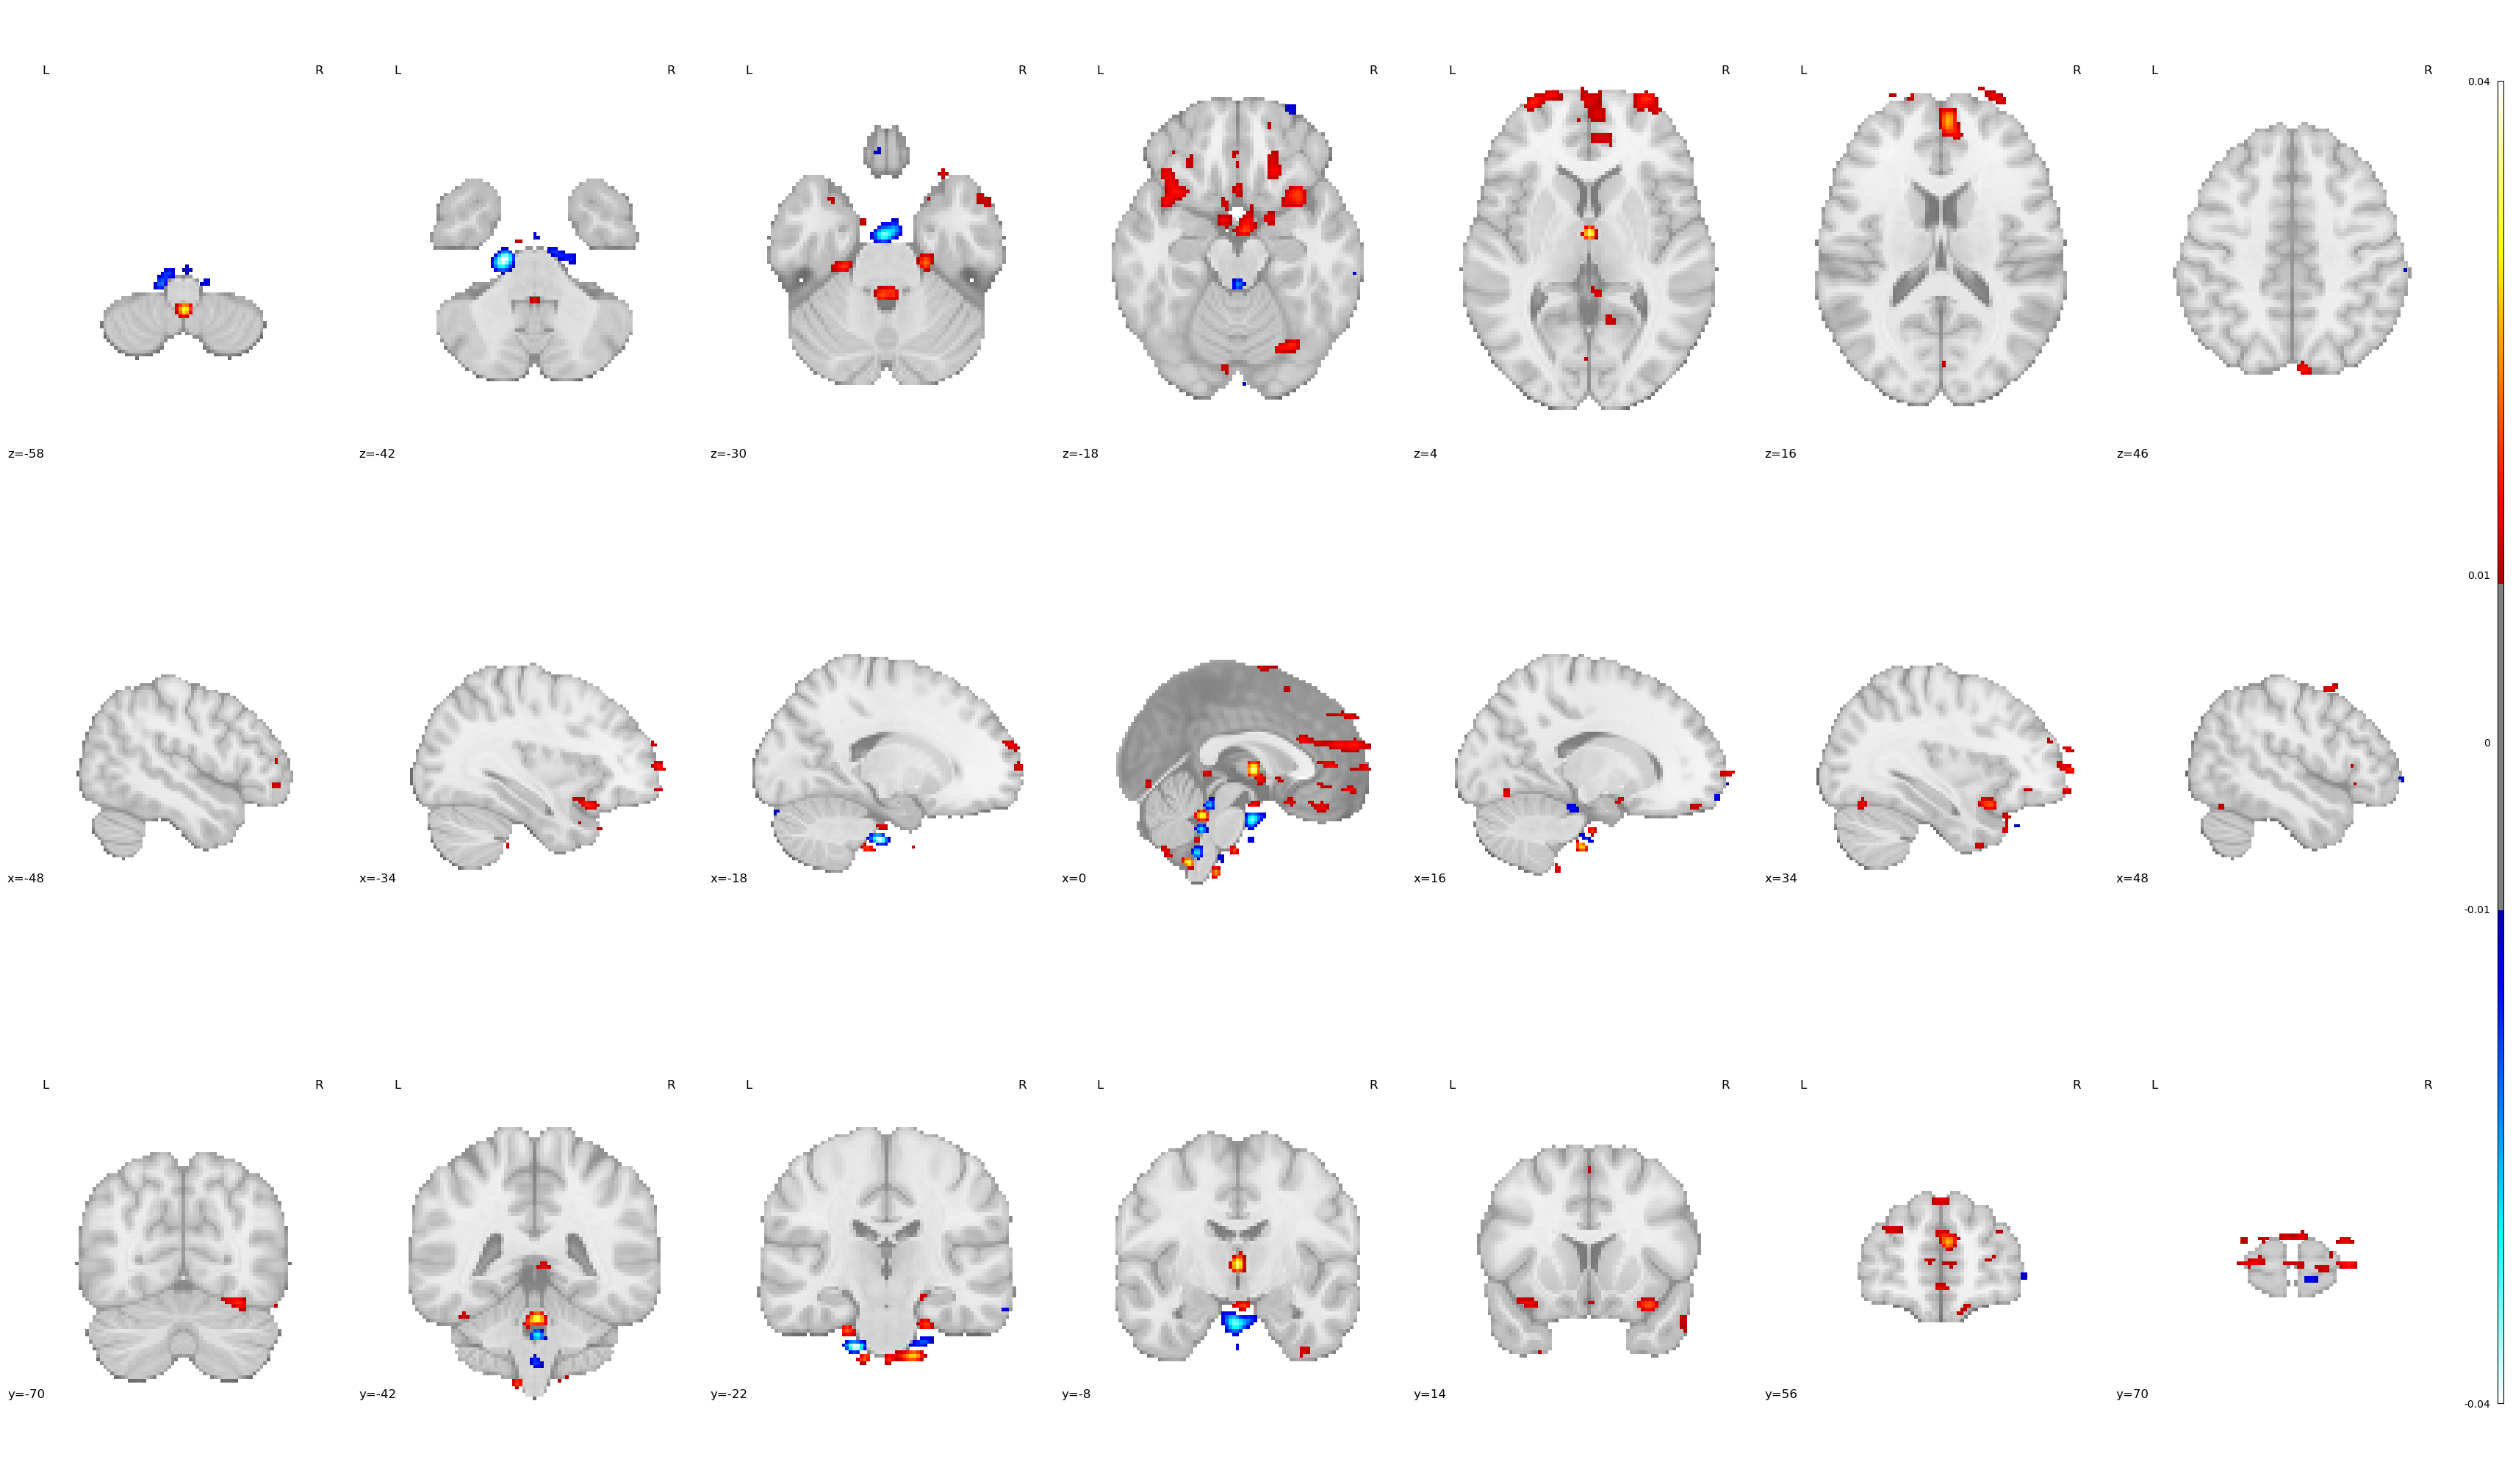

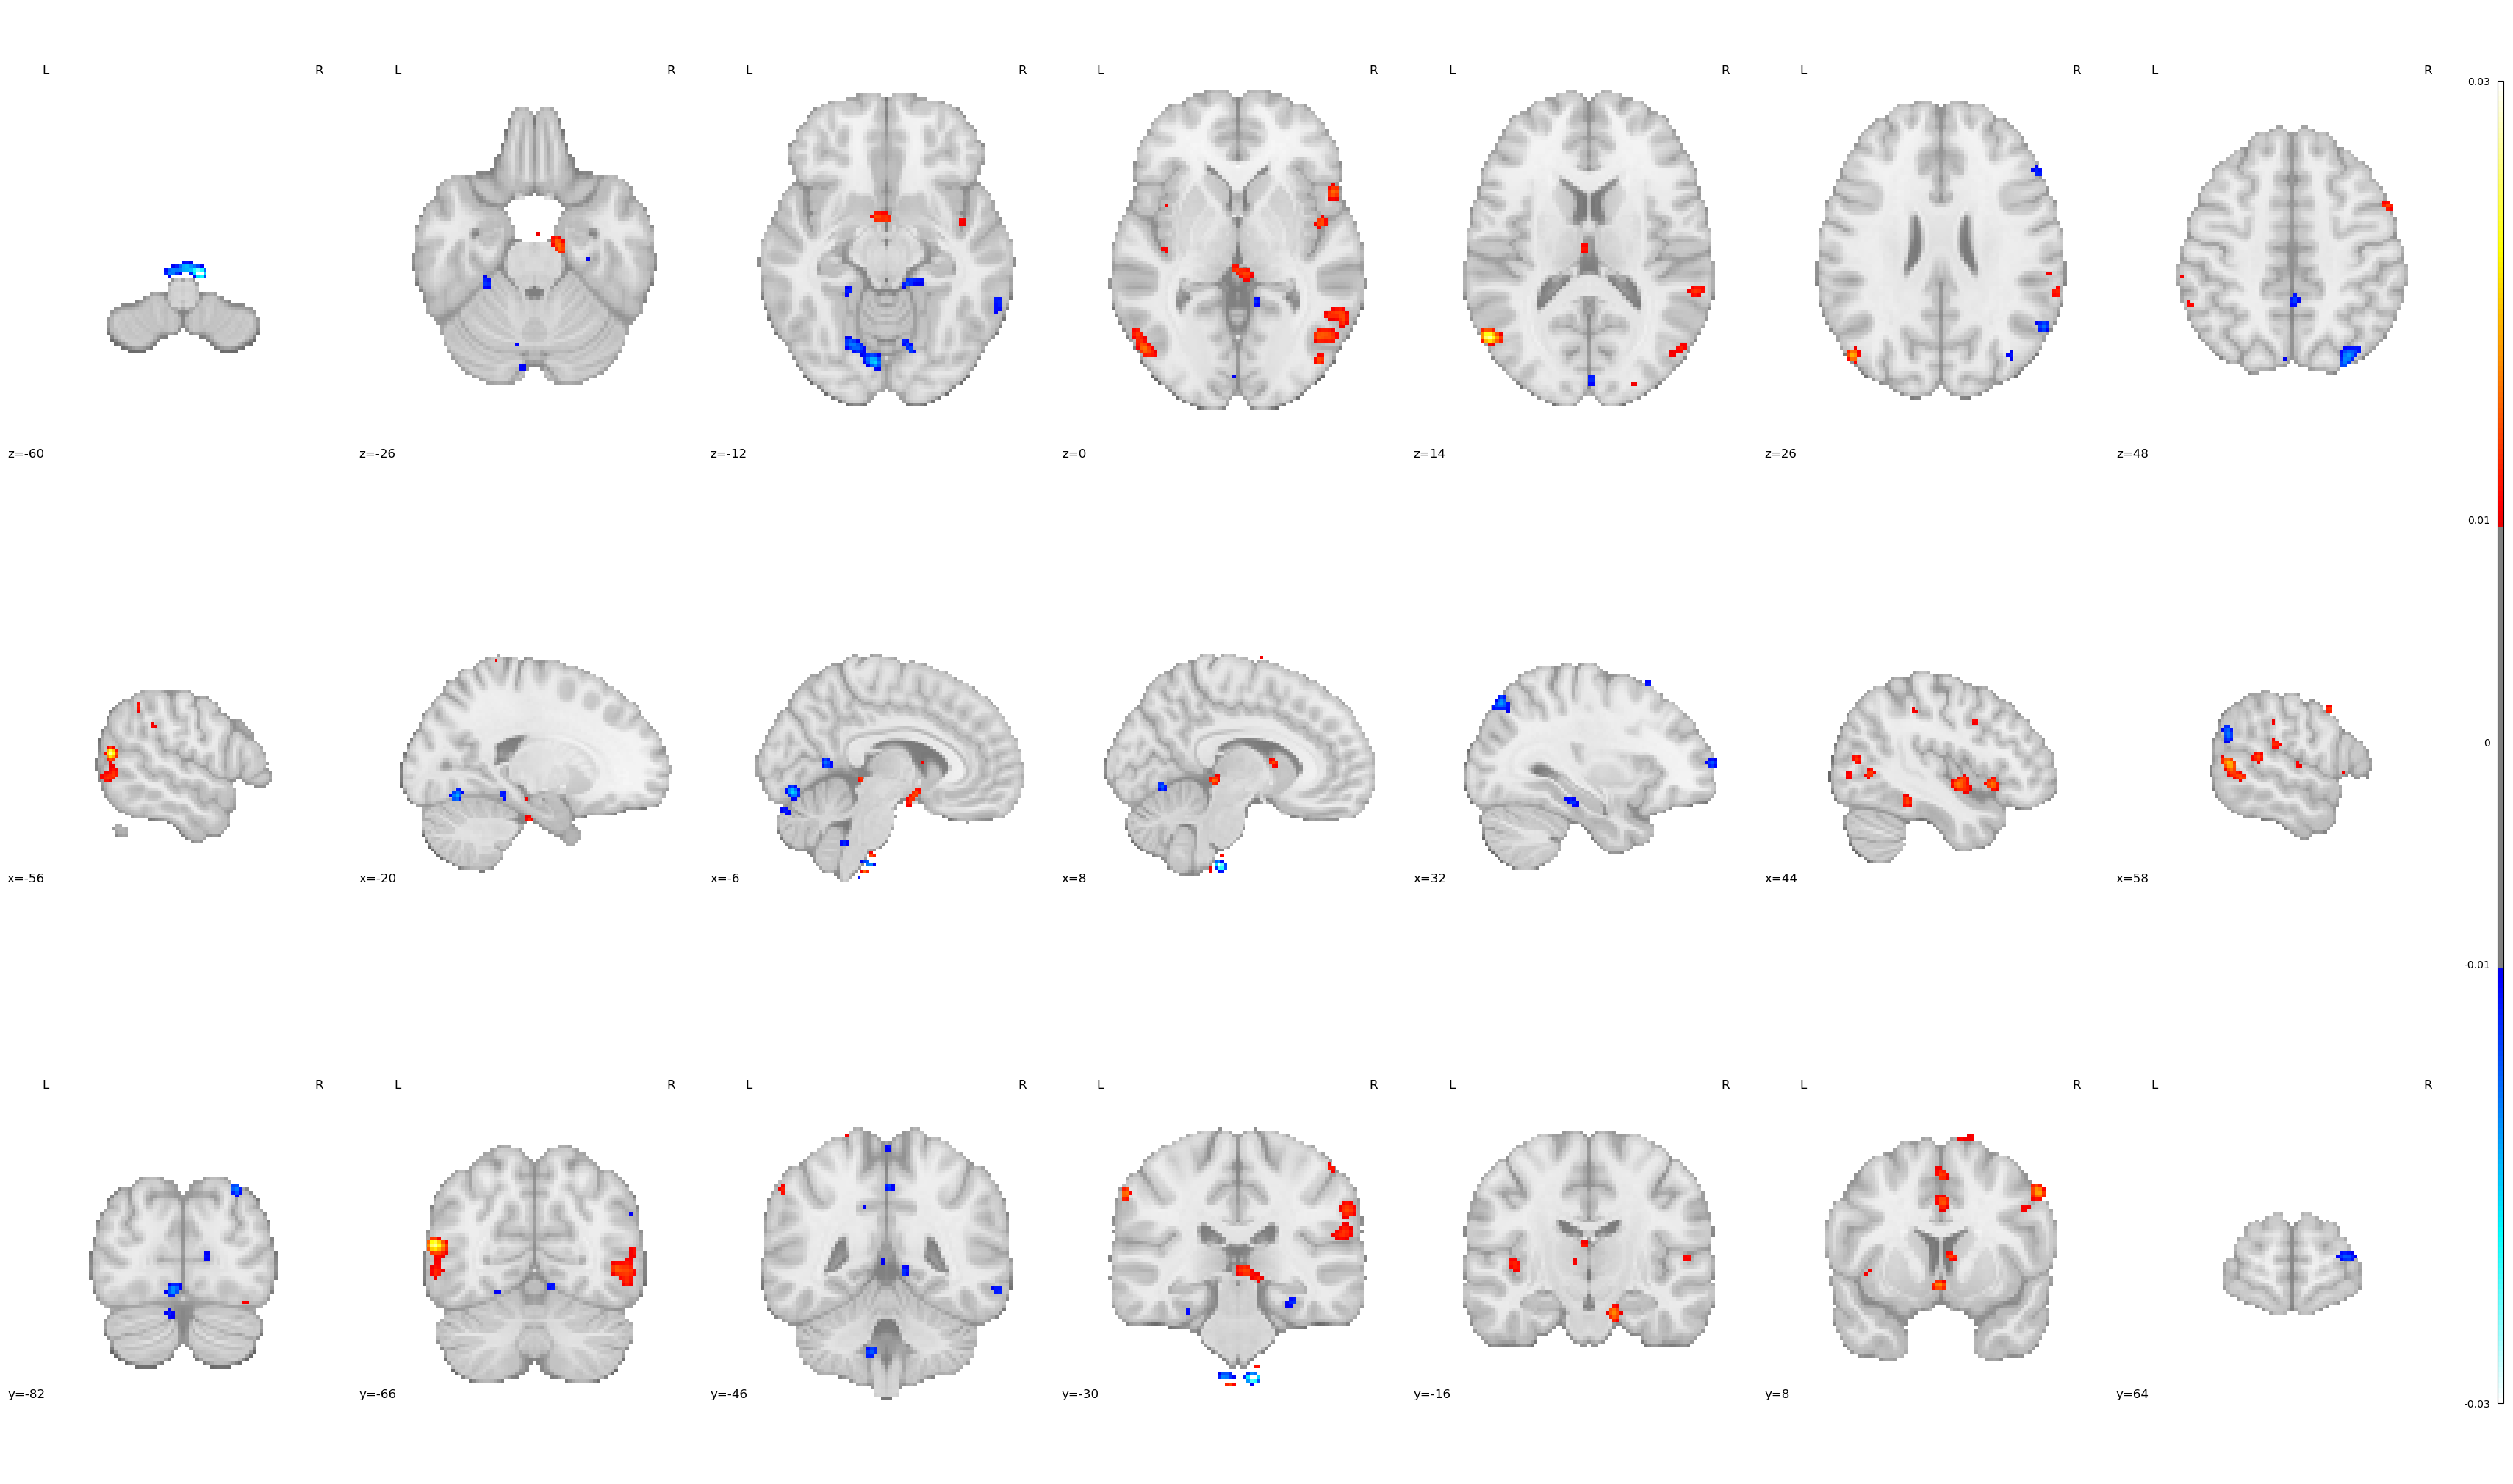

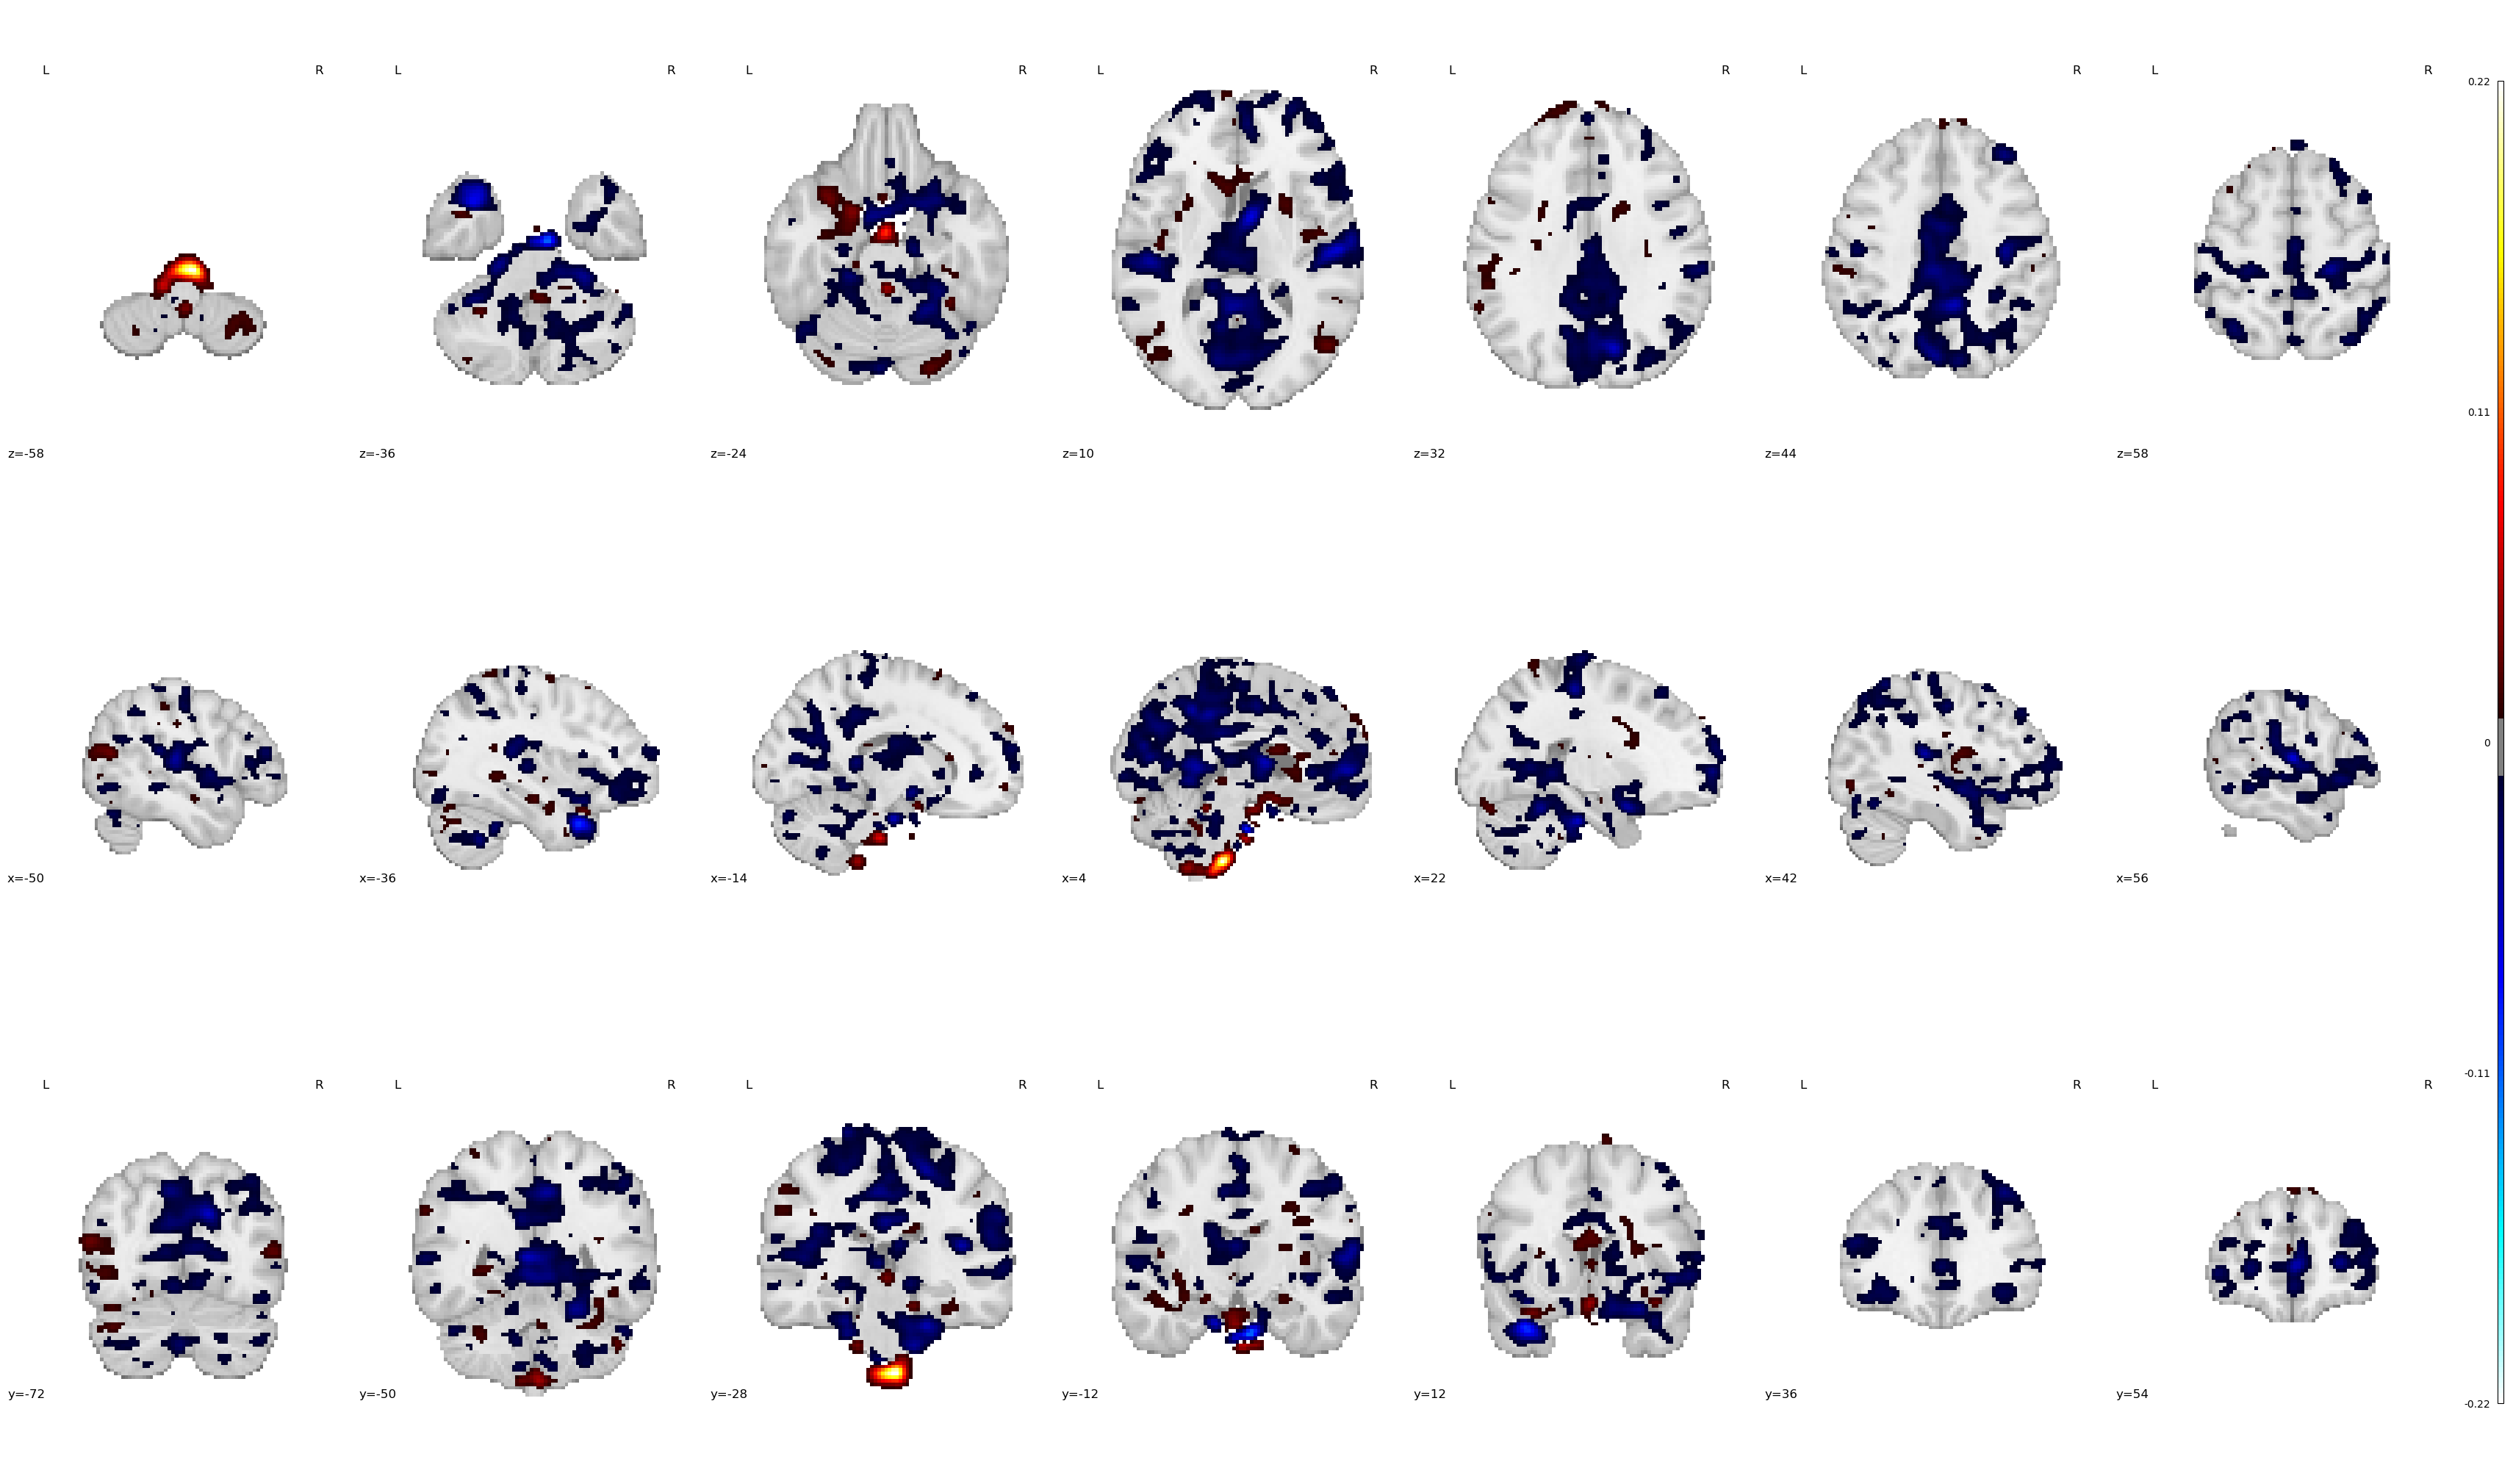

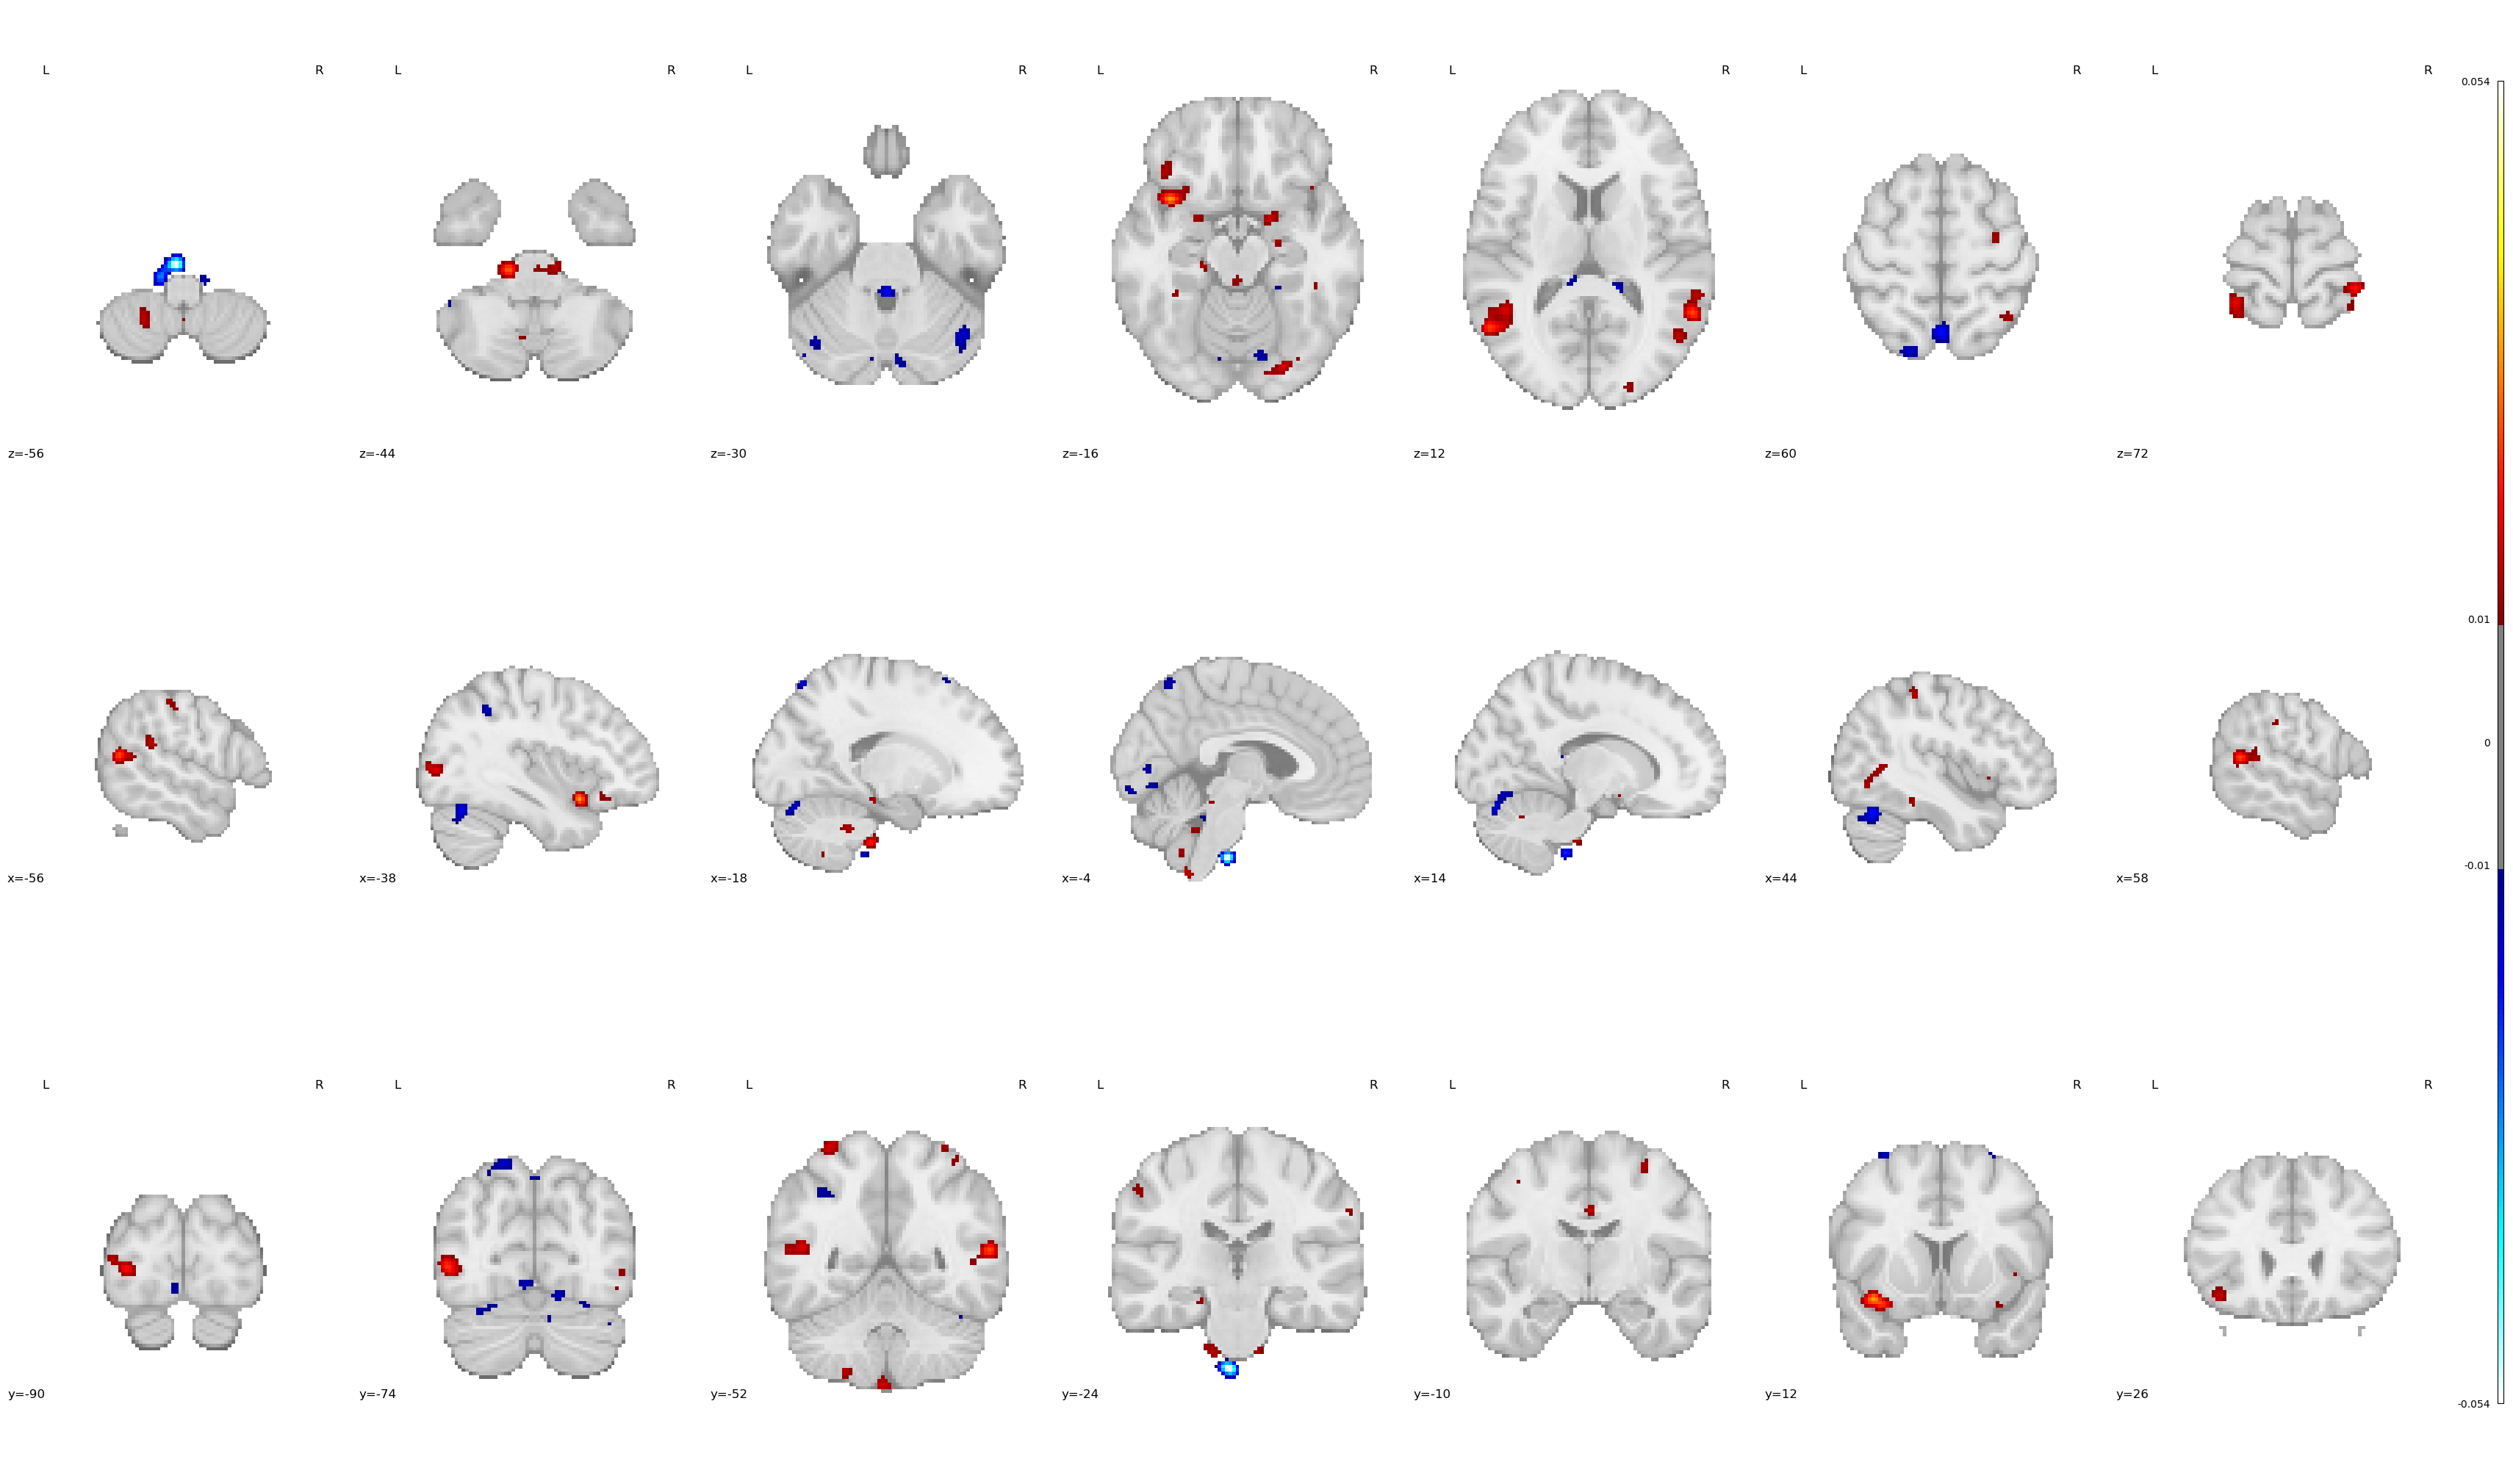

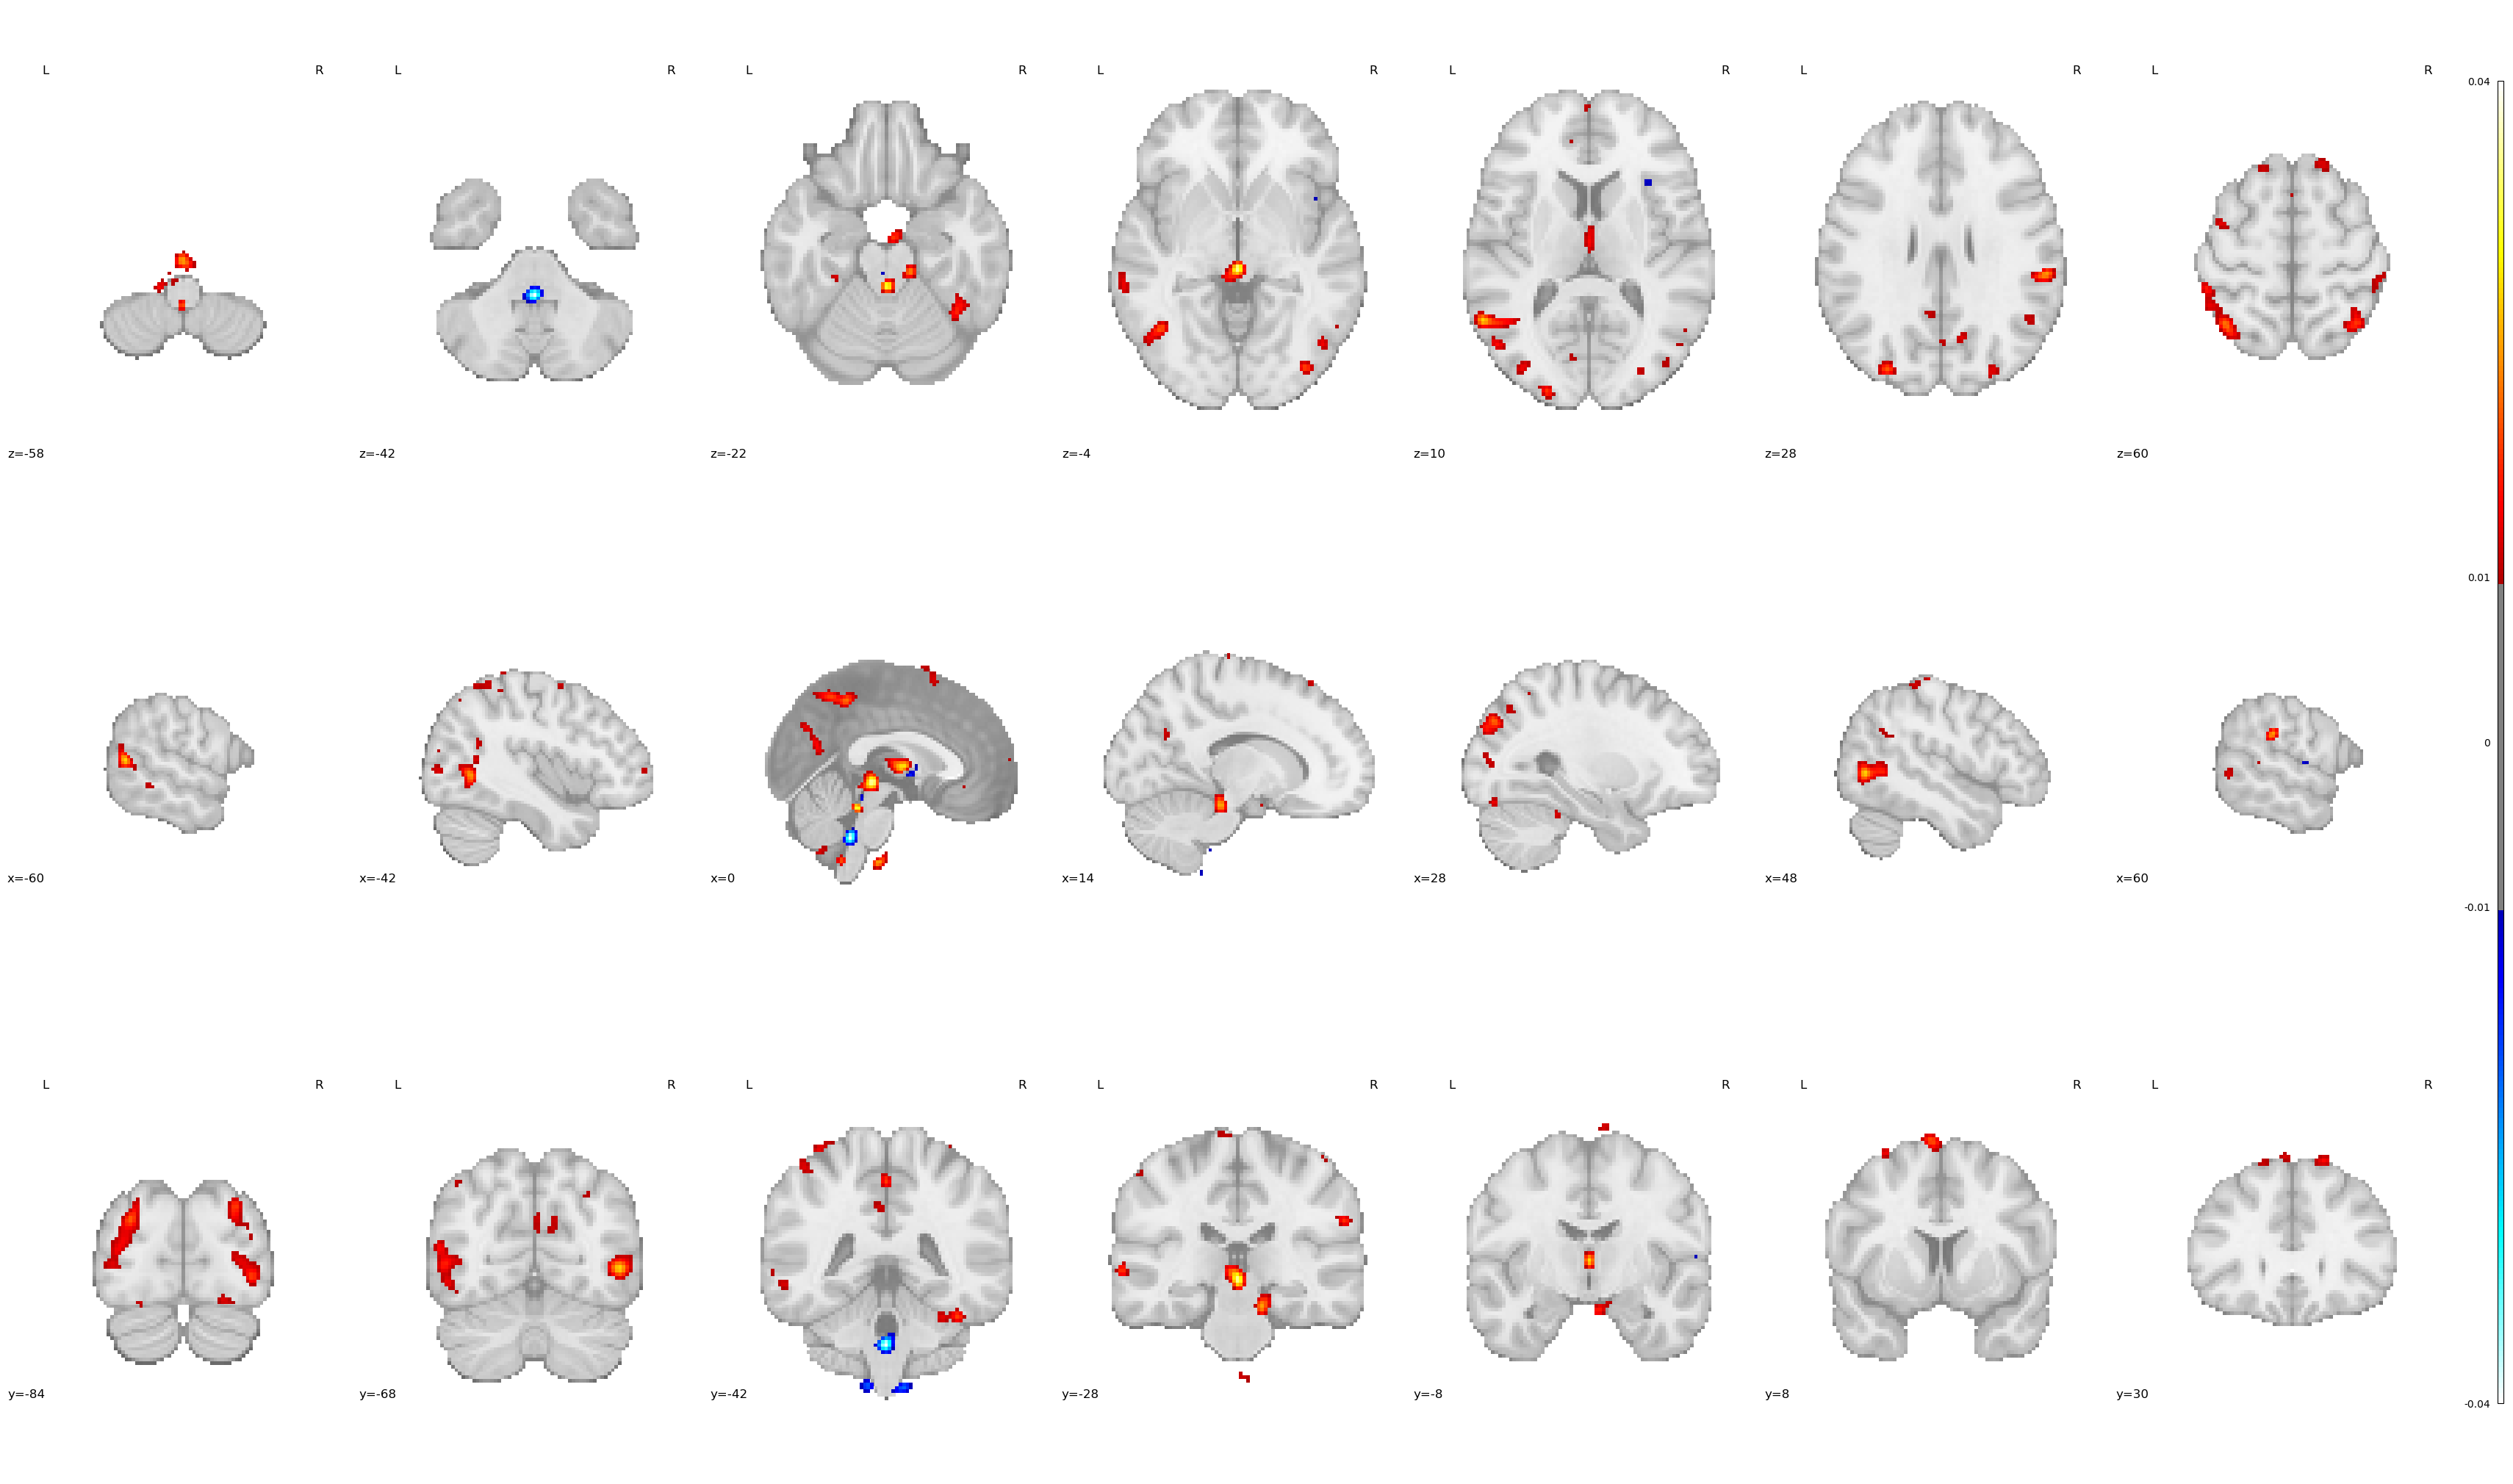

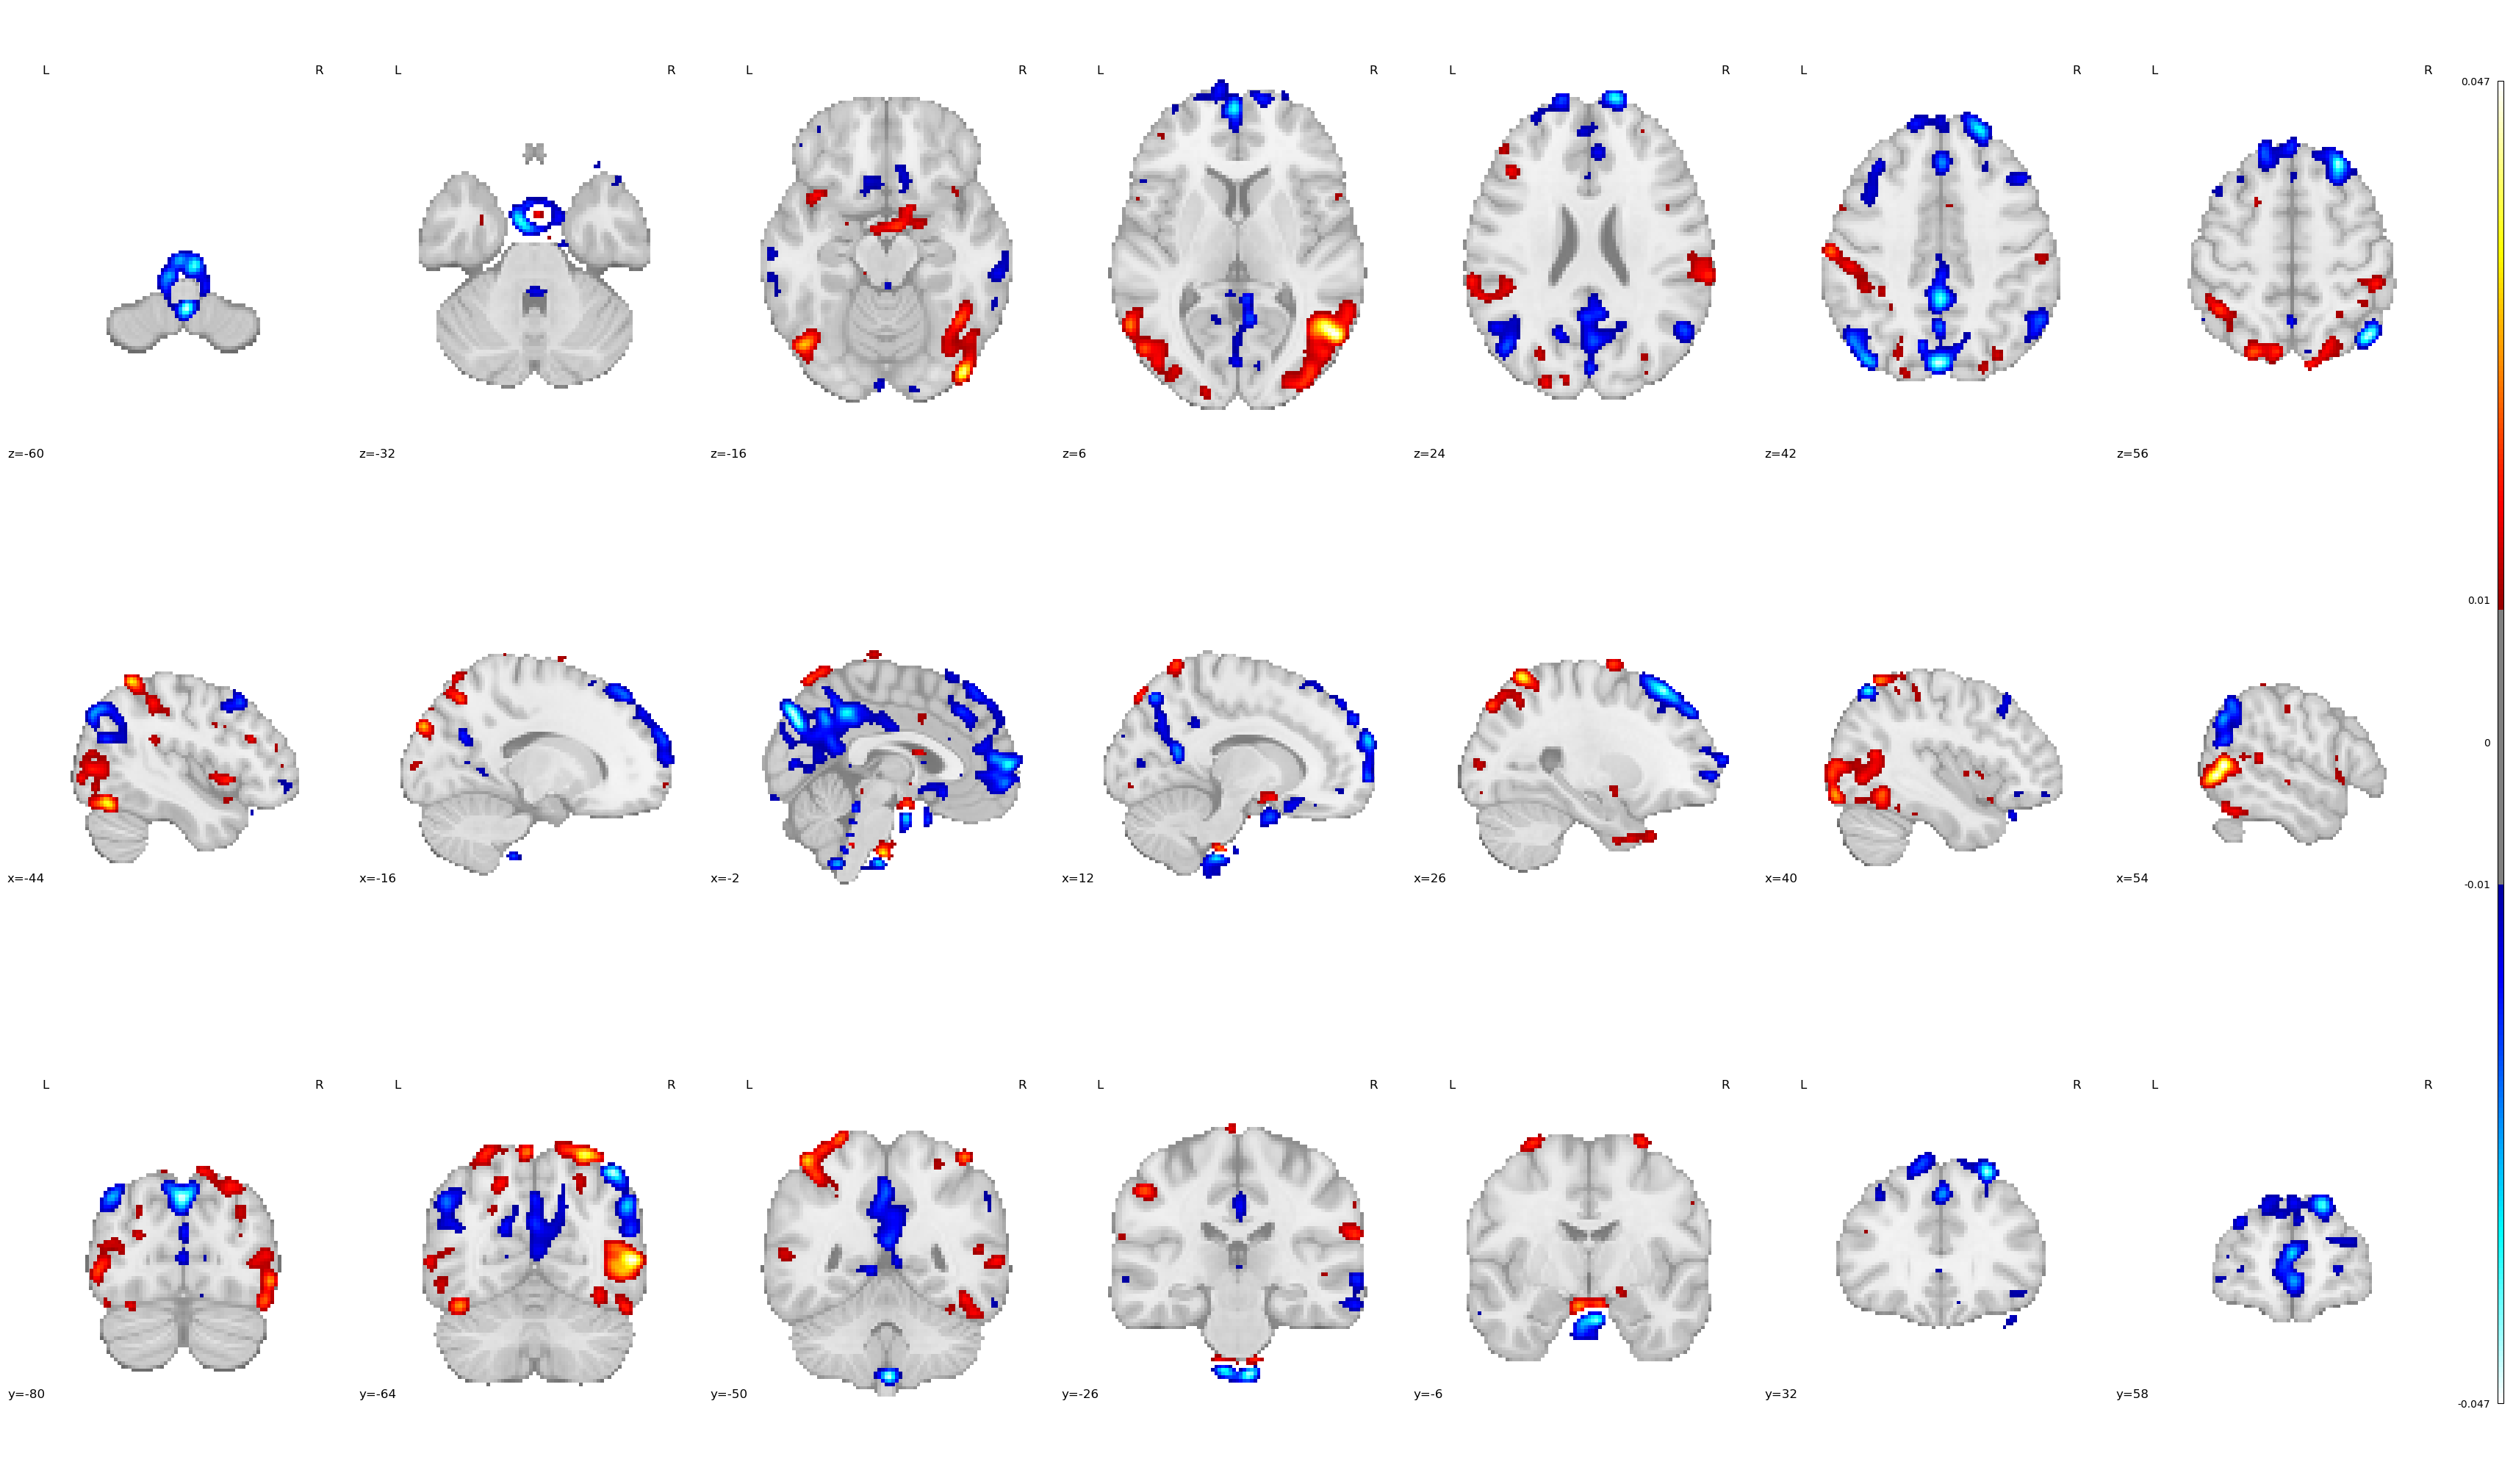

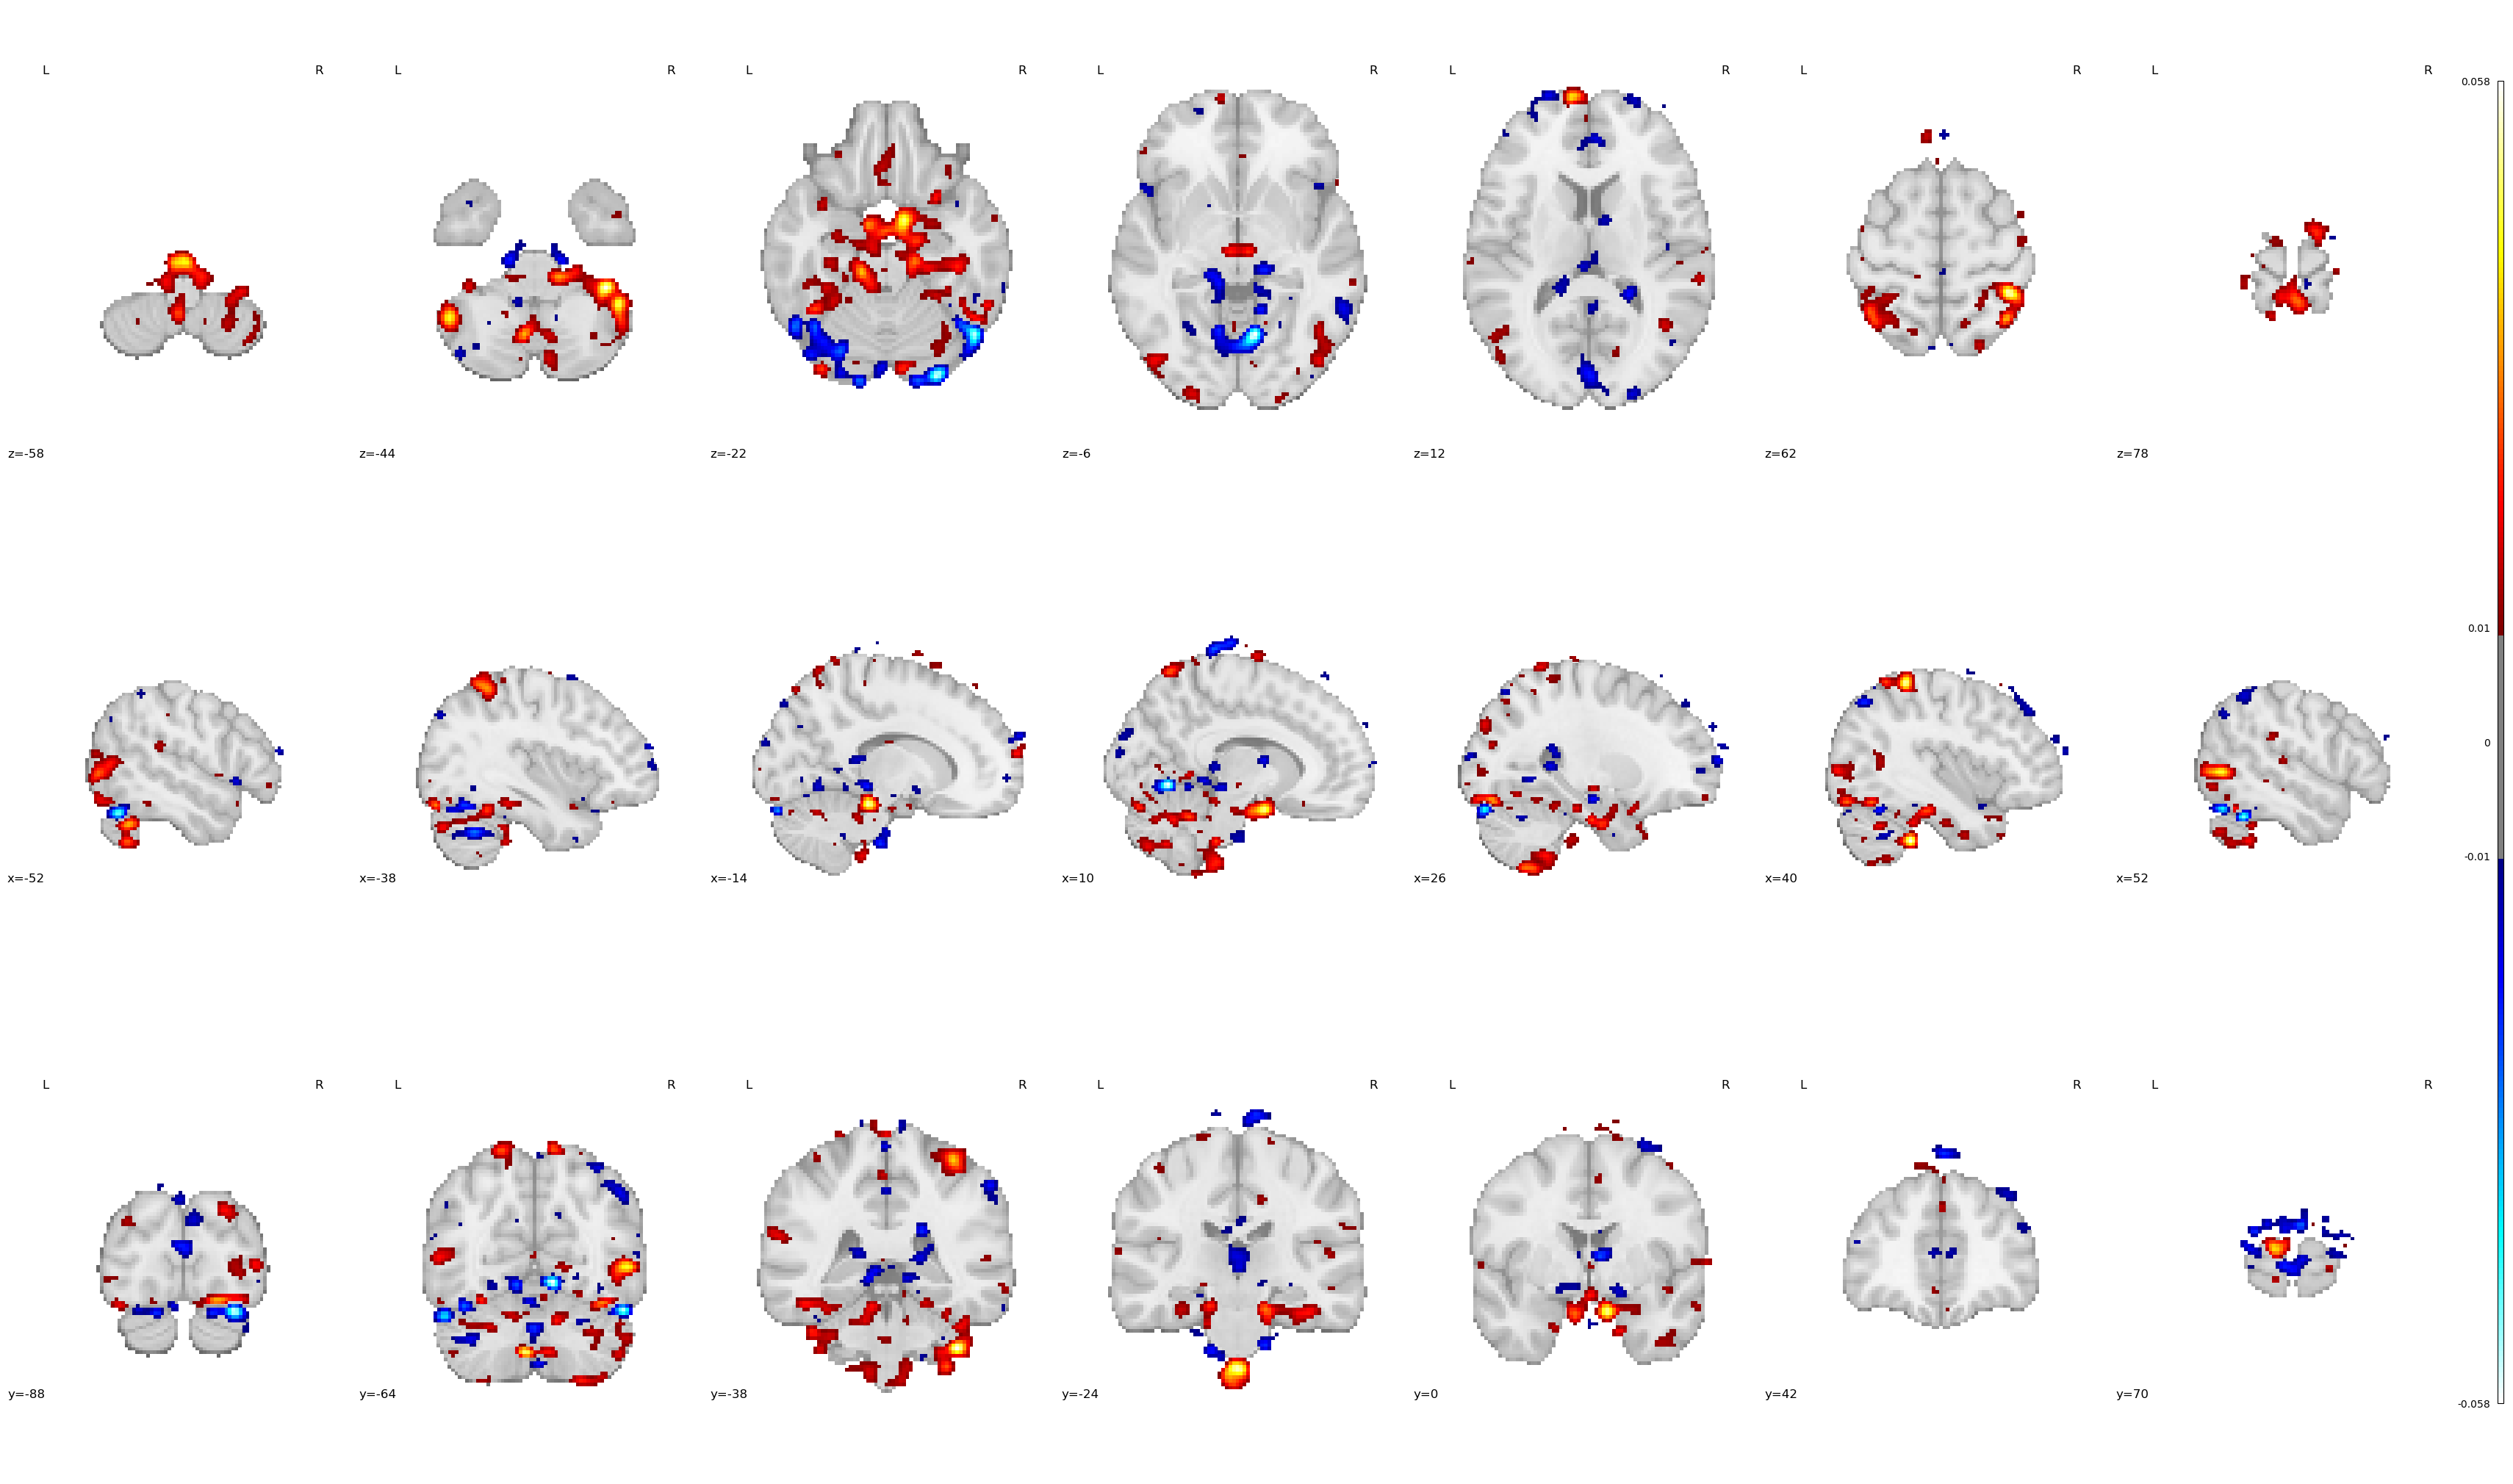

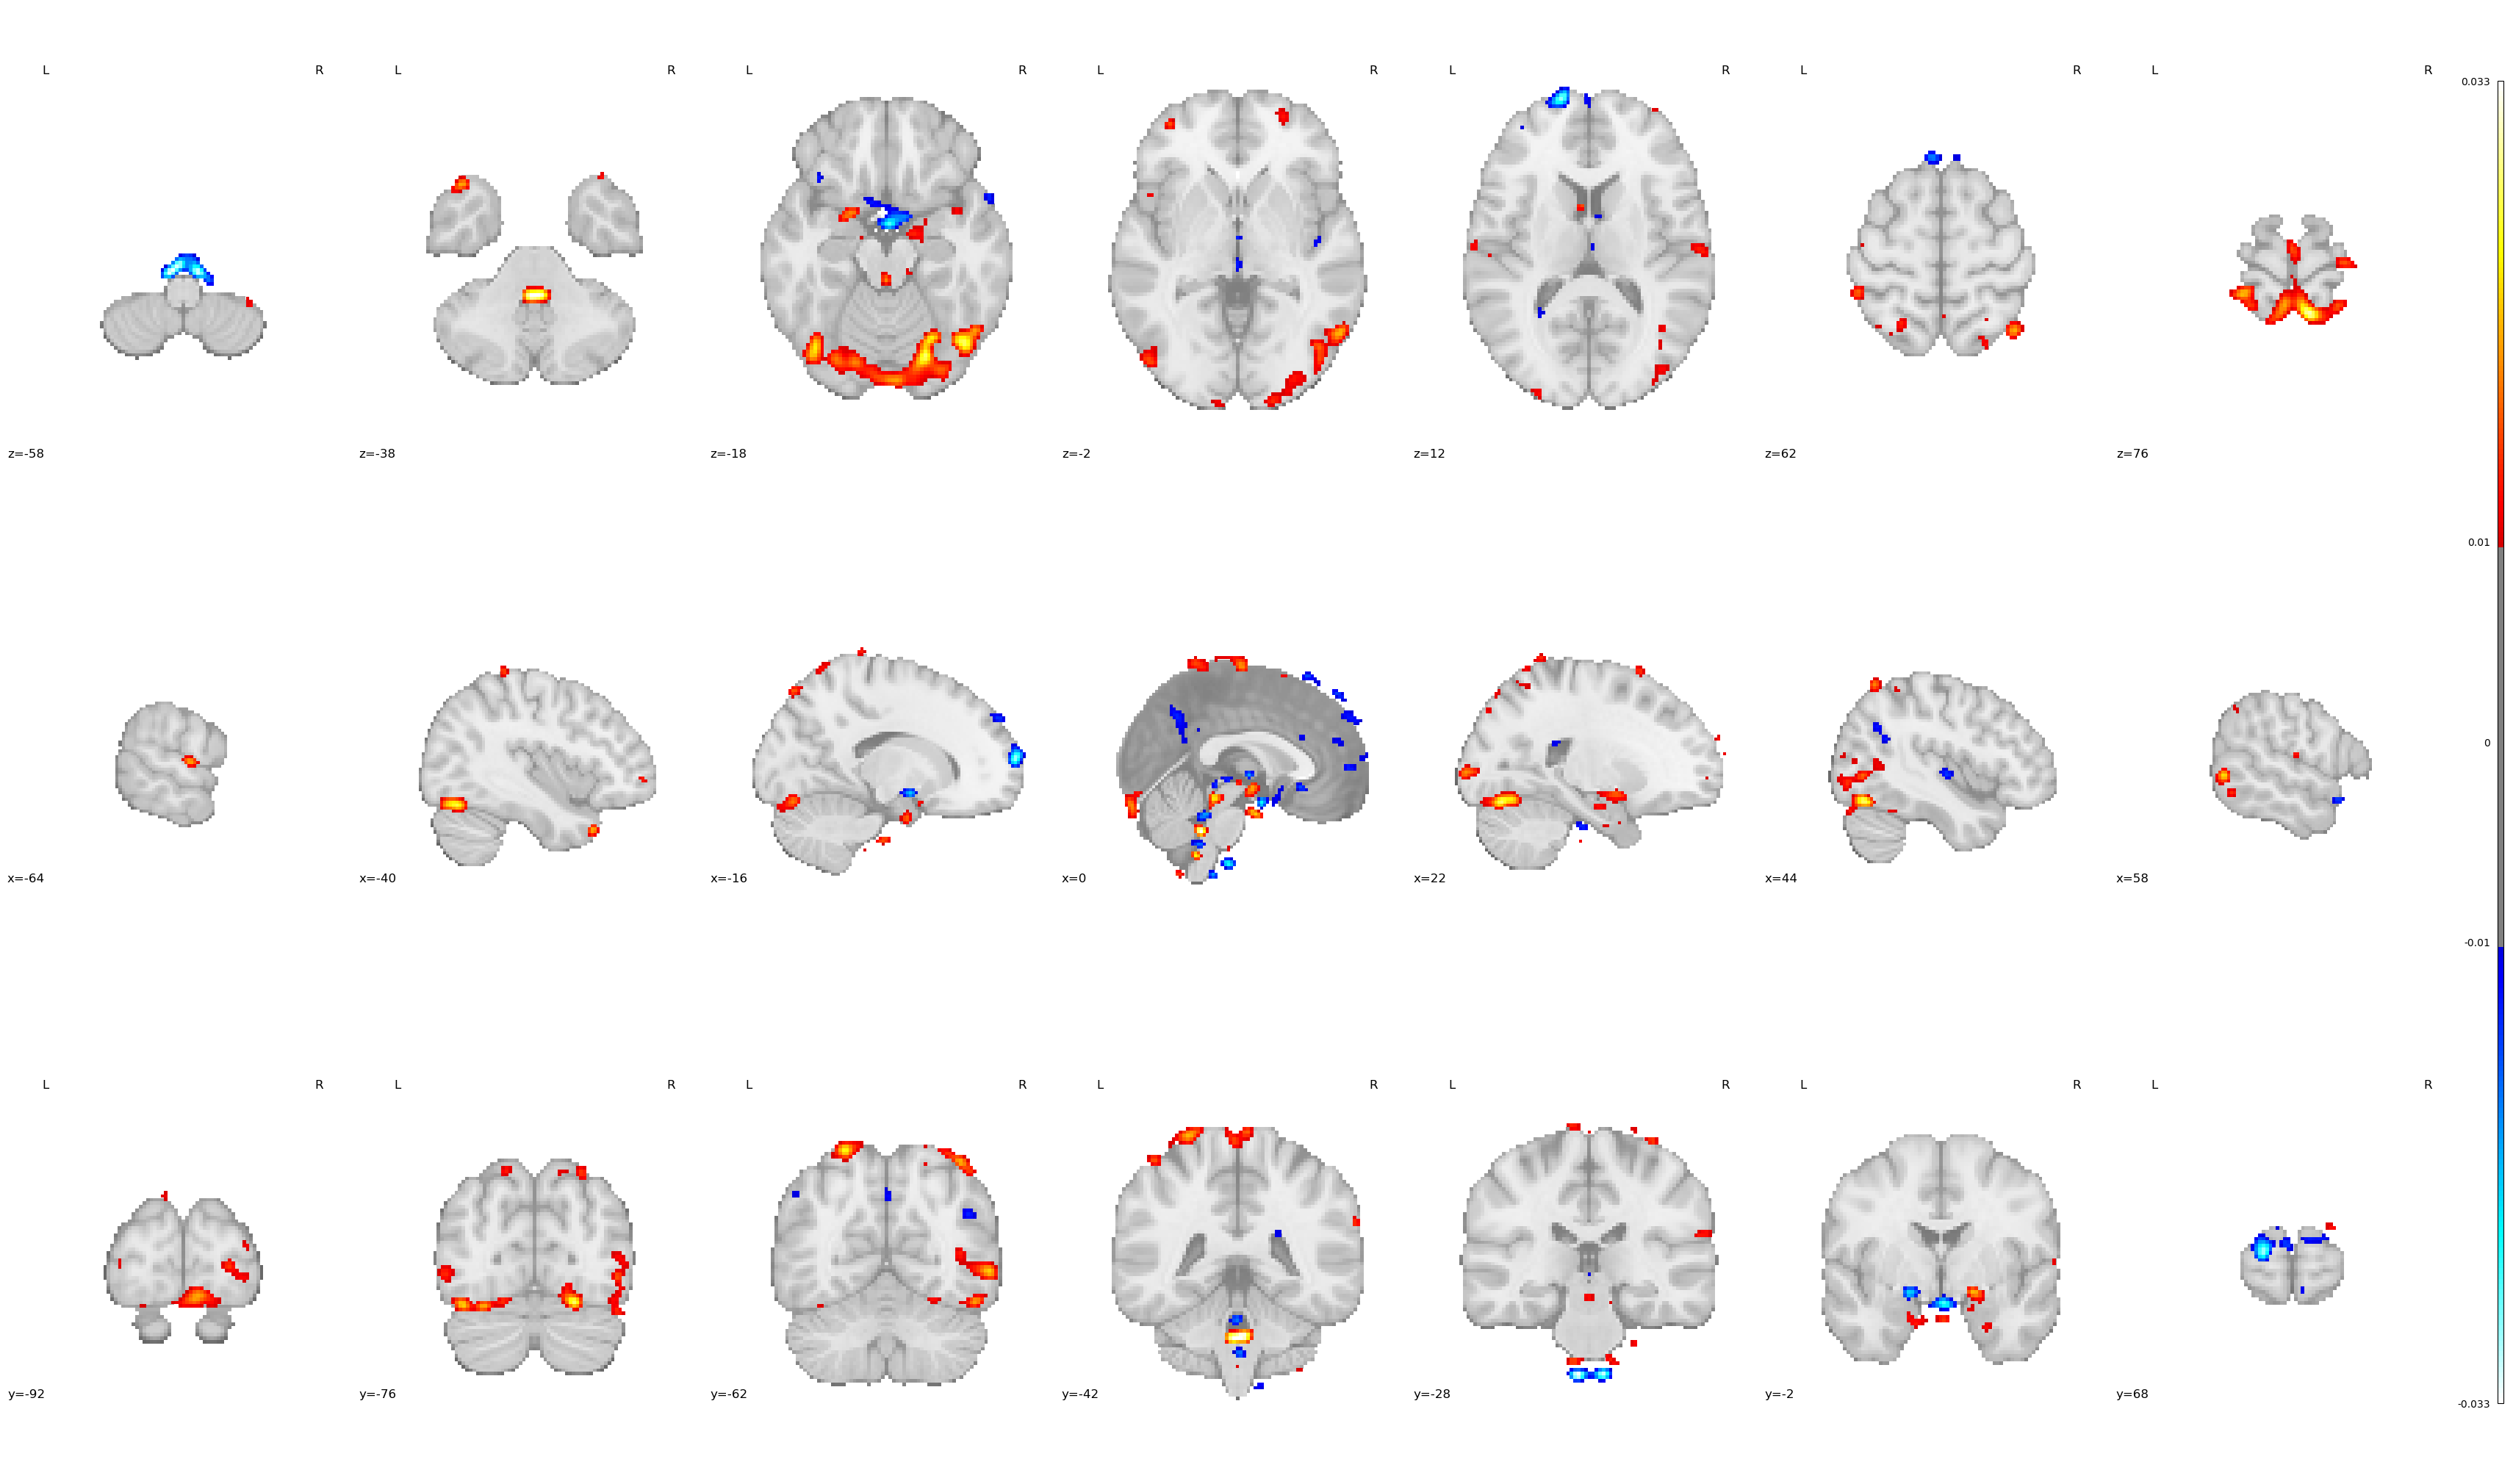

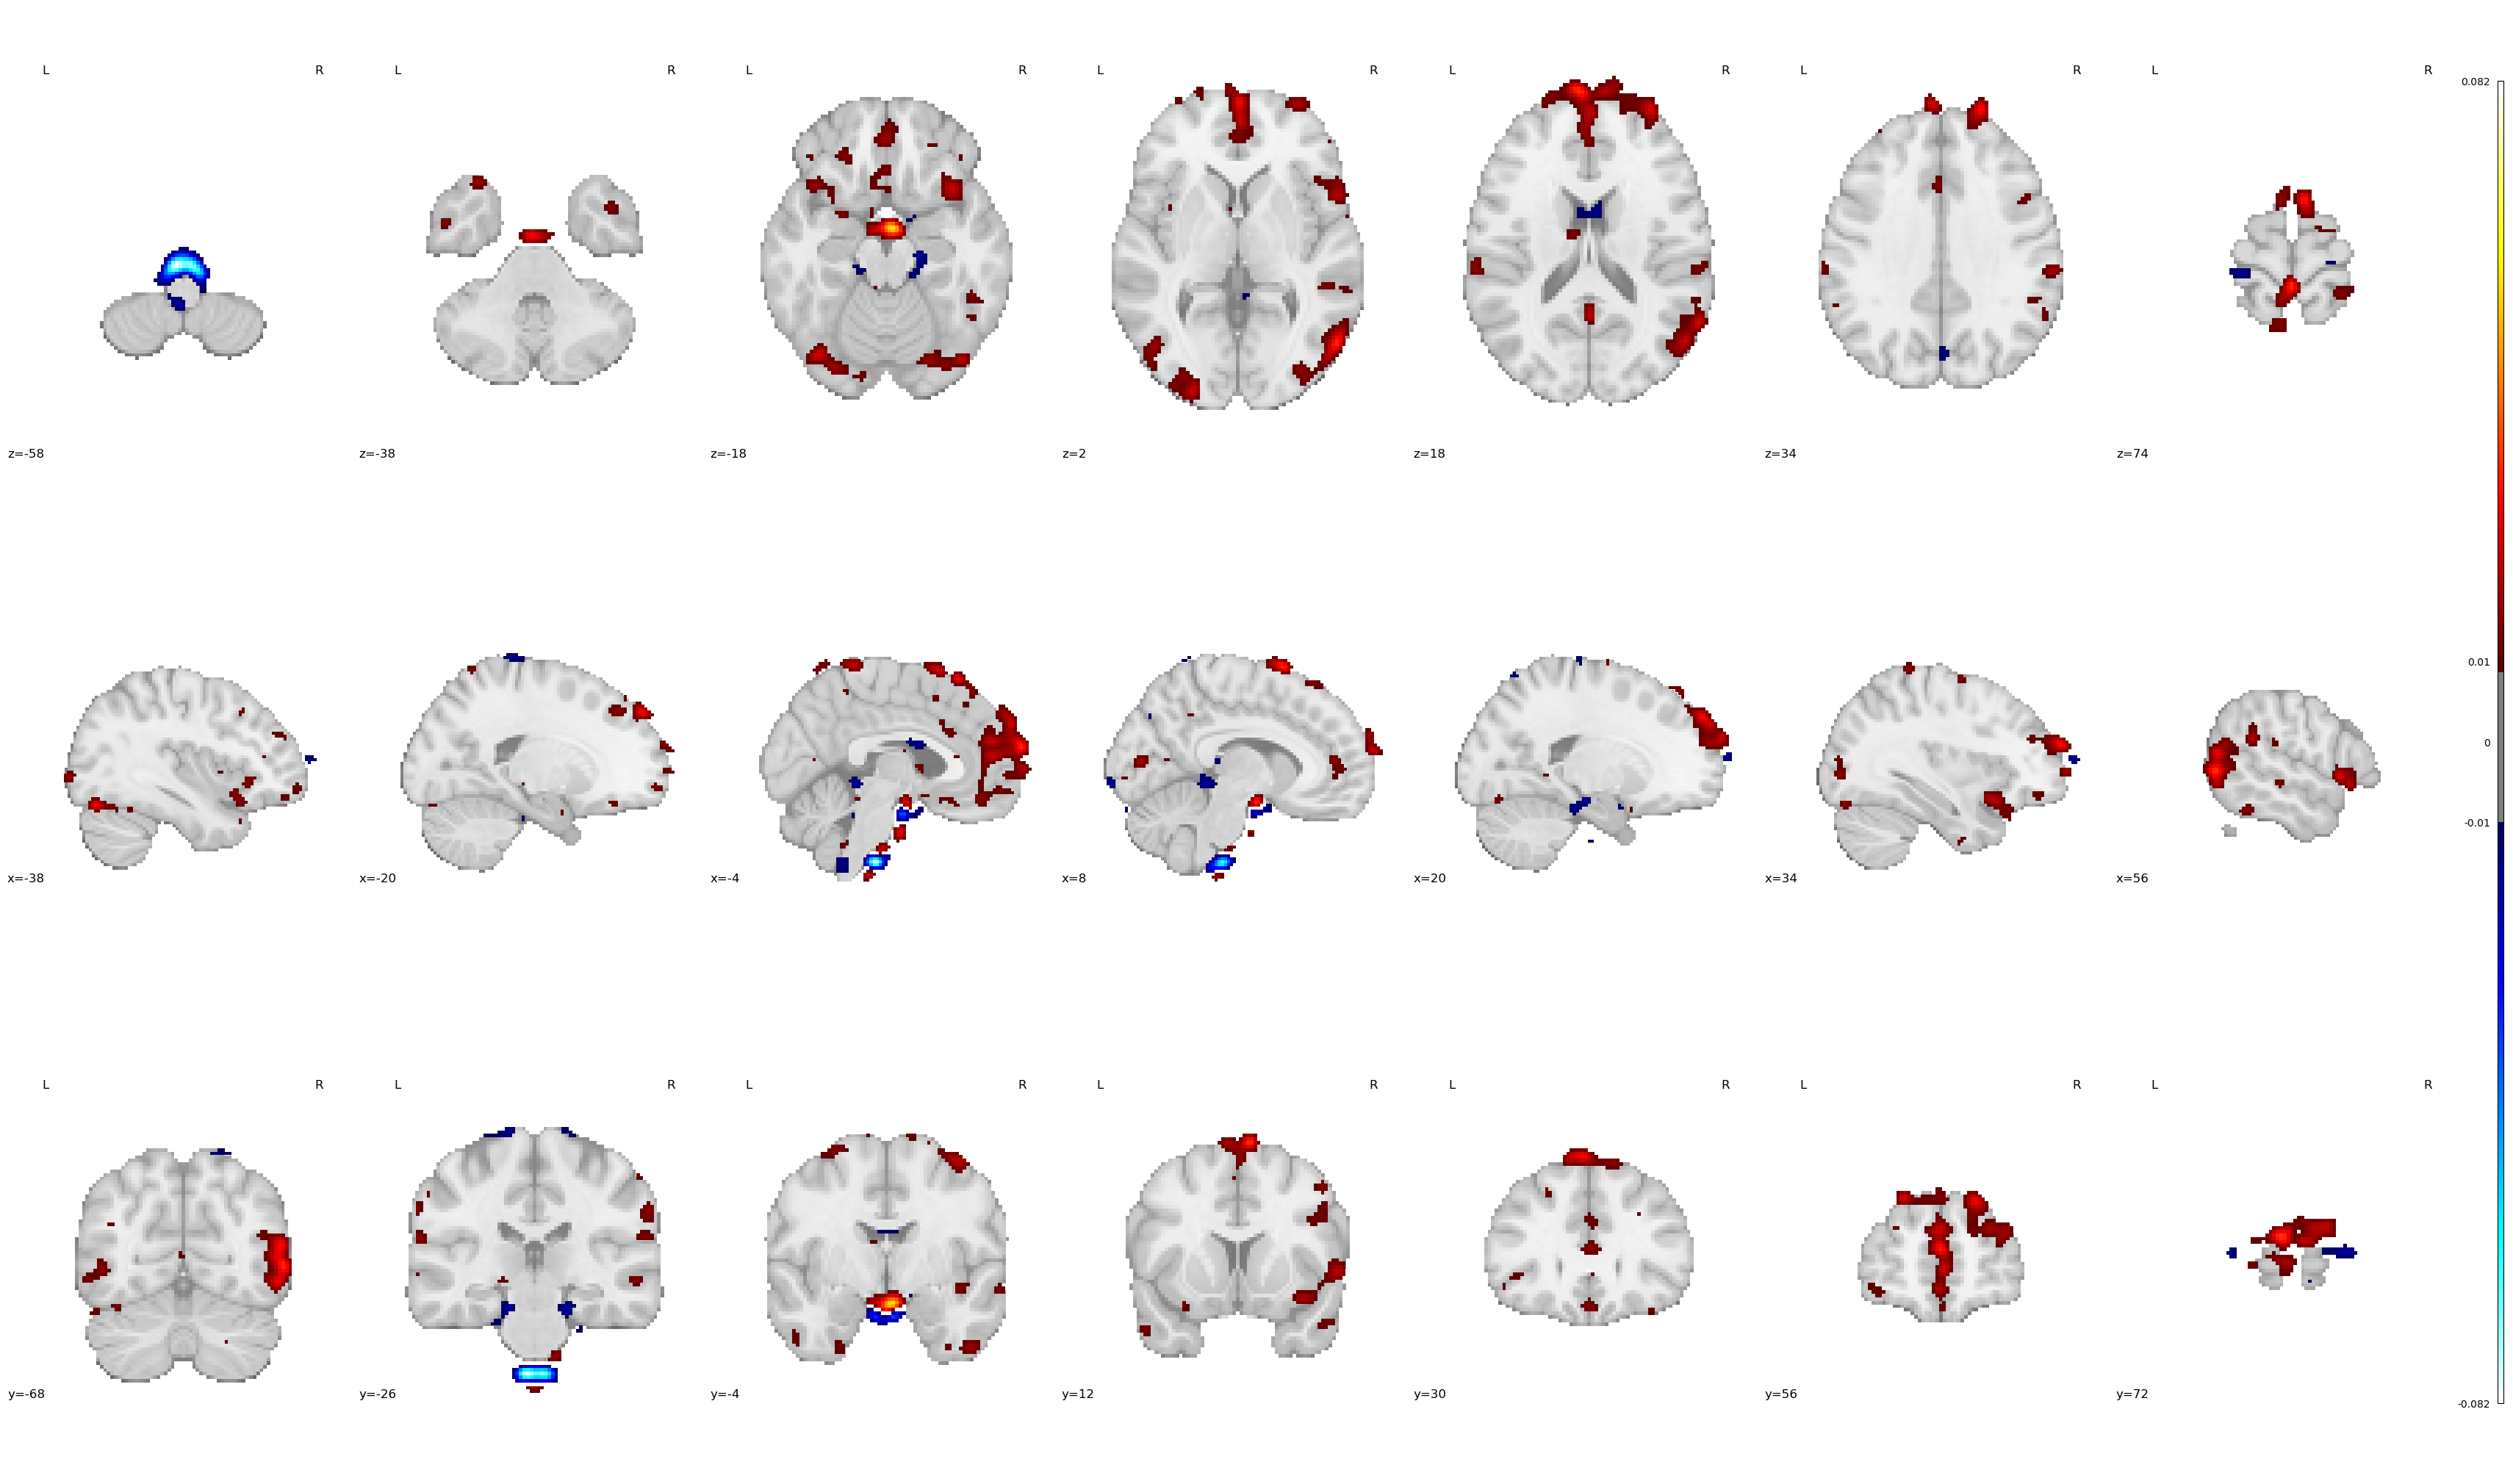

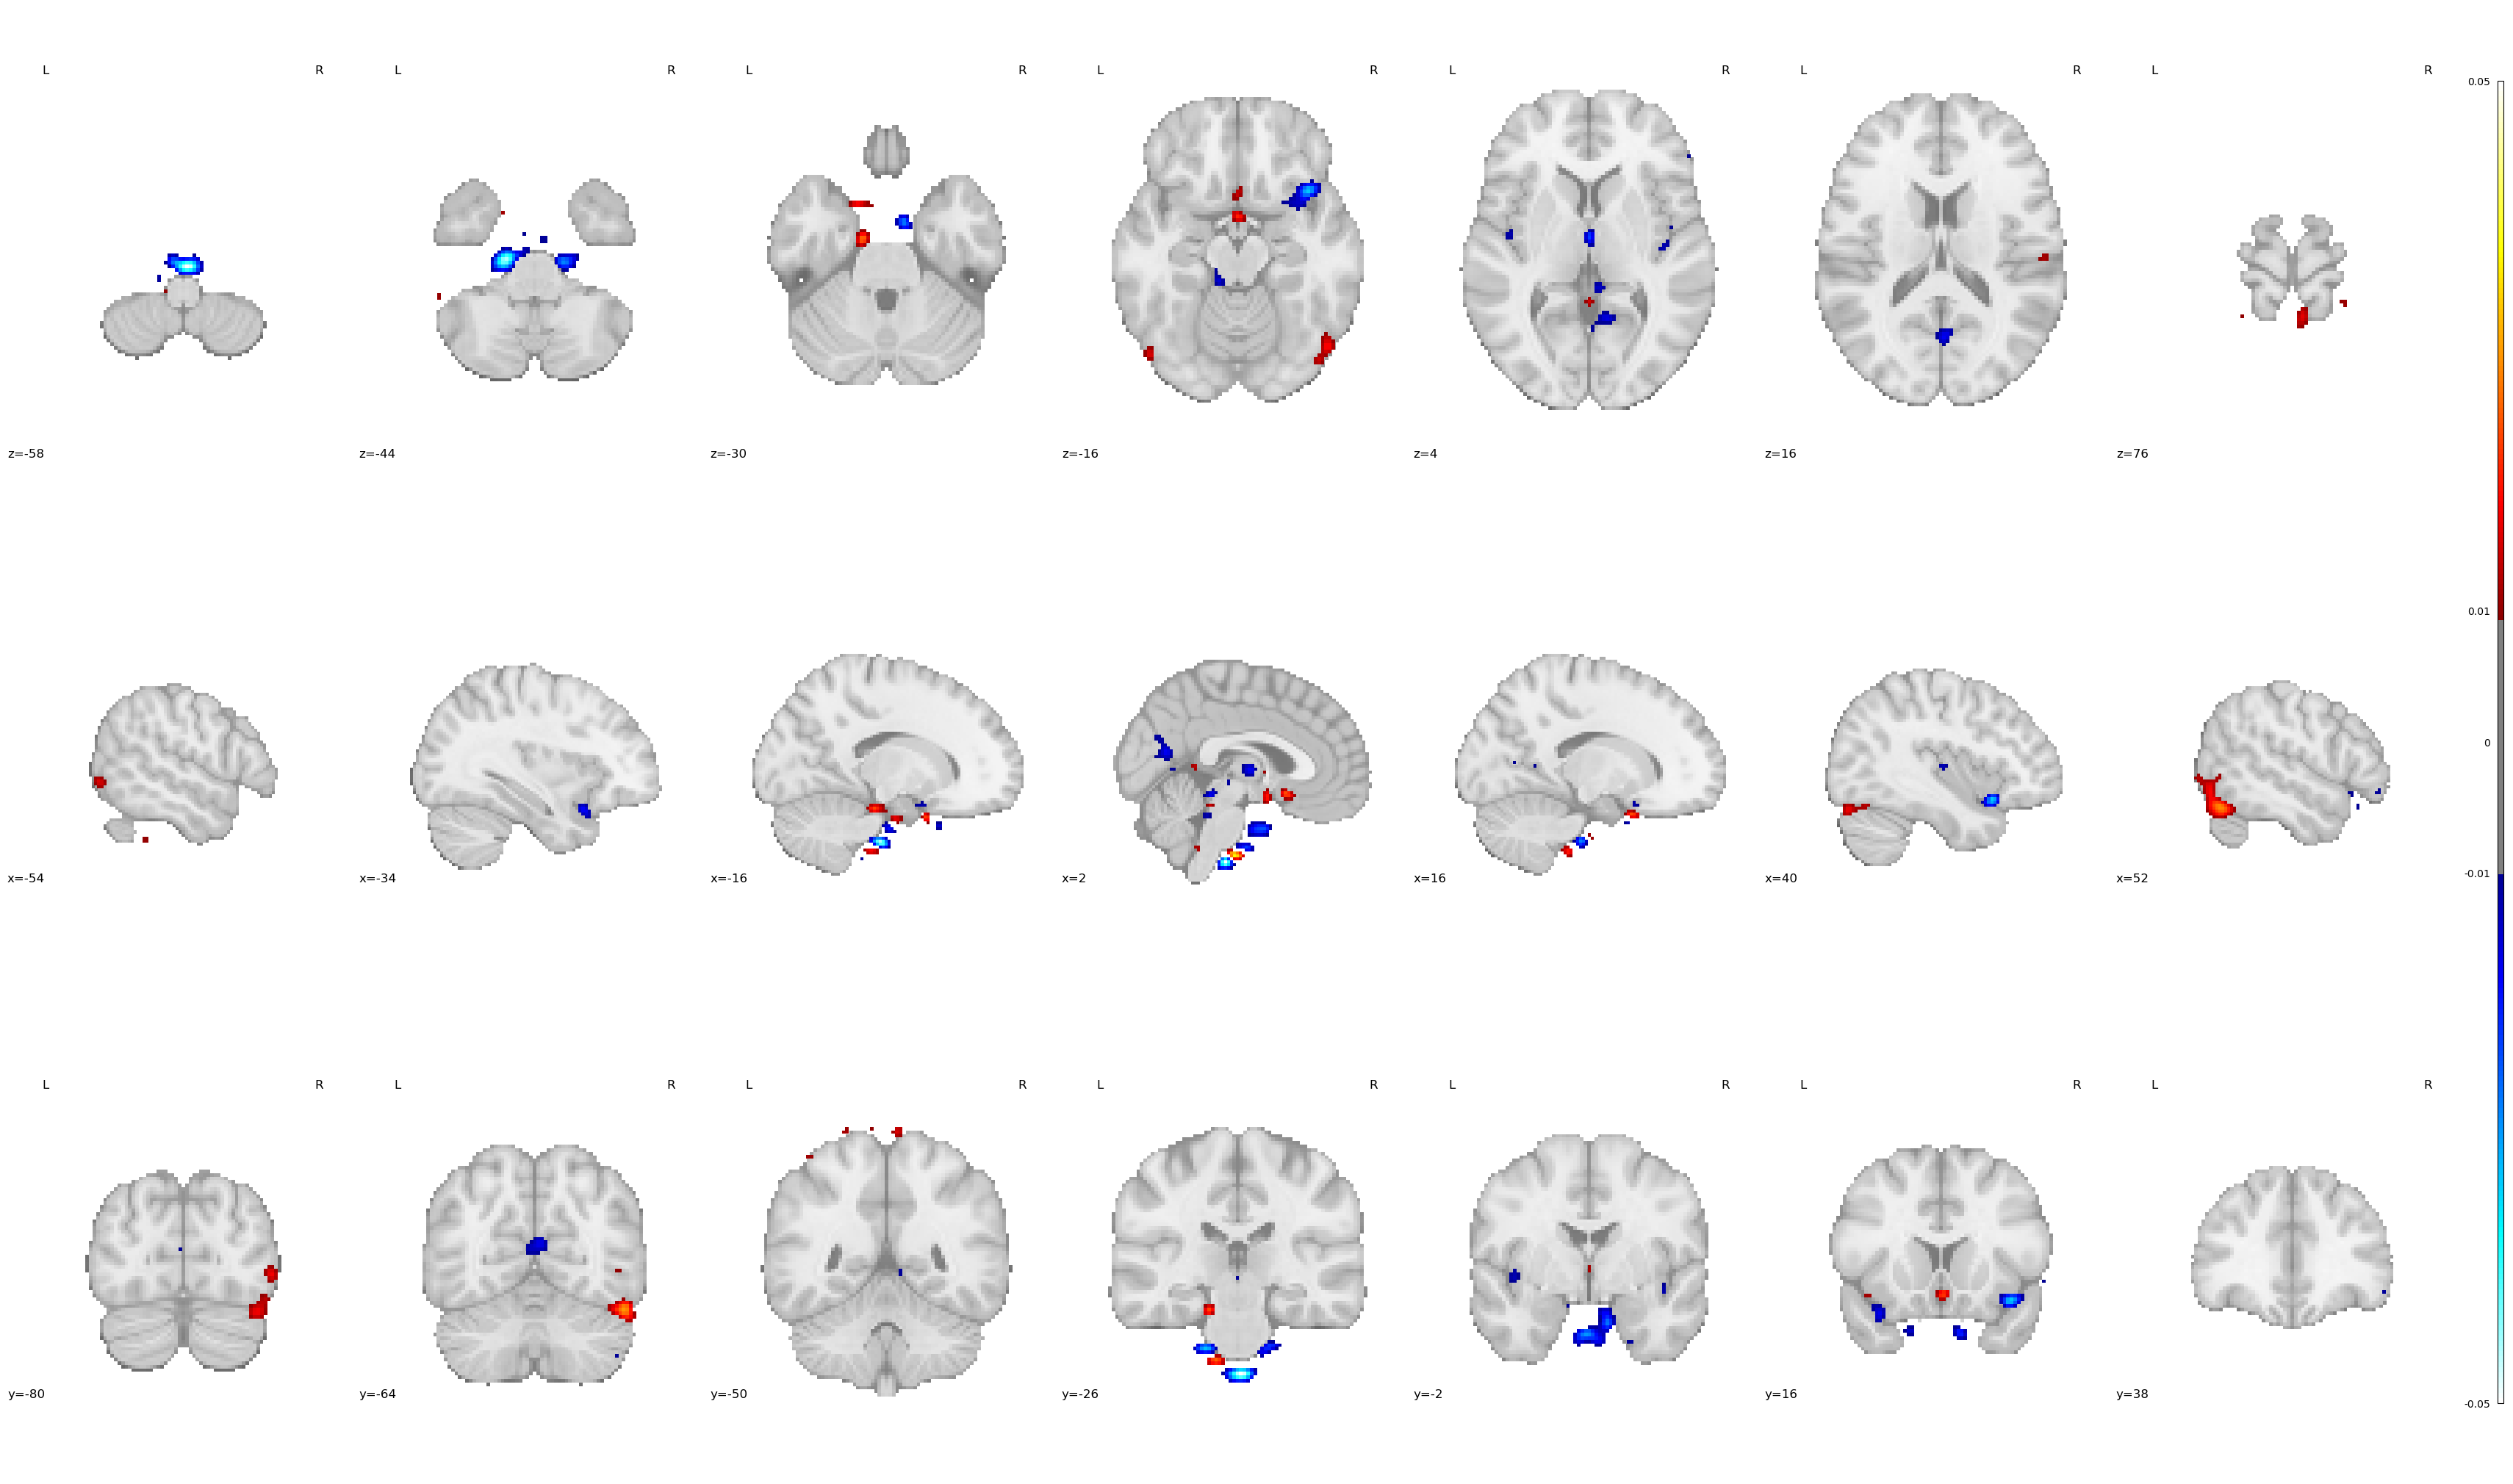

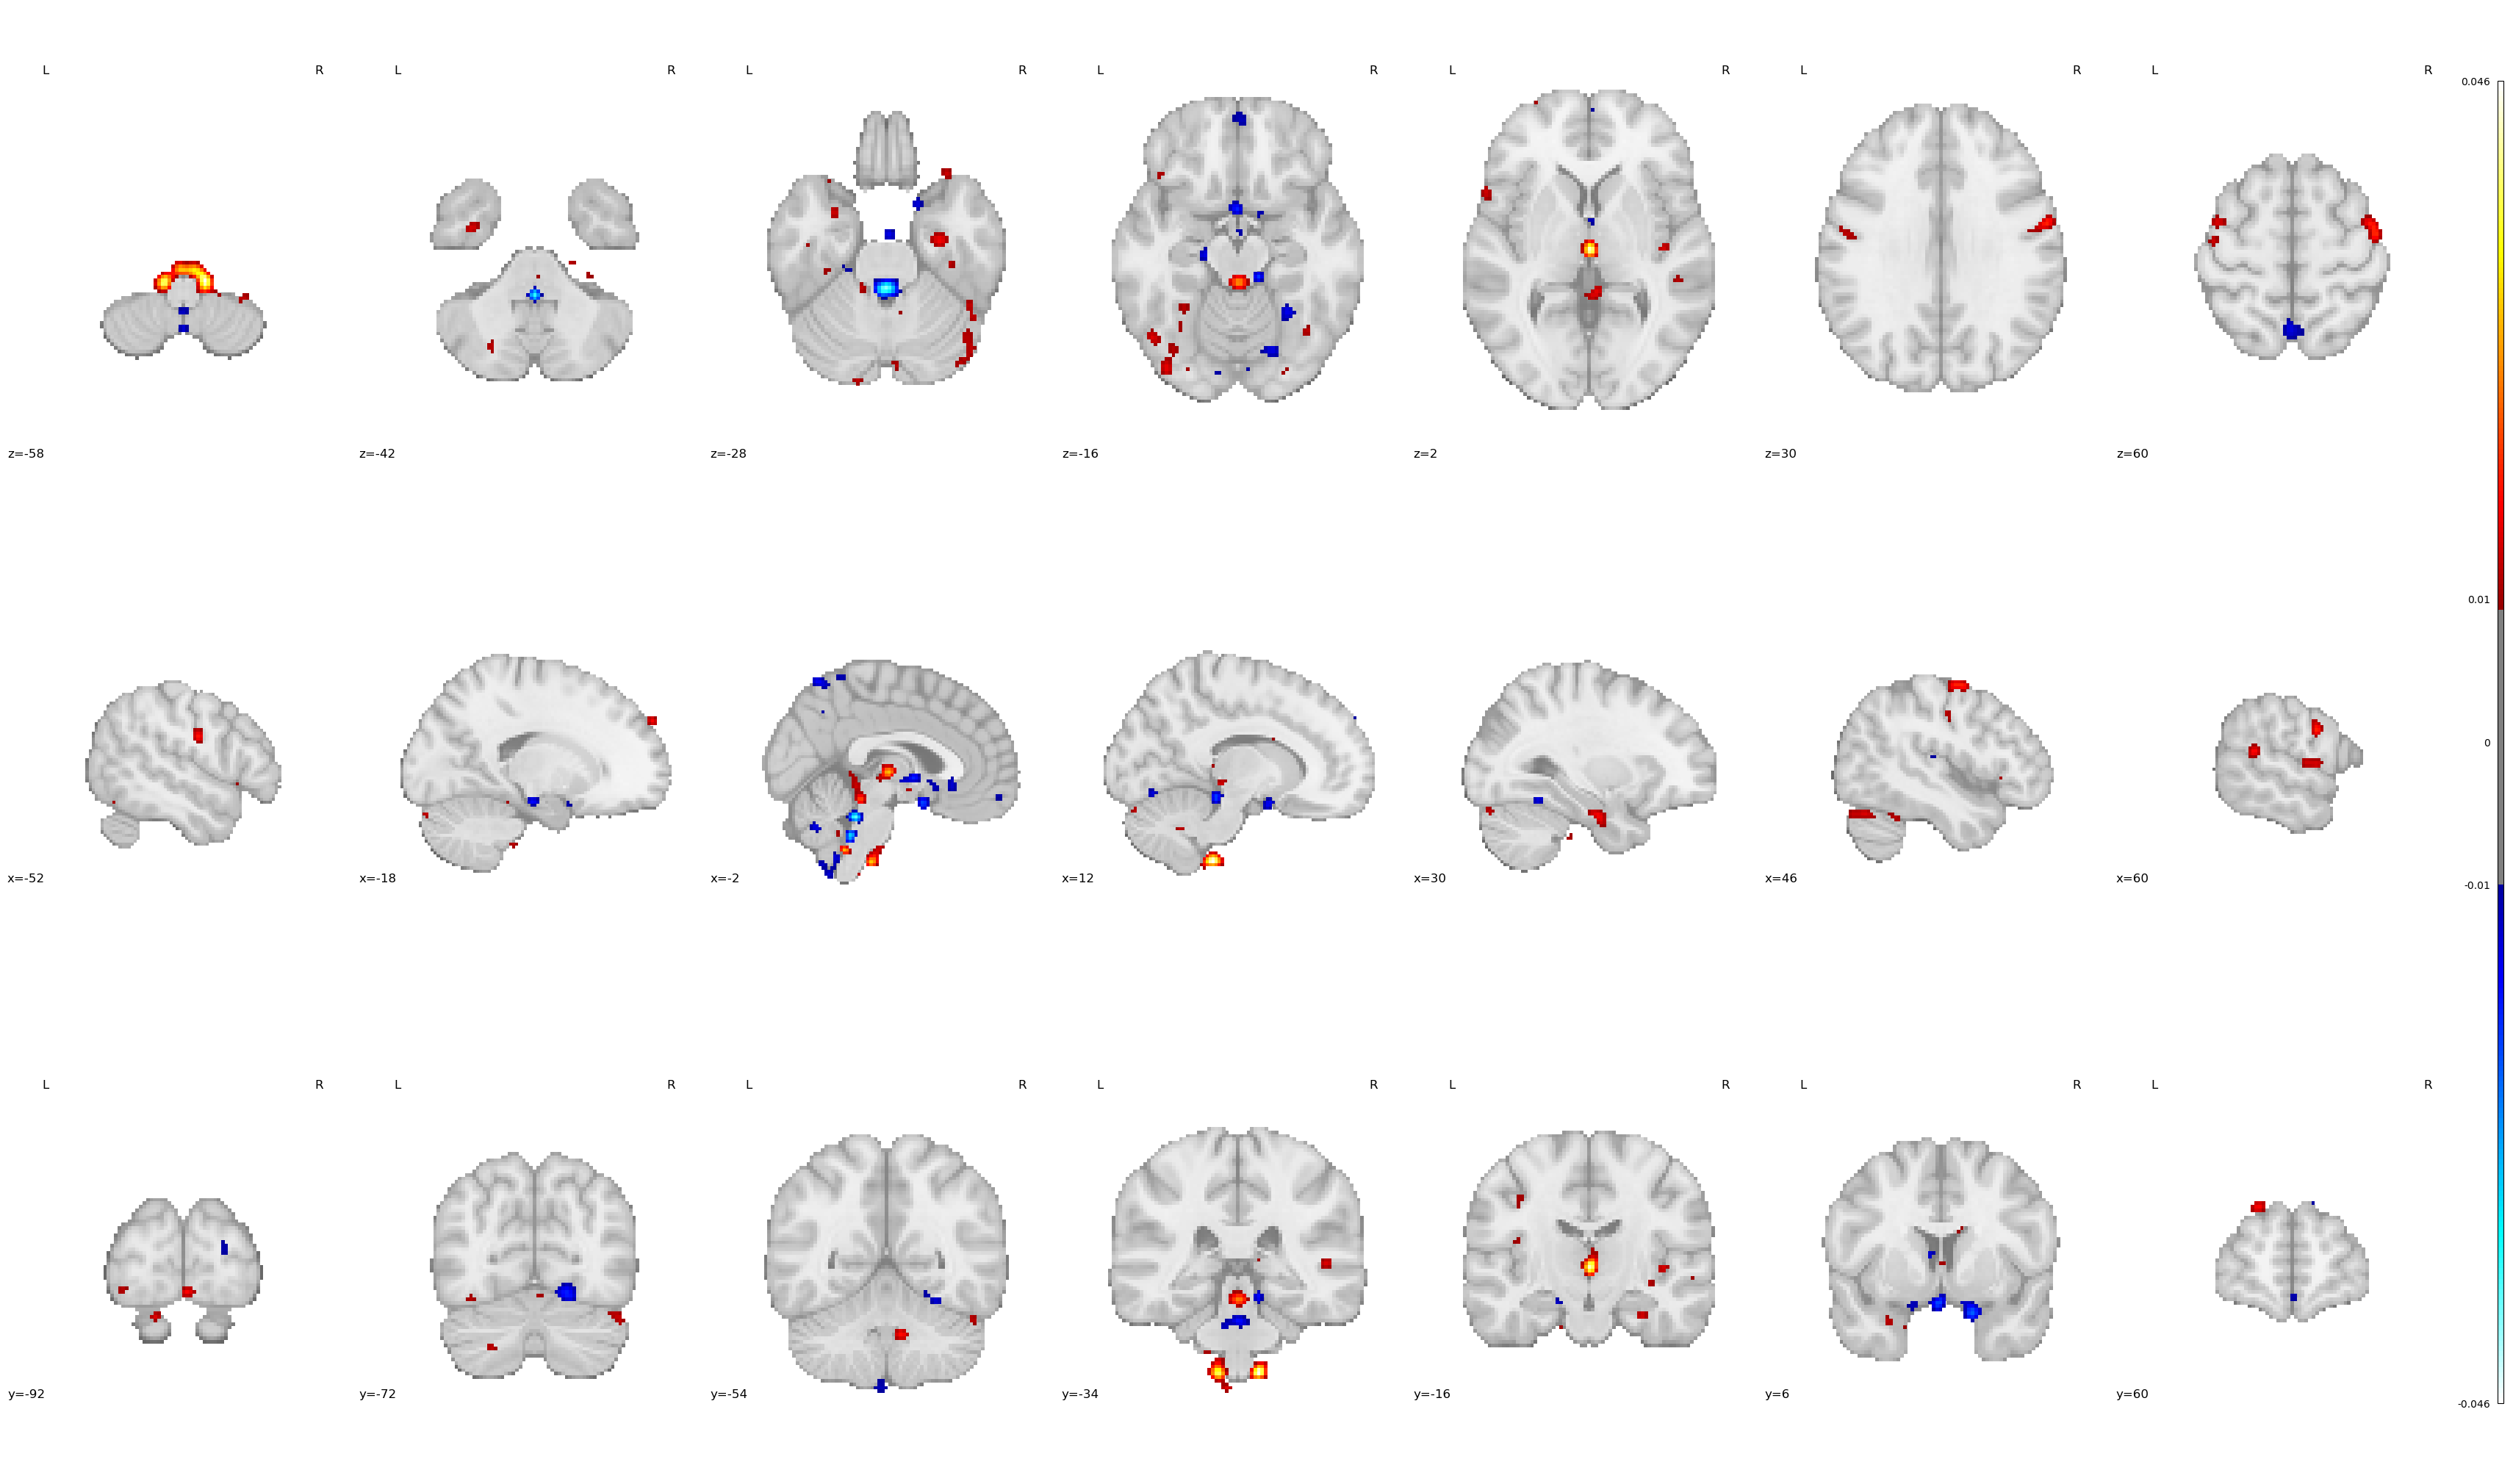

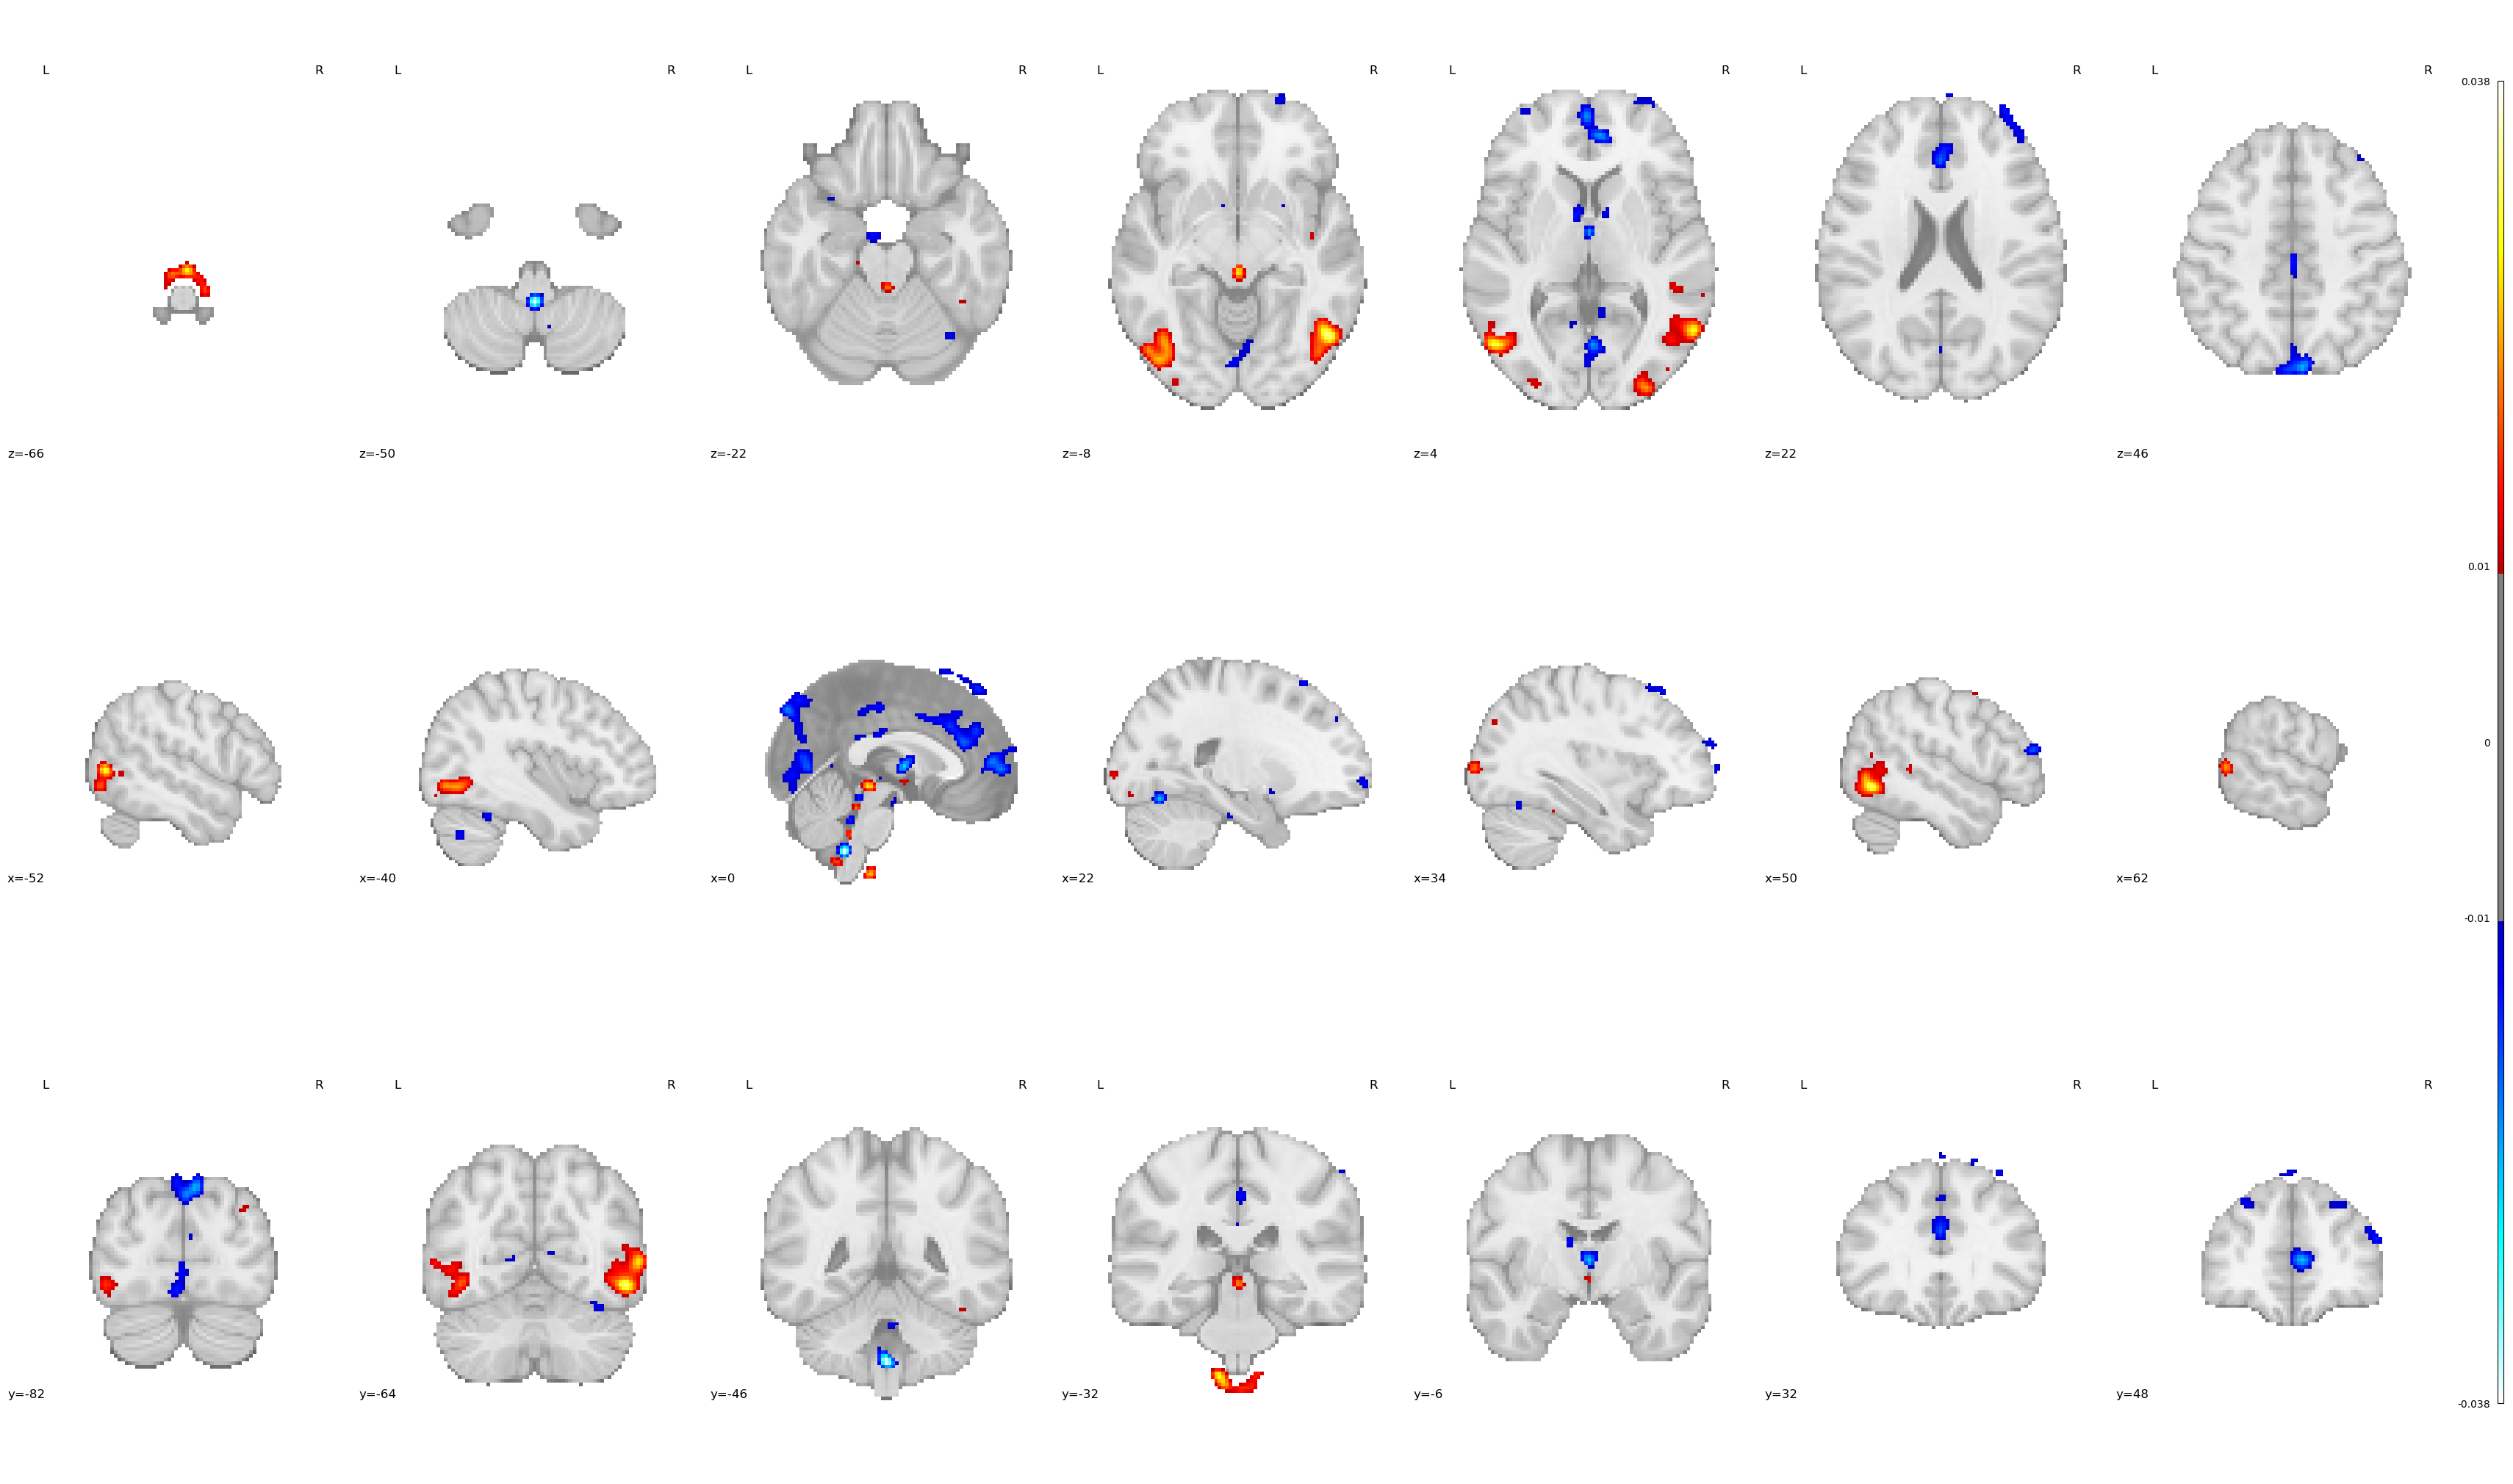

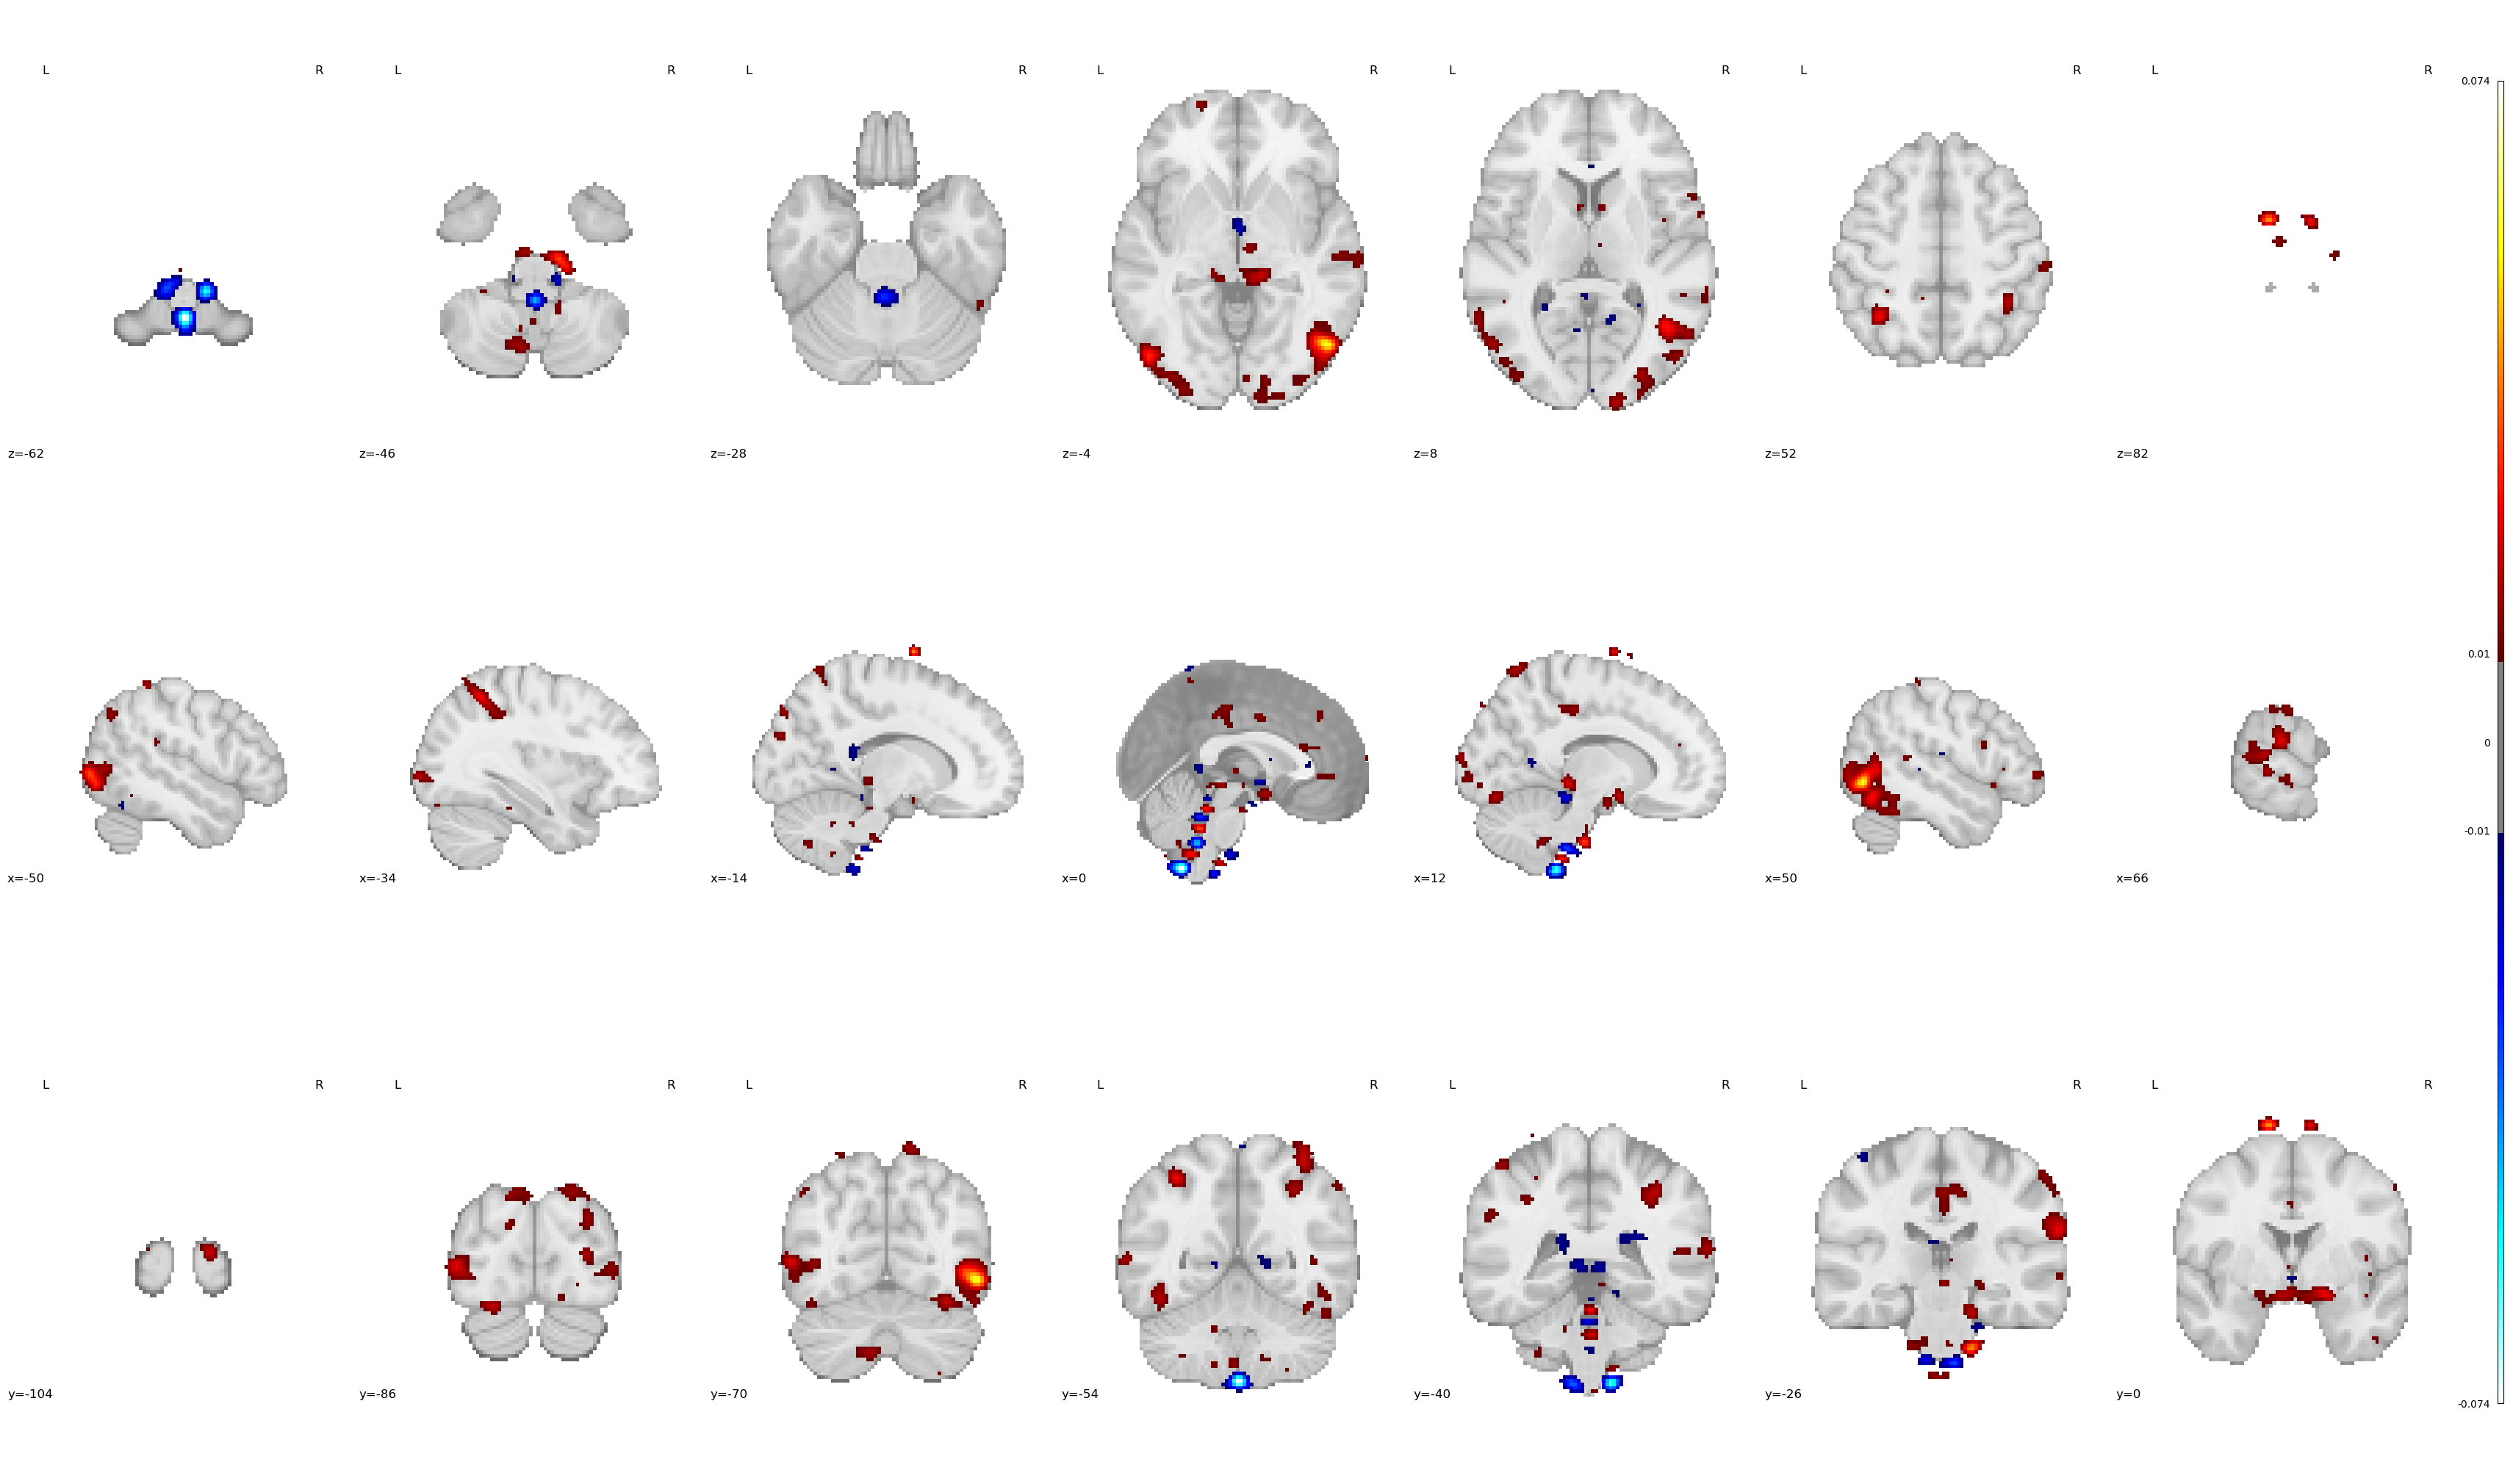

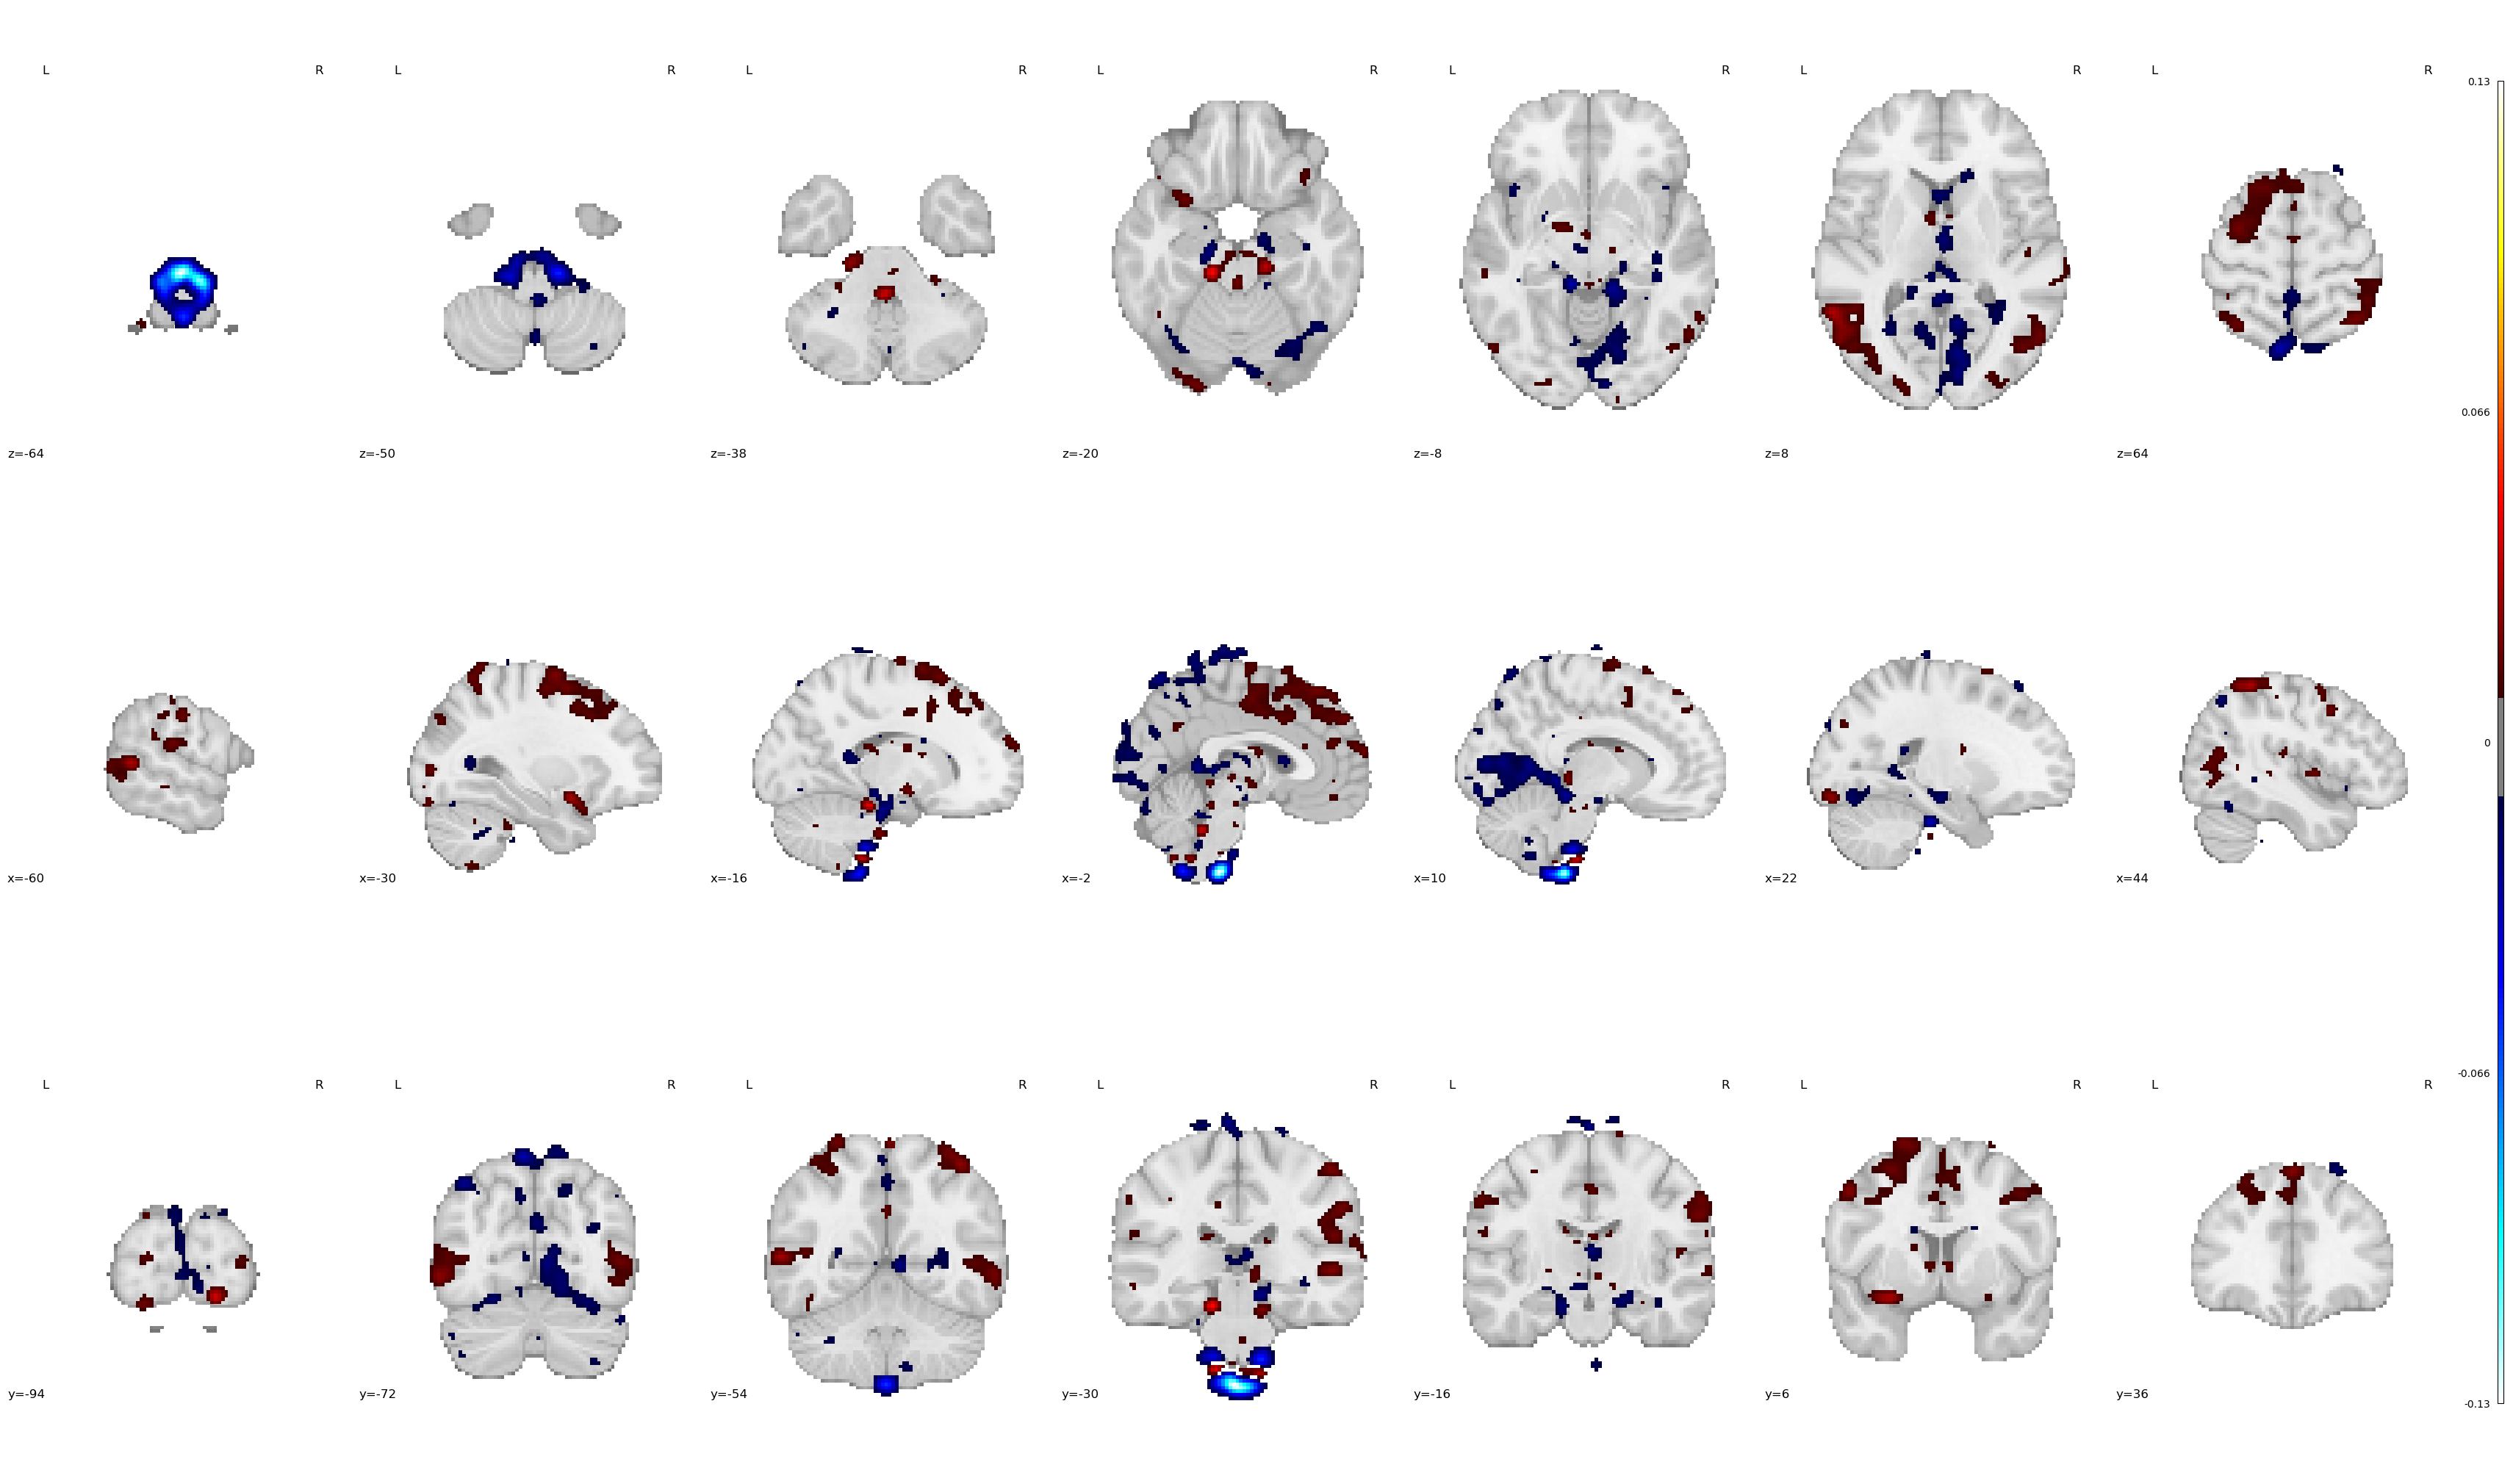

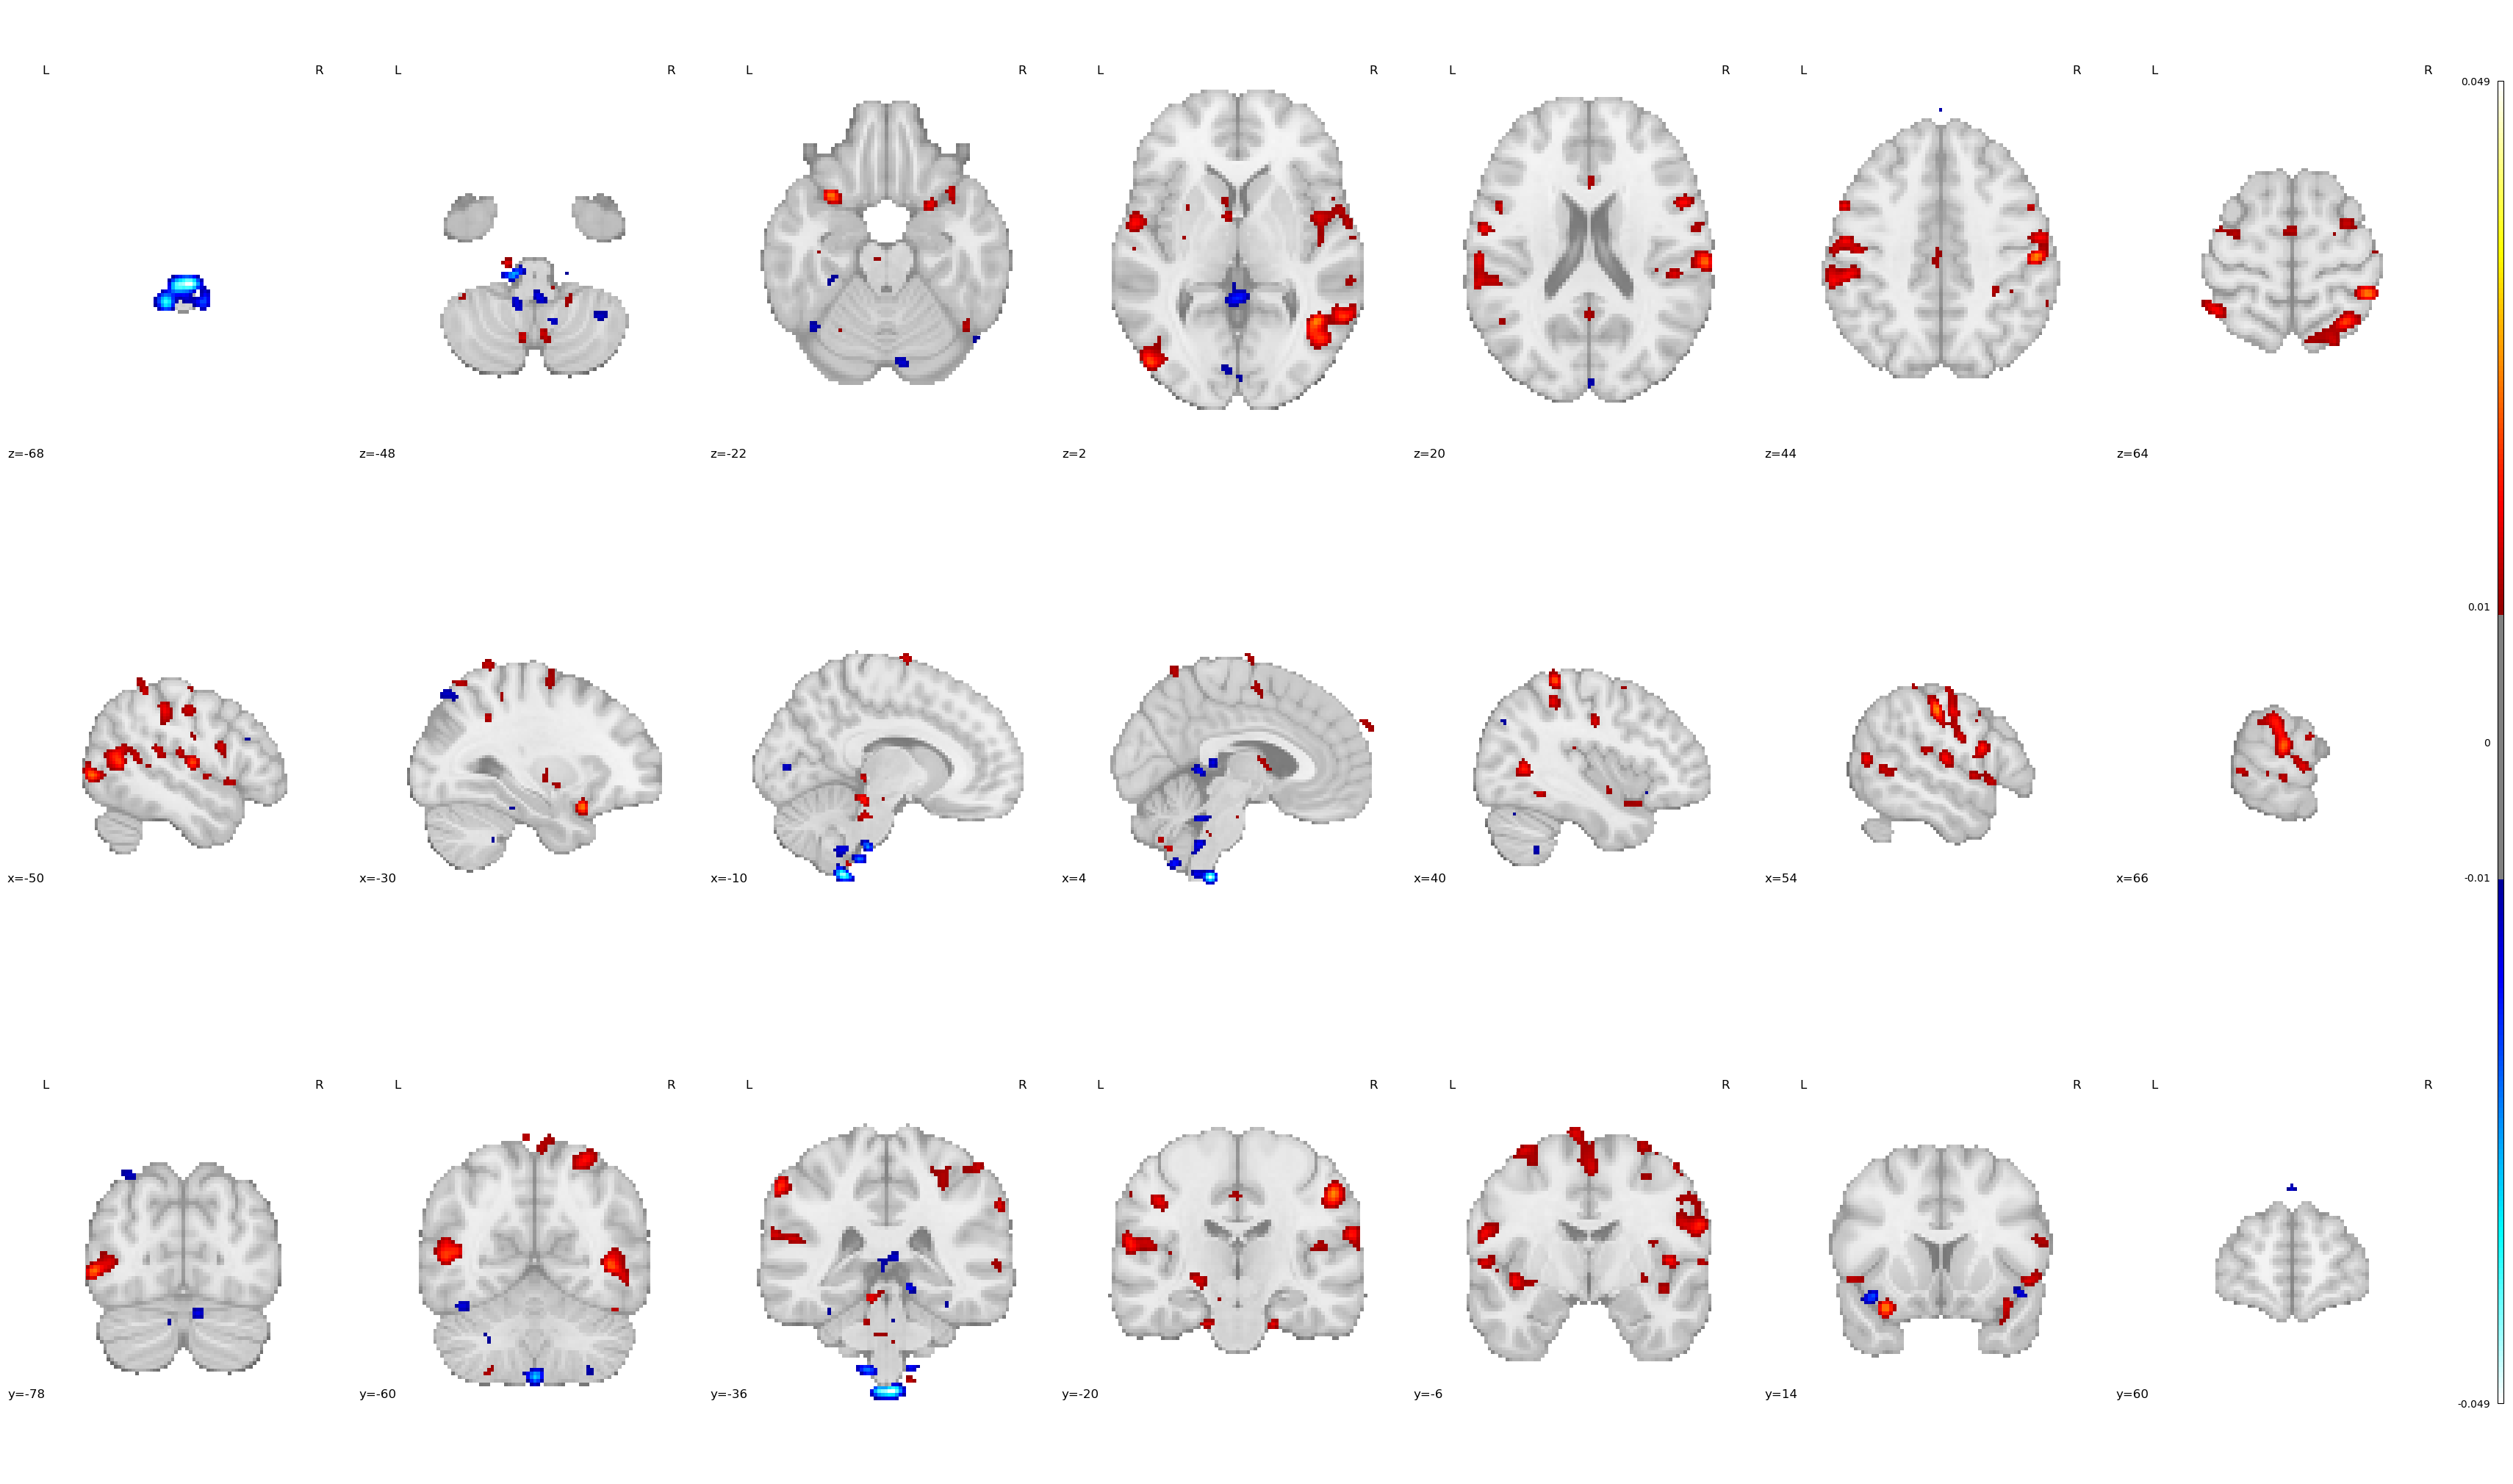

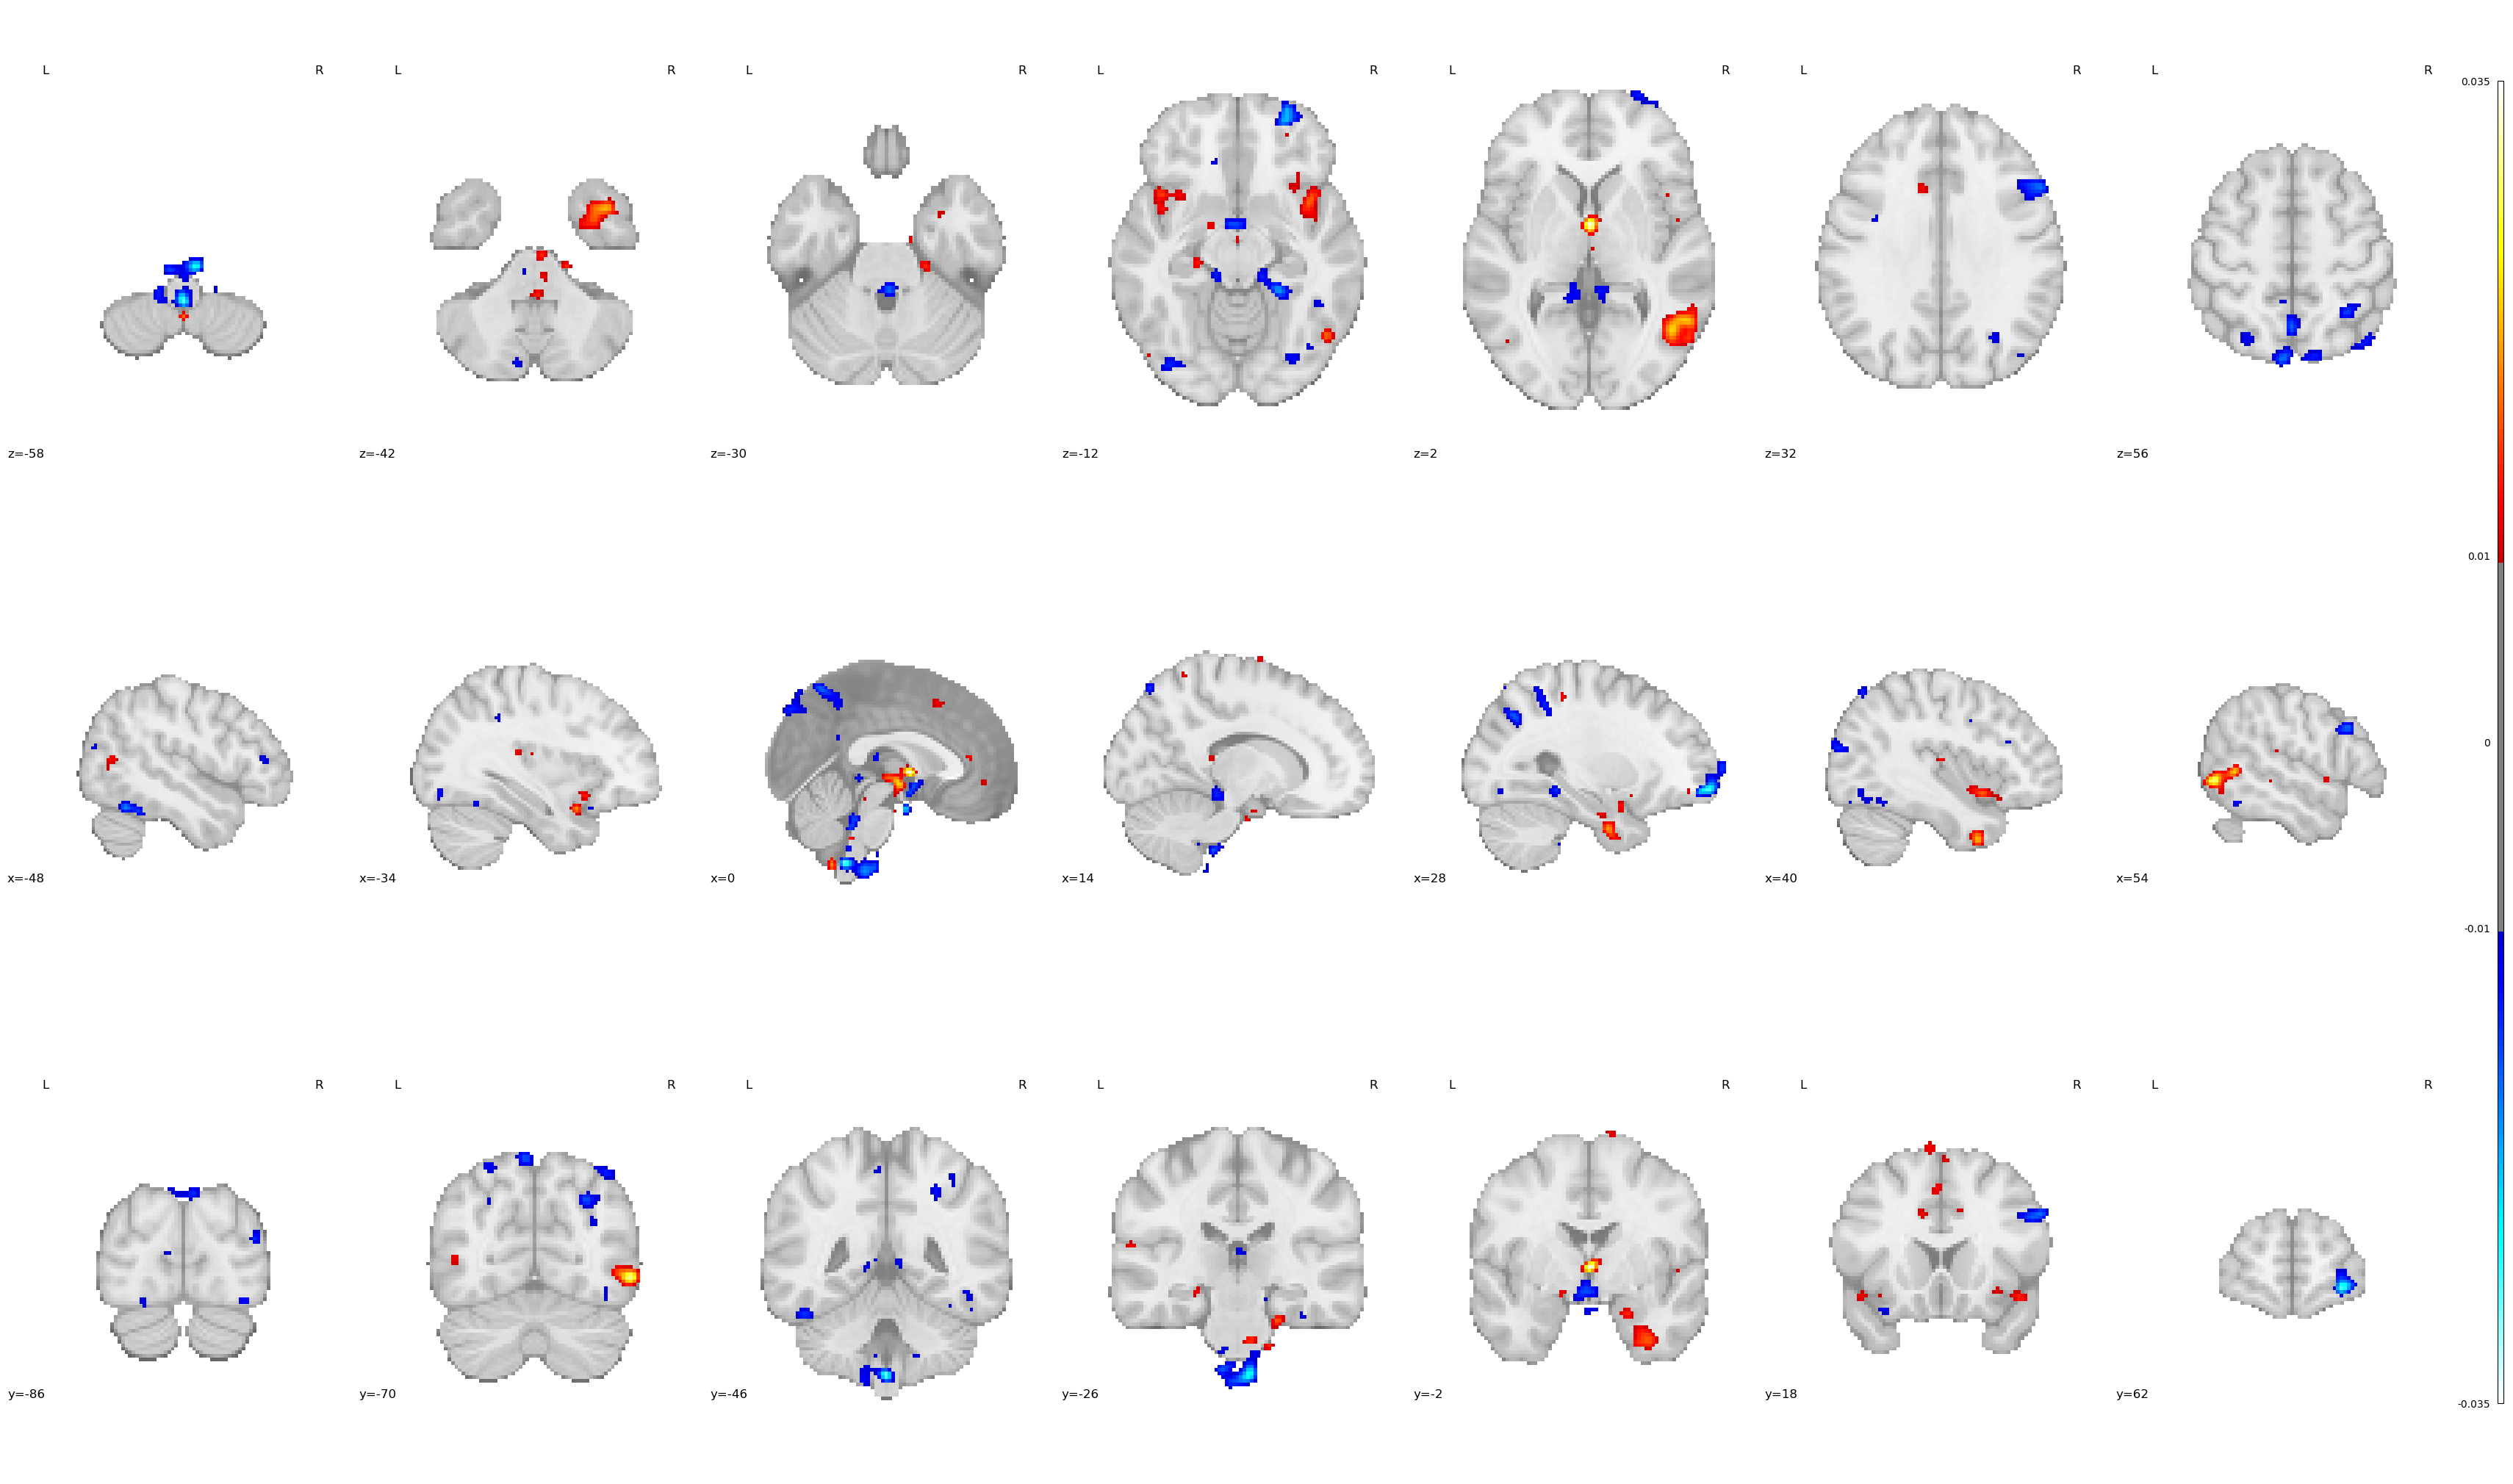

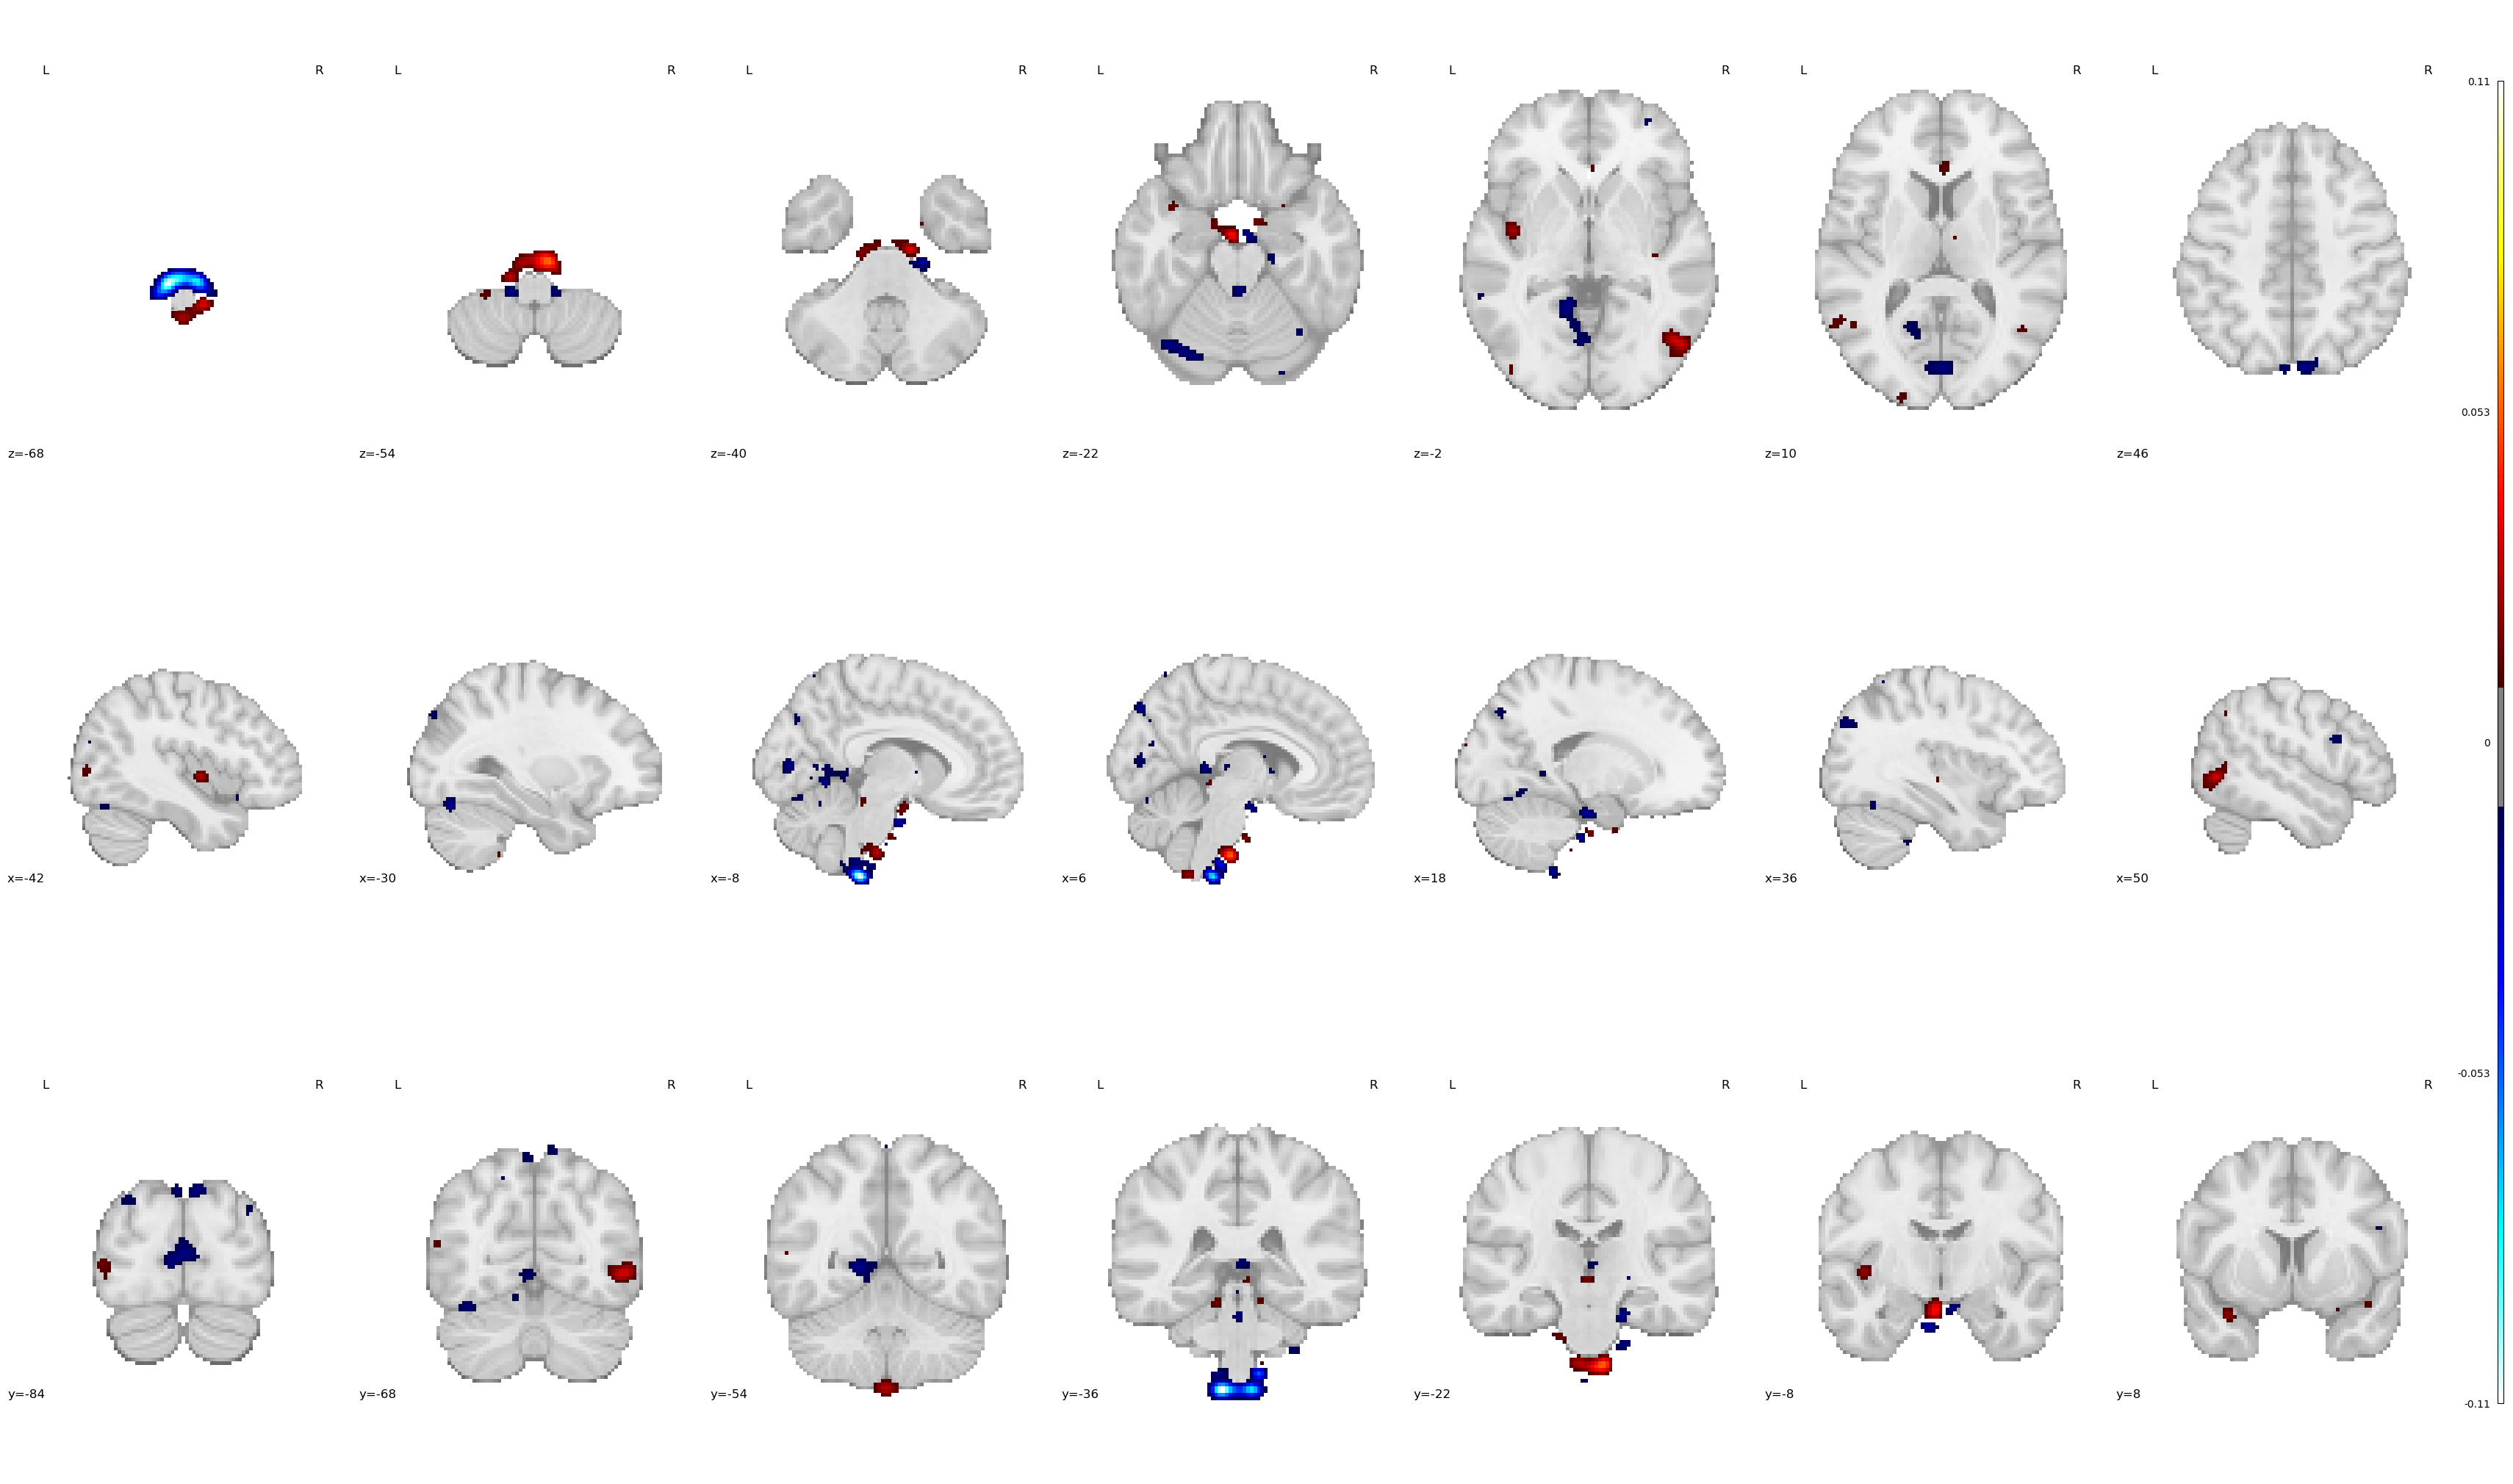

In [63]:
for subject in subjects:
    b_map = nib.load(os.path.join(output_dir, f'{subject}_ses-001_task-rest_run-01_confound-simple_contrast-mov1_sensinput.nii.gz'))
    output_filename = f'{subject}_ses-001_task-rest_run-01_confound-simple_contrast-mov1_sensinput_sm6.png'
    b_map_sm6 = smooth_img(b_map, fwhm=6)
    disp = plotting.plot_stat_map(b_map_sm6, threshold=0.01, display_mode='mosaic')
    disp.savefig(os.path.join(output_dir, output_filename))
    


In [30]:
f = nib.load(models_run_imgs[0][0])
fimg = f.get_fdata()
fimg.shape

(91, 109, 91, 404)

In [ ]:
#for run_idx, (img, event, confound) in enumerate(zip(models_run_imgs[0], models_events[0], models_confounds[0])):
#run = f'run-{run_idx+1:02d}'
#print(f'  Processing {run}')


/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: weight
  warnings.warn(


In [ ]:
# compute_regressor expects columns in the order: onset, duration, amplitude


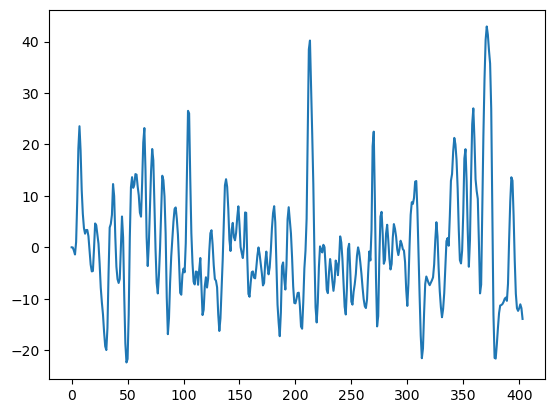

In [26]:
plt.plot(exp_regressor)

In [27]:
X.iloc[:,0] =exp_regressor  # Replace the first regressor with our custom regressor
X.columns.values[0] = 'Sensory_Input'  # Rename the column accordingly

<Axes: label='conditions', ylabel='scan number'>

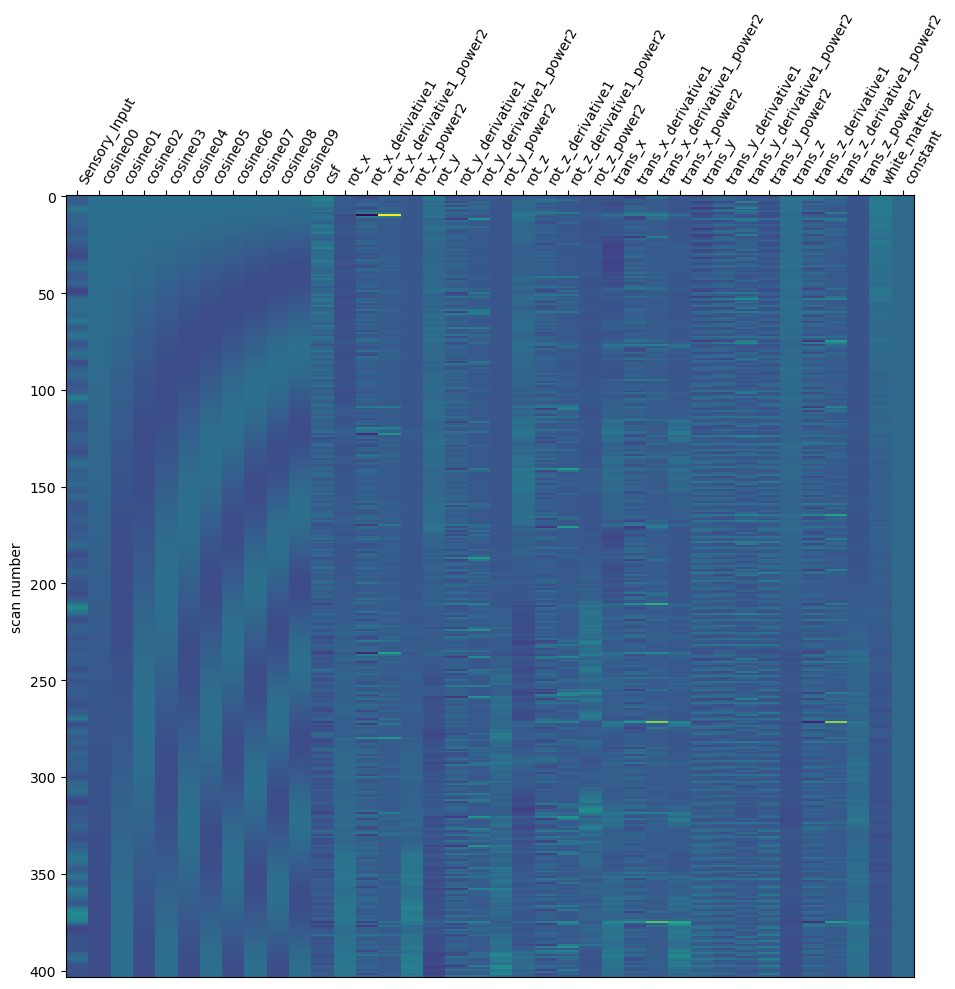

In [28]:
plot_design_matrix(X)

In [31]:
fitted_model = models[0].fit(img, design_matrices=X)
#models

/group/tuominen/anaconda3/lib/python3.11/site-packages/nilearn/image/image.py:217: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn(


In [34]:
contrasts = {
                'mov1_sensinput': 'Sensory_Input',
             }

for contrast_name, contrast_def in contrasts.items():
    b_map = models[0].compute_contrast(contrast_def, output_type='effect_size')
    output_filename = f'{subject}_ses-001_task-rest_run-01_confound-simple_contrast-{contrast_name}.nii.gz'
    nib.save(b_map, os.path.join(output_dir, output_filename))


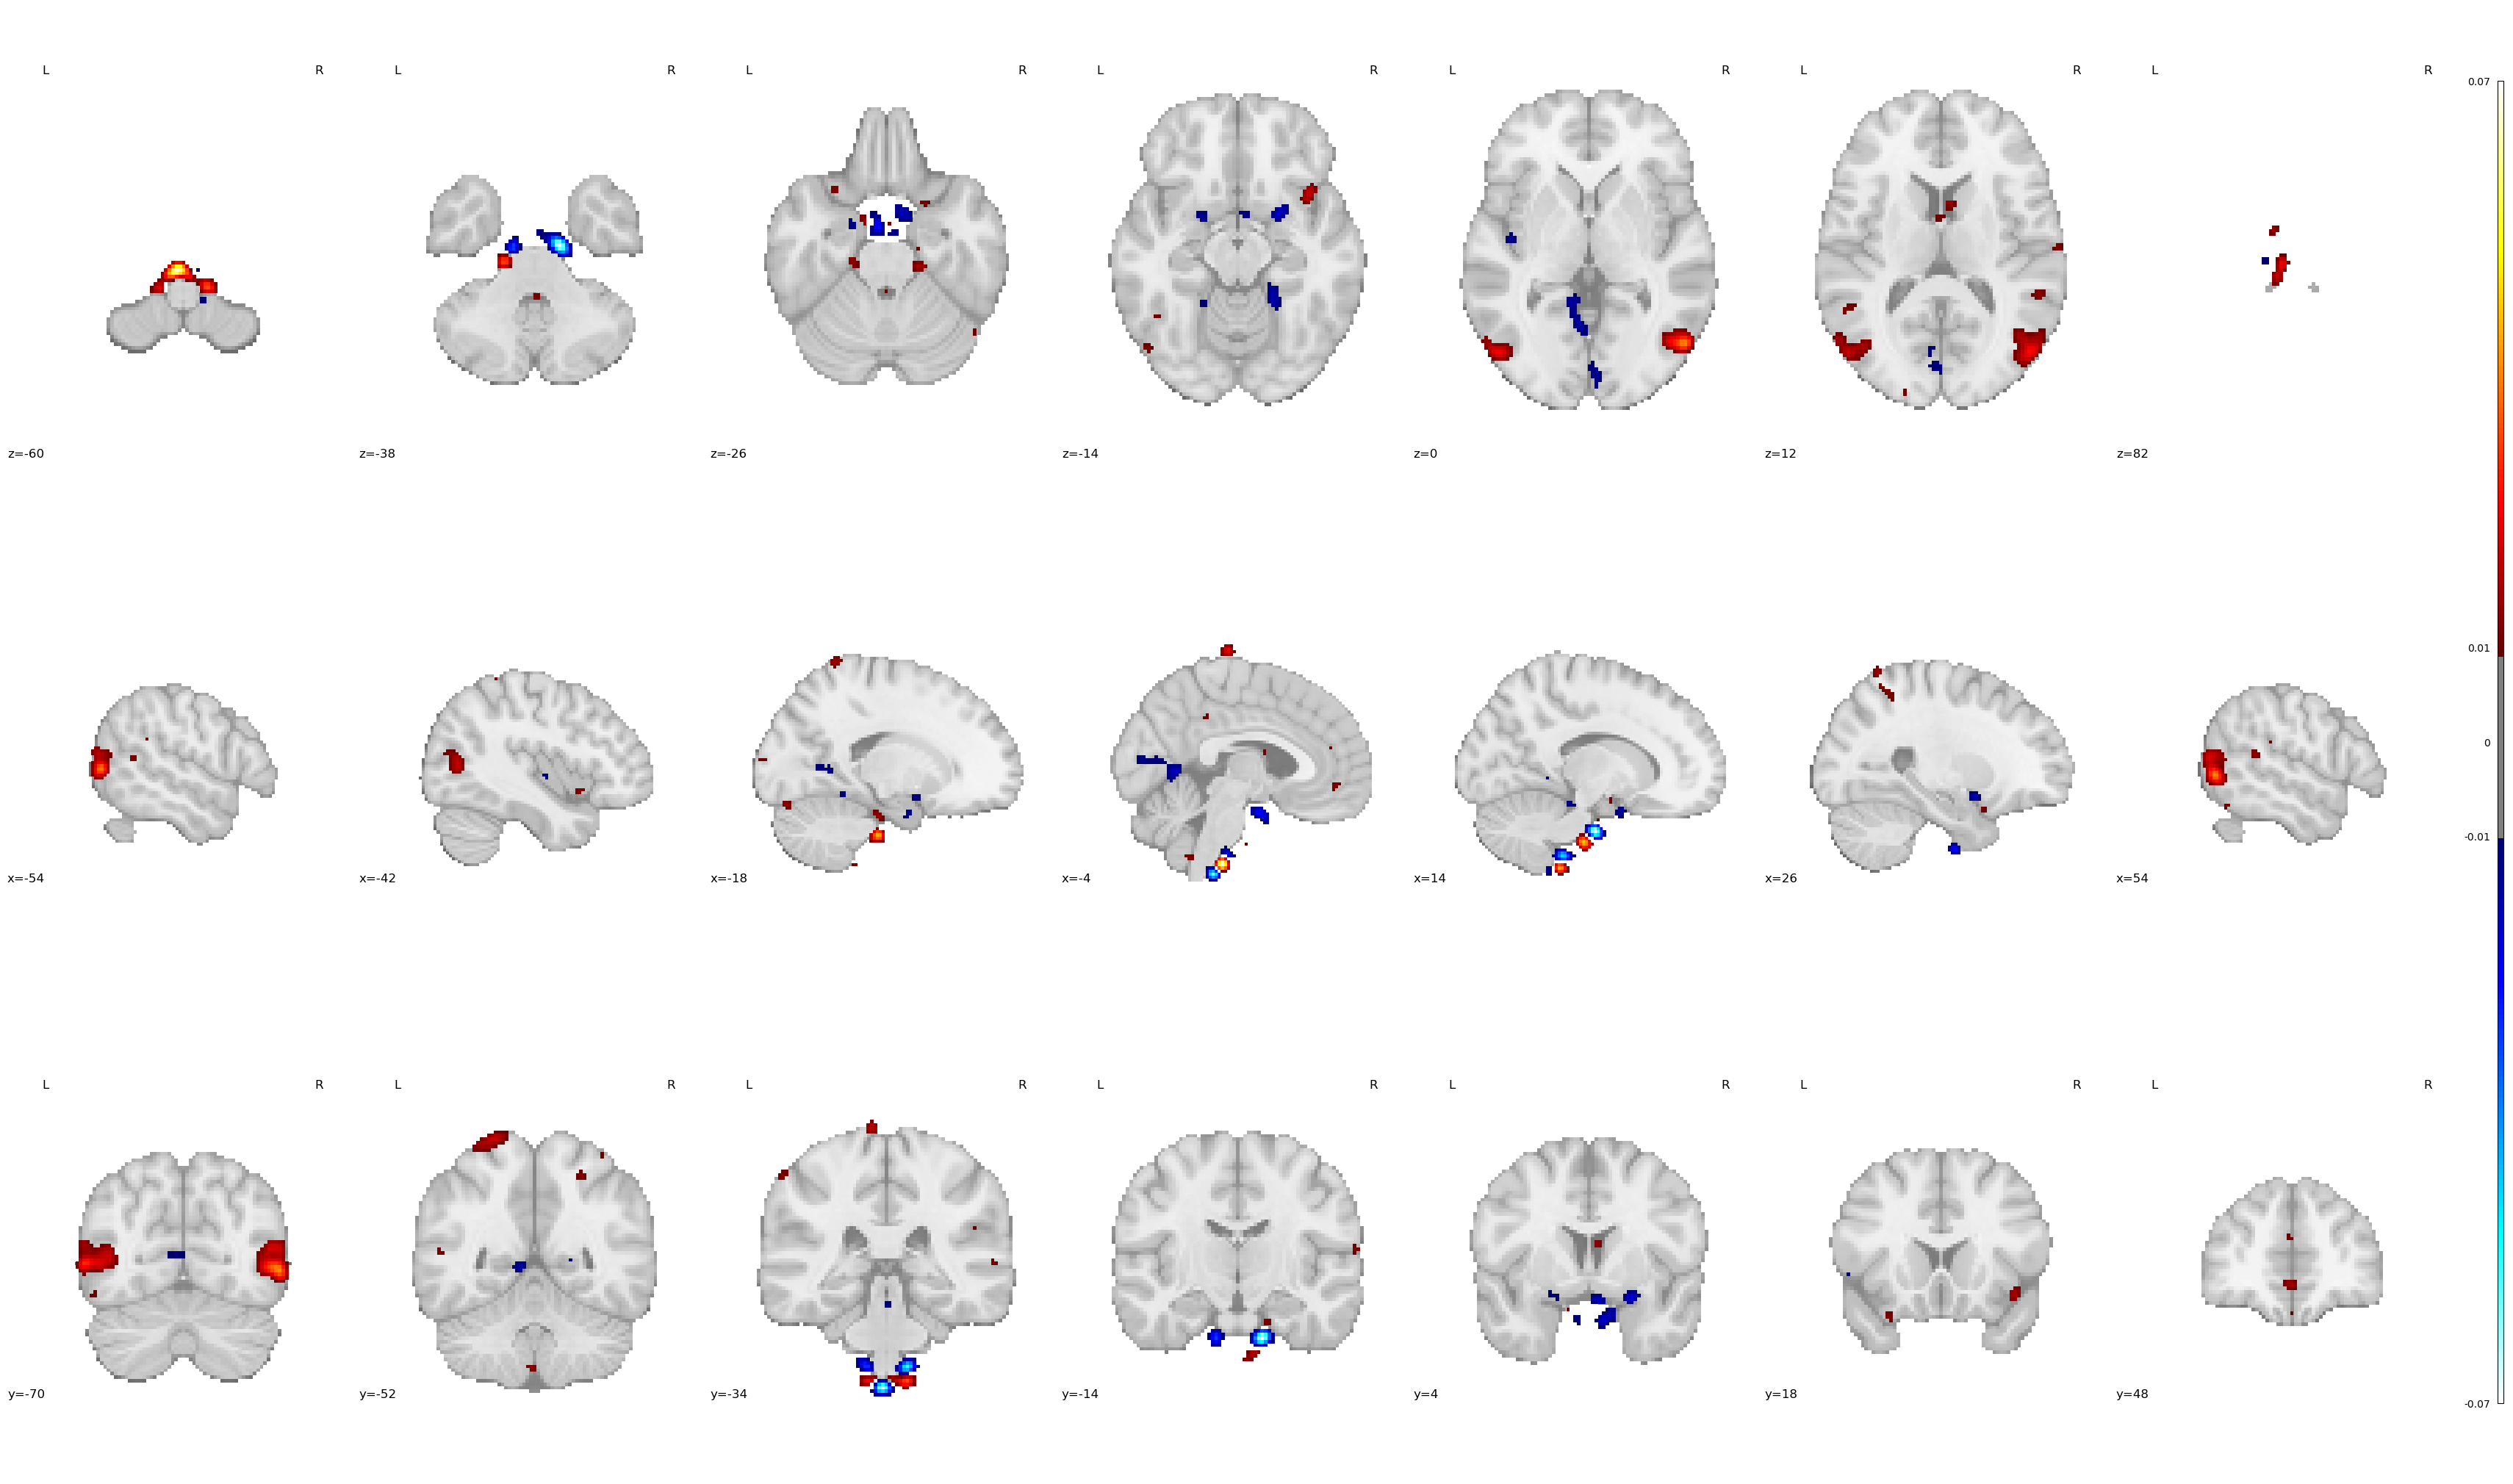

In [ ]:
from nilearn.image import smooth_img
#contfile = os.path.join(output_dir, output_filename)
b_map_sm6 = smooth_img(b_map, fwhm=6)

plotting.plot_stat_map(b_map_sm6, threshold=0.01, display_mode='mosaic')
